# CS109b Project: Final Milestone

Note: The notebook you are seeing now is an extension of a **Harvard CS109b (*Advanced Topics in Data Science*)** project I performed in tandem with two other students, **George Popoola** and **Brian Ndzuki**, and includes alterations to some of the work they contributed. The portions of the project (both code and text) completed primarily by these individuals will be indicated clearly with an orange background and their names accredited. Additionally, as this was a school project I had access to cluster computing resources that I unfortunately can no longer access at the present moment. As a result despite my best efforts toward configuring my local installation of tensorflow, attempting to rerun some of the operations in section [3](#3) and onwards have thrown errors present in the notebook. I'll do my best to resolve those when I have the chance, but the results visible following those errors should be accurate and reproducible if executed in the proper environment.

In [81]:
import os
import pathlib
import time
import zipfile
import imageio
import pickle
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import time
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization, ReLU
from tensorflow.keras.layers import Conv2D, Conv1D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, Add, MaxPool1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tf_keras_vis
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.utils import plot_model
from matplotlib import cm
import pandas as pd
import tqdm

%matplotlib inline
import scipy.signal as sp
import seaborn as sns

sns.set_theme()

In [101]:
# import module compatible w/ data format
try: 
    import wfdb
except:
    !pip install wfdb
    import wfdb

# create directories to store pickle files
for dirname in ['model_histories', 'pickle_data']:
    try:
        os.mkdir(dirname)
    except FileExistsError:
        pass

# Table of Contents

- [Problem Statement](#0)
- [1. Preprocessing](#1)
    - [1.1 Demographic Data Encoding](#1.1)
    - [1.2 Split ECG Signals](#1.2)
    - [1.3 Oversampling](#1.3)
- [2. Data Exploration](#2)
    - [2.1 Age and Sex Correlation of # of Abnormalities](#2.1)
    - [2.2 ECG Trace EDA](#2.2)
    - [2.3 EDA of Unencoded Demographic Information](#2.3)
- [3. Base Model](#3)
    - [3.1 Create Tensorflow Datasets](#3.1)
    - [3.2 Model Definition](#3.2)
    - [3.3 Model Training](#3.3)
        - [3.3.1 Ischemia](#3.3.1)
            - [Evaluation](#3.3.1eval)
        - [3.3.2 Hypertrophies](#3.3.2)
            - [Evaluation](#3.3.2eval)
        - [3.3.3 Conduction Abnormalities](#3.3.3)
            - [Evaluation](#3.3.3eval)
- [4. Final Model](#4)
    - [4.1 Create New Dataset Pipeline](#4.1)
    - [4.2 Create 2 Branched Model](#4.2)
    - [4.3.1 Ischemia](#4.3.1)

<a id="0"></a>
# Problem Statement

When it comes to a quick, affordable, and effective method of analyzing heart function, it is arguable that ECGs serve as a healthcare provider’s best bet. As both an analysis tool for patients with known cardiac disorders and a screening tool for generally admitted patients, the ECG plays an integral role in healthcare today. From this, it follows that there would be interest in harnessing the power of AI and deep learning to analyze ECG traces in an equally efficient manner. As the ECG is (ideally) a periodic and characteristic signal with multiple distinct defining features, we are very optimistic about the possibility of using these traces to diagnose certain cardiac abnormalities. For these reasons, in our project we will be building deep learning models capable of classifying different heart conditions from ECG traces. 

Using data obtained from the <a href="https://physionet.org/content/ludb/1.0.1/">Lobachevsky University Electrocardiography Database</a> we will train a Convolutional Neural Network (CNN) using 12-lead ECG traces corresponding to individual full heart beats (dimension 12x1423) as our input to predict on the following heart abnormalities:

- Conduction abnormalities
    - a problem with the electrical system that controls your heart's rate and rhythm
- Hypertrophies	
    - overgrowth in the cardiac muscle tissue of at least one of the 4 heart chambers
- Cardiac pacing	
    - Presence of a pacemaker device to treat cardiac arrhythmia
- Ischemia	
    - Blockage of cardiac vasculature
- Non-specific repolarization abnormalities
    - Any abnormality in the timing and coordination of the electrical system that induces contraction of cardiac muscle in the chambers of the heart
    
Our ECG data is sampled at 500 Hz, and is separated across 12 leads (all recorded simultaneously, so the time dimensions align perfectly per patient). The 12 different leads, which are differentiated by the placement of the electrodes receiving the heart's electrical signals, are as follows:

- Inferior surface of the heart 
    - II, III, aVF
- Anterior surface of the heart
    - V1, V2, V3, V4
- Lateral surface of the heart
    - I, aVL, V5, V6
- Right Atrium
    - V1
- Left Ventricle
    - aVR
    
Since the use of a 12-lead ECG ensures the incorporation of information from all parts of the heart, we are confident that our will be able to accurately predict on various different heart conditions using solely ECG data.

Note:

Our model plan has changed from what we initially planned from the previous two milestones. Experireencing firsthand the difficulty in resolving problems like class imbalance and loss function choice in attempting to perform simulataneous multilabel classification, we have switched to an approach that will use transfer learning to predict on each of our response variables separately. Since the first few layers of our CNN should be picking up on the same information present in the ECG trace data, we plan on reusing the weights from these few layers as per the transfer learning approach and only training the weights in the last few layers as we switch the response variable in question.

# 1. Preprocessing

In [83]:
demofile = os.path.join("lobachevsky-university-electrocardiography-database-1.0.1/ludb.csv") # load in demographic data
demodf = pd.read_csv(demofile)
demodf.head()

ID  Sex   Age            Rhythms  \
0   1  F\n  51\n  Sinus bradycardia   
1   2  M\n  64\n       Sinus rhythm   
2   3  M\n  53\n       Sinus rhythm   
3   4  M\n  56\n       Sinus rhythm   
4   5  M\n  61\n       Sinus rhythm   

                        Electric axis of the heart  \
0  Electric axis of the heart: left axis deviation   
1               Electric axis of the heart: normal   
2             Electric axis of the heart: vertical   
3  Electric axis of the heart: left axis deviation   
4           Electric axis of the heart: horizontal   

               Conduction abnormalities Extrasystolies  \
0                                   NaN            NaN   
1                                   NaN            NaN   
2                                   NaN            NaN   
3  Incomplete right bundle branch block            NaN   
4                                   NaN            NaN   

                                       Hypertrophies Cardiac pacing  \
0  Left ventricular overload\nLeft ventricular hy...            NaN   
1  Left atrial hypertrophy\nLeft ventricular hype...            NaN   
2  Left atrial hypertrophy\nLeft ventricular hype...            NaN   
3  Left atrial hypertrophy\nLeft ventricular hype...            NaN   
4                            Left atrial hypertrophy            NaN   

                                            Ischemia  \
0                                                NaN   
1                                                NaN   
2    Ischemia: inferior wall\nIschemia: lateral wall   
3  Ischemia: inferior wall\nScar formation: infer...   
4                                                NaN   

           Non-specific repolarization abnormalities Other states  
0  Non-specific repolarization abnormalities: pos...          NaN  
1  Non-specific repolarization abnormalities: pos...          NaN  
2                                                NaN          NaN  
3                                                NaN          NaN  
4  Non-specific repolarization abnormalities: inf...          NaN

<a id="1.1"></a>

## <div style="background-color:orange">1.1 Demographic Data Encoding (credit to George Popoola)</div>

Encode diagnoses into numerical values for classification. Diagnoses of normal function/signs is given a 0 while disease diagnoses are given a label of 1

In [84]:

try:
    raise Exception
    demodf_enc = pd.read_csv('demodf_enc.csv', ) # load in if already exists
    
except:

    #NOTES ON CATEGORIES (TO CLARIFY ENCODING APPROACH)

    # For Rhythms column: "Sinus rhythms" is a phrase indicating a normal beating of the heart (encode wih 0), 
    # while any other term represents a deviation from that (irregularity; encode with 1)

    # Electrical axis of heart: a right or left axis deviation can be a sign of underlying disease, so it should be 
    # classified as a 1, while all normal labels should be classified as 0. As for veritcal and horizontal labels,
    # the degree is not specified so it could be either abnormal or normal. For this resaon they will be encoded as 
    # 3 (vertical) and 4 (horizontal) in the meantimes
    # This category also has 10 actually missing values (what to do with them??)

    # In case we have to encode differently
    # demodf.loc[demodf['Electric axis of the heart'] == "Electric axis of the heart: normal", "Electric axis of the heart"] = 0
    # demodf.loc[(demodf['Electric axis of the heart'] == "Electric axis of the heart: right axis deviation") | (demodf['Electric axis of the heart'] =='Electric axis of the heart: left axis deviation'), "Electric axis of the heart"] = 1
    # demodf['Electric axis of the heart'] = demodf['Electric axis of the heart'].replace(['Electric axis of the heart: vertical', 'Electric axis of the heart: horizontal'], [2, 3])

    #For all other categories, it is the case that NaN refers to a non-disease state while any other entry describes a disease
    demodf_enc = demodf.copy()

    demodf_enc['Sex'] = np.where(demodf_enc['Sex']=='F\n', 1, 0)
    demodf_enc['Age'] = demodf_enc['Age'].str[:-1]
    demodf_enc['Rhythms'] = np.where(demodf_enc['Rhythms'] =='Sinus rhythm', 0, 1)
    demodf_enc=pd.get_dummies(demodf_enc, columns=['Electric axis of the heart'])



    for col in list(demodf_enc.columns):
        if col not in ['ID', 'Age', 'Rhythms', 'Electric axis of the heart']:
            demodf_enc[col].fillna(value = 0, inplace = True)
            demodf_enc[col].mask(demodf_enc[col] != 0, 1, inplace=True )
            
    
    # turn age to int
    demodf_enc['Age'] = demodf['Age'].str.extract(r"(\d+)")
    demodf_enc = demodf_enc.astype({'Age':int})
    try:
        demodf_enc = demodf_enc.drop(['Unnamed: 0'], axis=1)
    except Exception as e:
        print(e)
        pass
    
    # turn 

    demodf_enc.to_csv('demodf_enc.csv', index=False) # save encoded dataframe




"['Unnamed: 0'] not found in axis"


In [85]:
demodf_enc.head()

ID  Sex  Age  Rhythms Conduction abnormalities Extrasystolies  \
0   1    1   51        1                        0              0   
1   2    0   64        0                        0              0   
2   3    0   53        0                        0              0   
3   4    0   56        0                        1              0   
4   5    0   61        0                        0              0   

  Hypertrophies Cardiac pacing Ischemia  \
0             1              0        0   
1             1              0        0   
2             1              0        1   
3             1              0        1   
4             1              0        0   

  Non-specific repolarization abnormalities Other states  \
0                                         1            0   
1                                         1            0   
2                                         0            0   
3                                         0            0   
4                                         1            0   

   Electric axis of the heart_Electric axis of the heart: horizontal  \
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  1                   

   Electric axis of the heart_Electric axis of the heart: left axis deviation  \
0                                                  1                            
1                                                  0                            
2                                                  0                            
3                                                  1                            
4                                                  0                            

   Electric axis of the heart_Electric axis of the heart: normal  \
0                                                  0               
1                                                  1               
2                                                  0               
3                                                  0               
4                                                  0               

   Electric axis of the heart_Electric axis of the heart: right axis deviation  \
0                                                  0                             
1                                                  0                             
2                                                  0                             
3                                                  0                             
4                                                  0                             

   Electric axis of the heart_Electric axis of the heart: vertical  
0                                                  0                
1                                                  0                
2                                                  1                
3                                                  0                
4                                                  0

<a id="1.2"></a>
## 1.2 Split ECG Signals

The ECG signals are provided to us by the Lobachevsky Group as 10 seconds of continuous data sampled at 500Hz, with manually marked demarcations of individual heartbeat boundaries provided in separate files. Using this, we can split the data into individual heartbeats to drastically increase the number of training samples, as well as make it more straightforward to incorporate data from other sources in the future.

In [86]:
# plot each lead's data separately to get idea of distributions
freq = 500 # data all sampled at 500 Hz
id_in_use = demodf.ID[7]

# get data
record = wfdb.rdrecord(f'lobachevsky-university-electrocardiography-database-1.0.1/data/{id_in_use}')
df = record.to_dataframe()
print("The following is an ECG matrix for an individual patient, with the columns representing the 12 leads and each row a time point:")
df.head()

The following is an ECG matrix for an individual patient, with the columns representing the 12 leads and each row a time point:


i        ii       iii       avr       avl  \
0 days 00:00:00        -0.020915  0.128432  0.125000 -0.056281 -0.077096   
0 days 00:00:00.002000 -0.038562  0.106289  0.126412 -0.030151 -0.088323   
0 days 00:00:00.004000 -0.011111  0.141718  0.125000 -0.071357 -0.071856   
0 days 00:00:00.006000  0.000654  0.146147  0.115819 -0.082412 -0.059880   
0 days 00:00:00.008000 -0.015686  0.117803  0.110876 -0.054271 -0.066617   

                             avf        v1        v2        v3        v4  \
0 days 00:00:00         0.144784  0.028668  0.051051  0.049705  0.064559   
0 days 00:00:00.002000  0.134892  0.014615  0.044294  0.044045  0.055574   
0 days 00:00:00.004000  0.151978  0.014615  0.040541  0.038632  0.047920   
0 days 00:00:00.006000  0.148381 -0.004497  0.031782  0.031742  0.038935   
0 days 00:00:00.008000  0.130396  0.006183  0.036036  0.035433  0.044592   

                              v5        v6  
0 days 00:00:00         0.054893 -0.094689  
0 days 00:00:00.002000  0.048393 -0.100701  
0 days 00:00:00.004000  0.042976 -0.102204  
0 days 00:00:00.006000  0.033947 -0.112224  
0 days 00:00:00.008000  0.041170 -0.100701

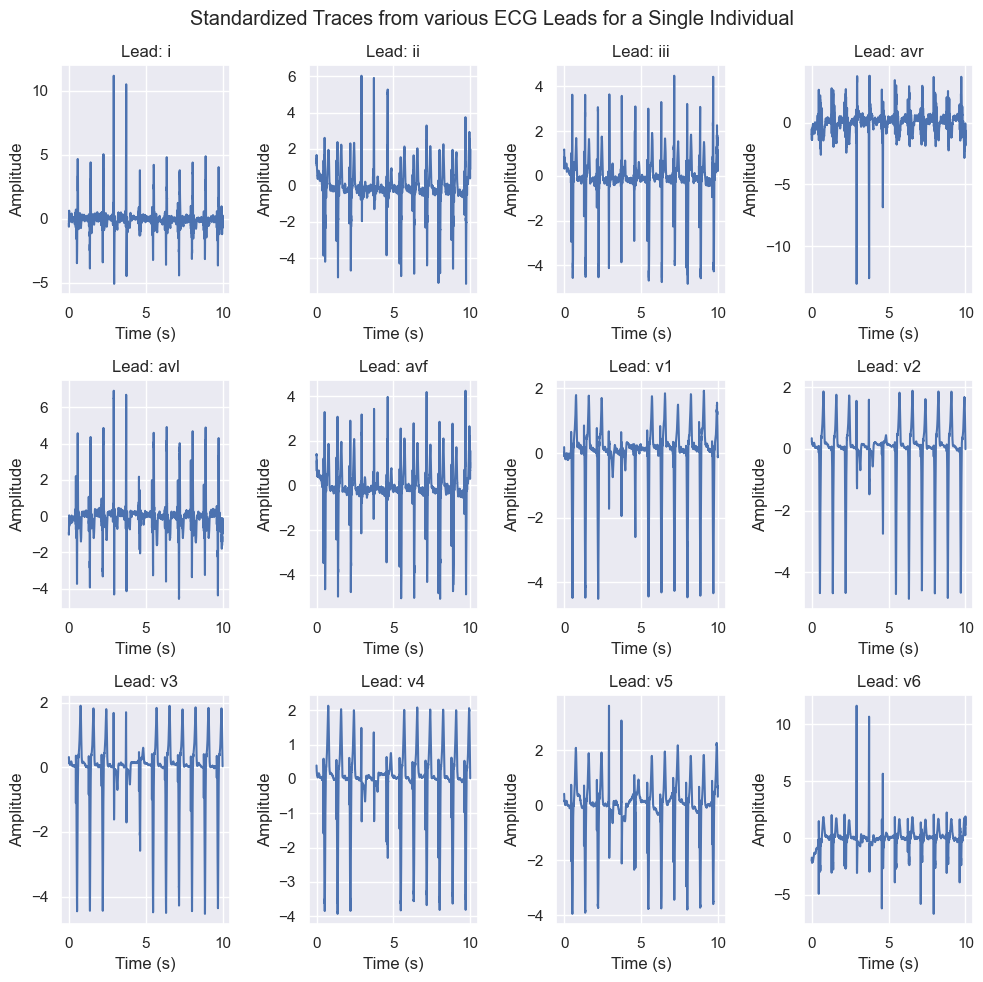

In [87]:
leads = df.columns
fig, ax = plt.subplots(3,4, figsize=(10,10))
ax = ax.flatten()

# plot leads
for i in range(len(leads)):
    lead_data = df[leads[i]]
    lead_data = (lead_data - np.mean(lead_data)) / np.std(lead_data)
    t = np.linspace(0, len(lead_data)/freq, len(lead_data))
    
    plt.sca(ax[i])
    plt.plot(t, lead_data)
    plt.title(f"Lead: {leads[i]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.suptitle("Standardized Traces from various ECG Leads for a Single Individual")
plt.tight_layout()

### Splitting Waves by Peaks
The researchers responsible for curating this dataset provided manually determined boundaries for the locations of each peak. Using these provided boundaries, we can use them to separate each heartbeat wave as individual observation.

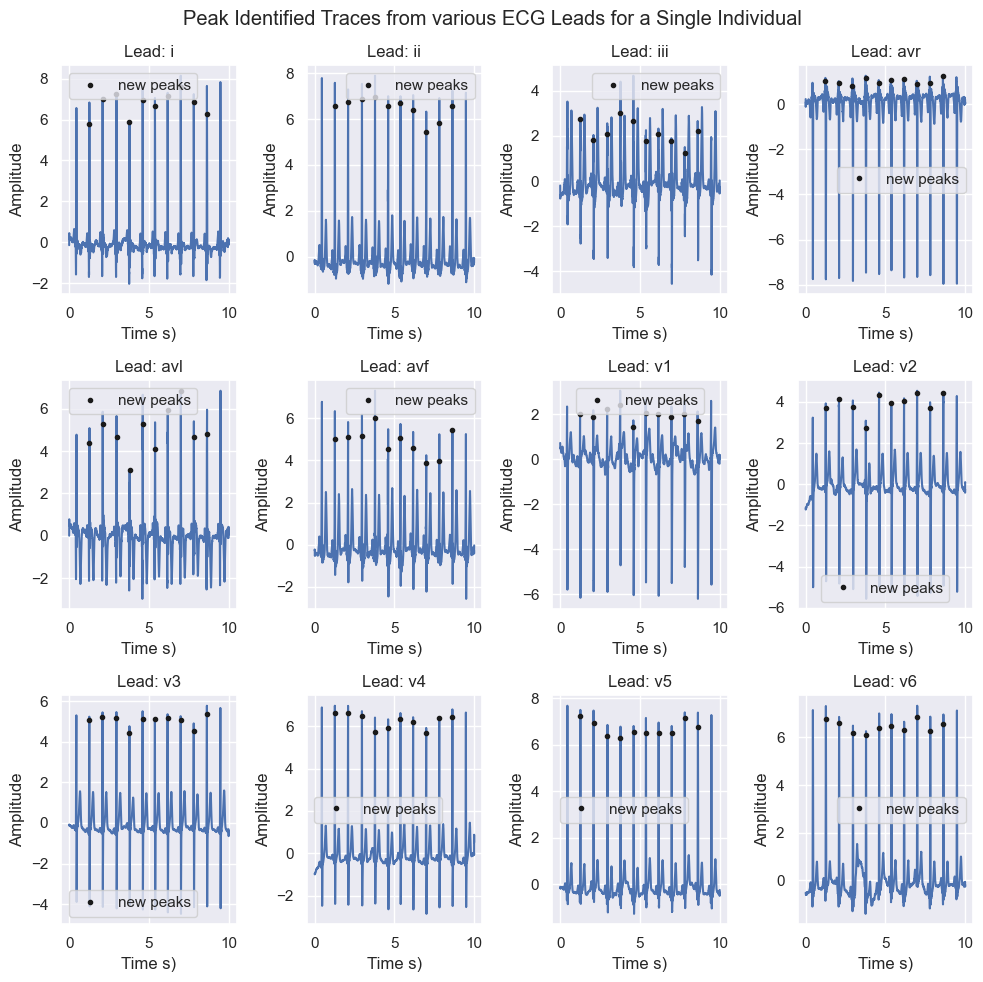

In [88]:
# plot each lead's data separately to get idea of distributions
freq = 500 # data all sampled at 500 Hz
leads = df.columns
id_in_use = demodf.ID[15]
fig, ax = plt.subplots(3,4, figsize=(10,10))
ax = ax.flatten()

# get data
record = wfdb.rdrecord(f'lobachevsky-university-electrocardiography-database-1.0.1/data/{id_in_use}')
df = record.to_dataframe()
peaks = None

# plot leads
for i in range(len(leads)):

    lead_data = df[leads[i]]
    lead_data = (lead_data - np.mean(lead_data)) / np.std(lead_data)
    t = np.linspace(0, len(lead_data)/freq, len(lead_data))
    
    ann = wfdb.io.rdann(f"lobachevsky-university-electrocardiography-database-1.0.1/data/{id_in_use}", extension=leads[i])
    
    peaks = ann.sample
    
    
    plt.sca(ax[i])
    # plt.plot(t[peaks], lead_data[peaks], '.r', label='og peaks', alpha=.5)
    
    peaks = peaks[1::9]
                                 
    plt.plot(t, lead_data)
    plt.plot(t[peaks], lead_data[peaks], '.k', label='new peaks')
    plt.title(f"Lead: {leads[i]}")
    plt.xlabel("Time s)")
    plt.ylabel("Amplitude")
    plt.legend()

plt.suptitle("Peak Identified Traces from various ECG Leads for a Single Individual")
plt.tight_layout()


In [89]:
filepath = "id_lead_peaks.pickle"
id_lead_peaks = None

# load dictionary if already created, otherwise create
try:
    with open(filepath, 'rb') as pkle:
        id_lead_peaks = pickle.load(pkle)
except FileNotFoundError:  

    id_lead_peaks = {}

    # get all peak locations for every lead
    for ID in demodf.ID:
        id_lead_peaks[ID] = {}
        peaks = None
        for lead in leads:
            ann = wfdb.io.rdann(f"lobachevsky-university-electrocardiography-database-1.0.1/data/{ID}", lead)
            peaks = ann.sample
            id_lead_peaks[ID][lead] = peaks



    with open(filepath, "wb") as pkle:
        pickle.dump(id_lead_peaks, pkle)

In [90]:
# split all peaks, keep sorted by id
all_data_path = "all_data.pickle"
all_ids_path = "all_ids.pickle" # maps waves to the ID of the person they came from
all_data = None
all_ids = None

try:
    # raise FileNotFoundError # force reload data
    with open(all_data_path, 'rb') as pkle:
        all_data = pickle.load(pkle)
    with open(all_ids_path, 'rb') as pkle:
        all_ids = pickle.load(pkle)
        
except FileNotFoundError:
    print("Formatting Data...")
    filepath = "id_lead_peaks.pickle"
    all_data = np.zeros((30000, len(leads), 2000)) # num_waves x leads x wavelength
    all_ids = np.zeros(30000)


    id_lead_peaks = None
    with open(filepath, 'rb') as pkle:
        id_lead_peaks = pickle.load(pkle)

    complete_max = 0 # keep track of maximum wavelength
    start_count = 0 # keep track of total number of unique waves (not counting duplicates across leads)

    for i in range(len(demodf.ID)):
        # get individual and their peak divisions
        ID = demodf.ID[i]
        record = wfdb.rdrecord(f'lobachevsky-university-electrocardiography-database-1.0.1/data/{ID}')
        df = record.to_dataframe().to_numpy()

        # split for each lead
        wavelengths = []
        for j in range(len(leads)):
            peaks = id_lead_peaks[ID][leads[j]]
            peaks = peaks[1::9]
            idx_slice = 0

            count_waves = start_count # restart count for each lead, as each lead belongs to same observation matrix
            
            # split for each wave
            for k in range(len(peaks)):

                # get wave
                wave = df[idx_slice:peaks[k], j]
                wavelengths.append(len(wave))

                # keep track of longest wave for later padding purposes
                if len(wave) > complete_max:
                    complete_max = len(wave)

                # add wave to full dataset
                all_data[count_waves, j, 0:len(wave)] = wave
                all_ids[count_waves] = ID


                # increment to properly add next wave
                idx_slice = peaks[k]
                count_waves += 1
        start_count = count_waves

    # drop all rows with no data & clip wavelength at longest wave seen
    all_data = all_data[0:start_count-1, :, 0:complete_max]
    all_ids = all_ids[0:start_count-1]

    with open(all_data_path, "wb") as pkle:
        pickle.dump(all_data, pkle)
    
    with open(all_ids_path, "wb") as pkle:
        pickle.dump(all_ids, pkle)
    

Formatting Data...


In [91]:
all_data.shape, all_ids.shape

((1734, 12, 1423), (1734,))

### Data Format

Each observation represents a single heartbeat wave and is a 12x1423 matrix, where the first dimension corresponds to one of the 12 standard ECG leads, and the second dimension to the length of the signal, sampled at 500 Hz. The length 1423 specifically is that of the longest single wave observed; all waves shorter than this are zero-padded at their right ends until they reach this length.

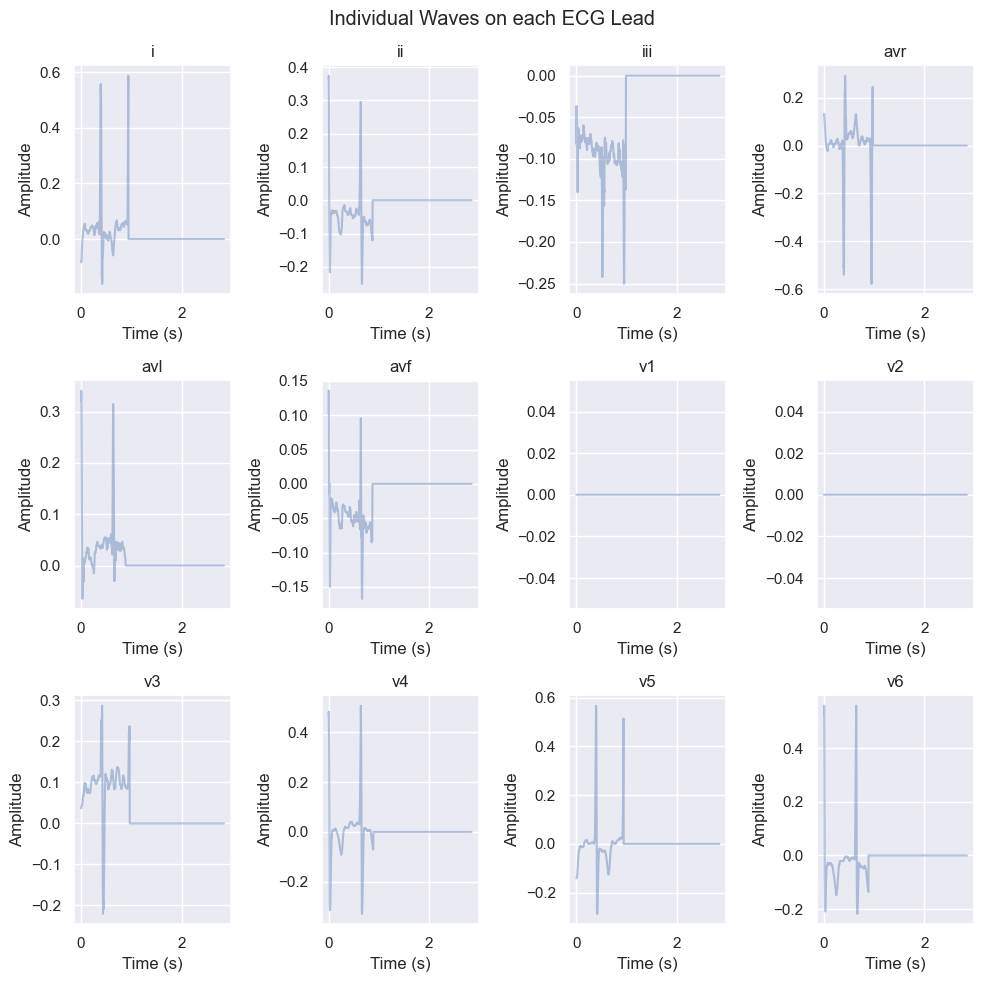

In [92]:
# plot example waves
freq = 500
fig, ax = plt.subplots(3,4, figsize=(10,10))
ax = ax.flatten()

t = np.linspace(0, all_data.shape[2]/freq, all_data.shape[2])

# take 10 people at random to plot for
indices = np.array([int(x) for x in range(all_data.shape[0])])
wave_idxs = np.random.choice(indices, size=1)

for i in range(len(leads)):
    plt.sca(ax[i])
    
    for idx in wave_idxs:
        plt.plot(t, all_data[idx, i, :], label=f'{idx}', alpha=.4)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"{leads[i]}")
plt.suptitle("Individual Waves on each ECG Lead")
plt.tight_layout()

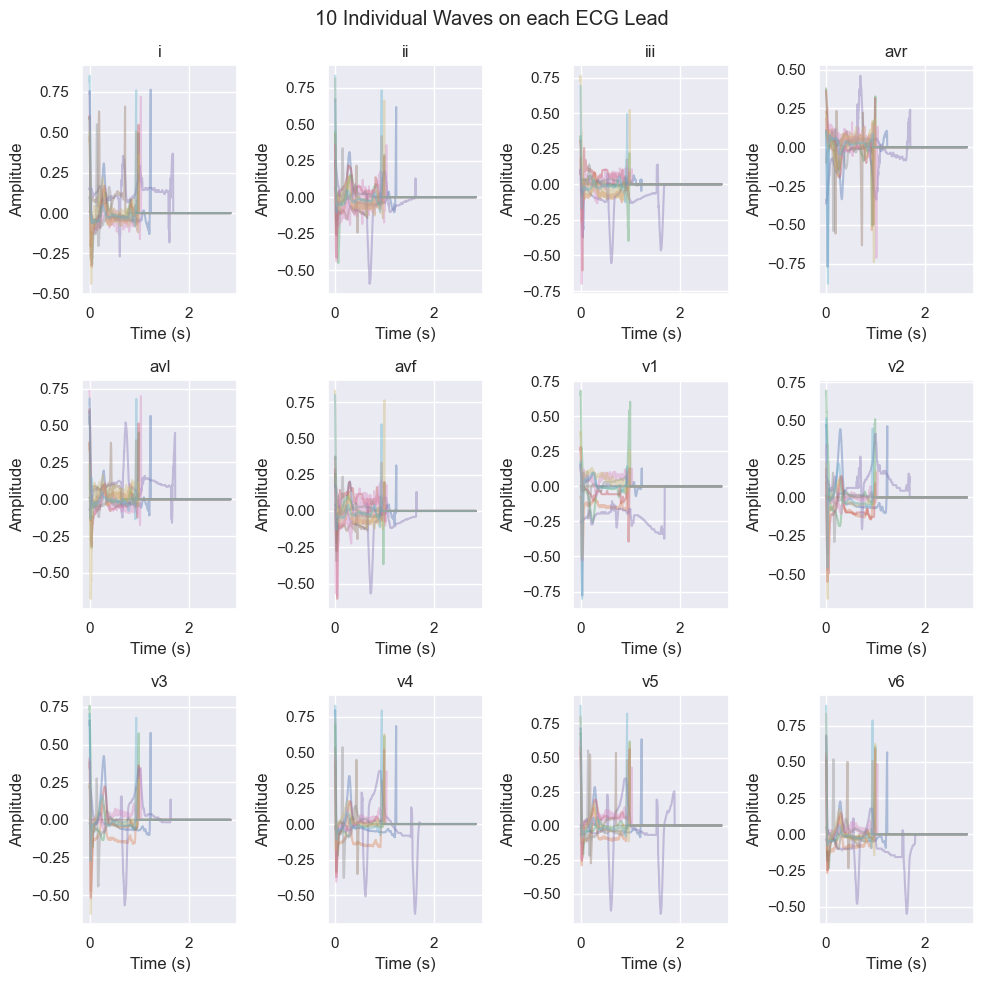

In [93]:
# plot example waves
fig, ax = plt.subplots(3,4, figsize=(10,10))
ax = ax.flatten()

t = np.linspace(0, all_data.shape[2]/freq, all_data.shape[2])

# take 10 people at random to plot for
indices = np.array([int(x) for x in range(all_data.shape[0])])
wave_idxs = np.random.choice(indices, size=10)

for i in range(len(leads)):
    plt.sca(ax[i])
    
    for idx in wave_idxs:
        plt.plot(t, all_data[idx, i, :], label=f'{idx}', alpha=.4)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"{leads[i]}")
plt.suptitle("10 Individual Waves on each ECG Lead")
plt.tight_layout()

<a id="1.3"></a>
## 1.3 Oversampling
For each response variable column as encoded in section 1.1, there is class imbalance between the diseased (1) and healthy (0) state. We will use simple oversampling (randomly including extra copies of the smaller class) to combat this; while this does run the risk of us overfitting to our specific dataset and allowing select individuals to have a larger impact on the model, we've chosen this method due to problems encountered attempting to merge our data with data from other sources. Since each response variable will have a separate model, each will have slightly different oversampling needs as well, leading to datasets of slightly different composition being passed in for each model.
 

In [94]:
# do simple oversampling 

def oversampler(demodf_enc, resp, all_data, all_ids):

    new_data = []
    new_ids = []

    # find number of existing observations for each class
    id_ls = demodf_enc.loc[demodf_enc[resp]==0]['ID'].unique()

    class0_ls = []
    [class0_ls.append(patient_id) for patient_id in all_ids if patient_id in id_ls] # count number of waves for class 0
    class0 = len(class0_ls)
    class1 = all_data.shape[0] - class0

    # find difference between class counts
    offset = class1 - class0

    # subset patients to oversample for
    indicator = None
    if offset < 0: 
        indicator = 1
    else:
        indicator = 0
        
    df_subset = demodf_enc.loc[demodf_enc[resp]==indicator]
    patient_ids = df_subset['ID'].unique()

    # add new observations
    for j in range(np.abs(offset)):

        # randomly sample patient ID
        idx = np.random.choice(patient_ids)

        # add data for patient into new_data list
        idx_slice = None

        # find index of single ECG wave observation to add
        for w in range(len(all_ids)):
            if all_ids[w] == idx_slice:
                idx_slice = w
                break

        to_add = np.expand_dims(all_data[w], axis=0)
        new_data.append(to_add)
        new_ids.append(np.array([idx]))
    # add new data
    all_data_n = np.concatenate((all_data, *new_data))
    all_ids_n = np.concatenate((all_ids, *new_ids))
    return all_data_n, all_ids_n

def id_disease_map(resp_cols, demodf_enc):
    full_map = {}
    
    # create subdictionary for each disease
    for resp in resp_cols:
        full_map[resp] = {}
        
        # create id to disease map
        for patient_id in demodf_enc["ID"].unique():
            full_map[resp][patient_id] = demodf_enc.loc[demodf_enc['ID']==patient_id][resp].to_numpy()[0]
    return full_map

def pickle_saver(item, filepath):
    with open(filepath, "wb") as pkle:
        pickle.dump(item, pkle)
    return
        
def pickle_loader(filepath):
    with open(filepath, "rb") as pkle:
        item = pickle.load(pkle)
    return item

def class_counter(resp_ids, resp_id_disease_map):
    
    # find number of existing observations for each class
    class0_ls = [patient_id for patient_id in resp_ids if resp_id_disease_map[resp][patient_id]==0] # count number of waves for class 0
    class0 = len(class0_ls)
    class1 = len(resp_ids) - class0
    return class0, class1
        

In [95]:
# columns to be predicted on
resp_cols = ['Conduction abnormalities','Extrasystolies','Hypertrophies','Cardiac pacing','Ischemia','Non-specific repolarization abnormalities']
resp_id_disease_map = id_disease_map(resp_cols, demodf_enc)

full_data = {}
full_ids = {}
try:
    raise FileNotFoundError
    for resp in resp_cols:
        # collect data for response
        resp_xdata = pickle_loader(f"pickle_data/{resp}_xdata.pickle")
        resp_ydata = pickle_loader(f"pickle_data/{resp}_ydata.pickle")
        resp_ids = pickle_loader(f"pickle_data/{resp}_ids.pickle")
        
        # aggregate data for response
        full_data[resp] = (resp_xdata, resp_ydata)
        full_ids[resp] = resp_ids
        
    print("Loaded Data!")
        
except FileNotFoundError:
    
    for resp in resp_cols:
        np.random.seed(109)

        # get balanced x data for specific class
        resp_xdata, resp_ids = oversampler(demodf_enc, resp, all_data, all_ids)

        # get y data for specific class
        resp_ydata = np.array([resp_id_disease_map[resp][patient_id] for patient_id in resp_ids])

        # save all data
        pickle_saver(resp_xdata, f"pickle_data/{resp}_xdata.pickle")
        pickle_saver(resp_ydata, f"pickle_data/{resp}_ydata.pickle")
        pickle_saver(resp_ids, f"pickle_data/{resp}_ids.pickle")
        print(f"finished for {resp}")
        
        # aggregate data for response
        full_data[resp] = (resp_xdata, resp_ydata)
        full_ids[resp] = resp_ids
        

    

finished for Conduction abnormalities
finished for Extrasystolies
finished for Hypertrophies
finished for Cardiac pacing
finished for Ischemia
finished for Non-specific repolarization abnormalities


In [96]:
for resp in resp_cols:
    xdata, ydata = full_data[resp]
    resp_ids = full_ids[resp]
    
    class0, class1 = class_counter(resp_ids, resp_id_disease_map)
    
    print(f"{resp}:\n\t0: {class0}, 1: {class1}")

Conduction abnormalities:
	0: 1187, 1: 1187
Extrasystolies:
	0: 1617, 1: 1617
Hypertrophies:
	0: 1255, 1: 1255
Cardiac pacing:
	0: 1676, 1: 1676
Ischemia:
	0: 1296, 1: 1296
Non-specific repolarization abnormalities:
	0: 1319, 1: 1319


<a id="2"></a>
# 2. Data Exploration

<a id="2.1"></a>
## <div style="background-color:orange"> 2.1 Patient Demographic EDA (credit to George Popoola)</div>

Text(0.5, 1.0, 'Histogram of Patient Ages (Grouped by Gender)')

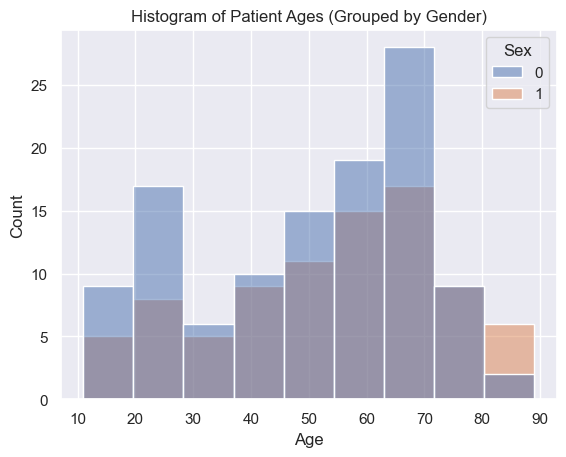

In [27]:
ax = sns.histplot(data=demodf_enc, x='Age', hue='Sex')
plt.sca(ax)
plt.title("Histogram of Patient Ages (Grouped by Gender)")

- Relatively normal age distribution for both genders, seem to have similar center and standard deviation as well

Reminder: `Male==0, Female==1`

In [28]:
print("Patient Gender Counts:")
demodf_enc['Sex'].value_counts()

Patient Gender Counts:


0    115
1     85
Name: Sex, dtype: int64

- Slight bias of male patients over female patients

Text(0.5, 1.0, 'Correlation between Age and Heart Abnormalities')

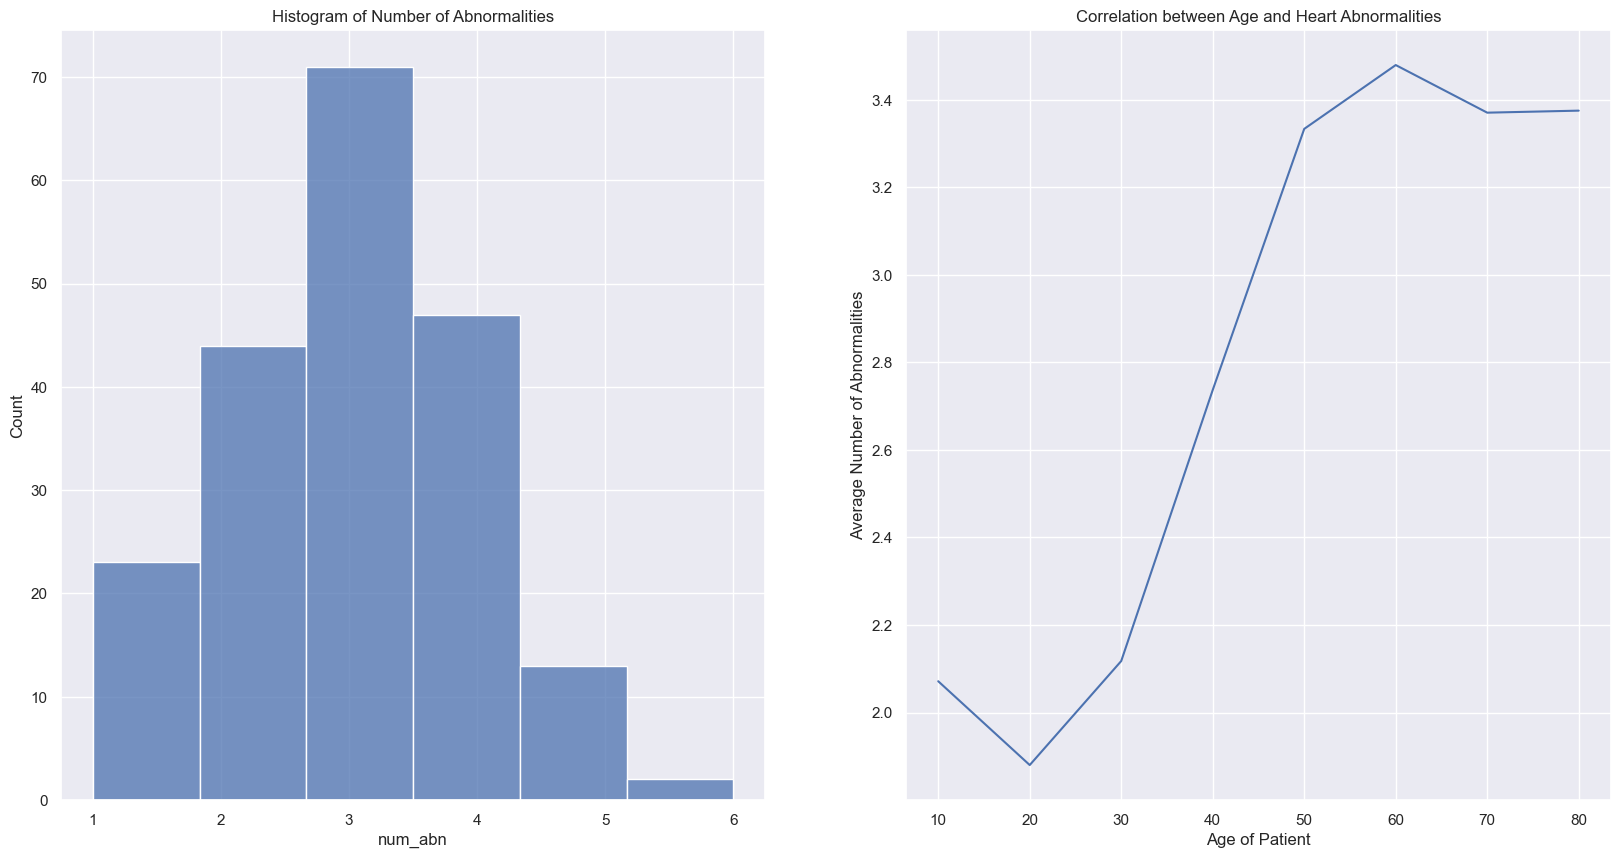

In [29]:
#Exploration of contribution of demographic features to heart disorder diagnoses

# Examine correlation between age and heart issues (for these purposes, we will treat horizontal and vertical electric axes 
# on the heart as abnormalities)
age_corr_df = demodf_enc.sort_values('Age')

# count all abnormalities
demodf_abn = demodf_enc.drop(['Sex', 'Age', 'ID'], axis=1)
age_corr_df['num_abn'] = demodf_abn.sum(axis=1)

# get age range averages
ages = np.linspace(10, 90, 9)
avg_abn = []
for age in ages:
    # get mean # of abnormalities for given age
    buff = age_corr_df.loc[(age_corr_df['Age']>=age) & (age_corr_df['Age']<age+10)]
    avg_abn.append(np.mean(buff['num_abn']))
    
age_corr_df['avg_num'] = age_corr_df['num_abn'] / age_corr_df['Age']

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

plt.sca(axs[0])
sns.histplot(data=age_corr_df, x='num_abn', bins=6)
plt.title("Histogram of Number of Abnormalities")

plt.sca(axs[1])
plt.plot(ages, avg_abn)

plt.xlabel('Age of Patient')
plt.ylabel('Average Number of Abnormalities')
plt.title("Correlation between Age and Heart Abnormalities")



# age_corr_df.head()


- the number of abnormalities per patient is normally distributed around a center of between 3-4, meaning most patients have more than one problem simultaneously.
- The average number of abnormalities seems to increase as age increases, which makes sense

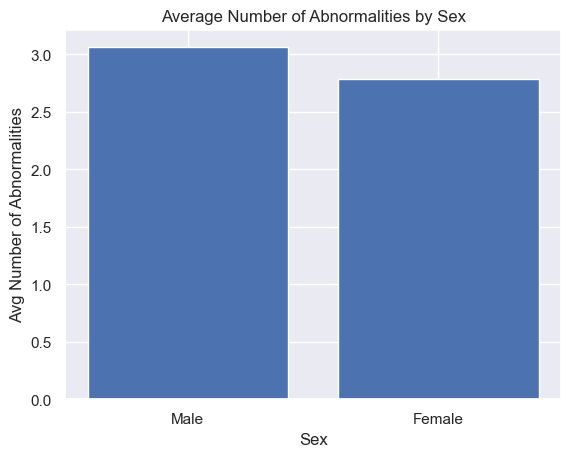

In [30]:
#Correlation between sex and heart abnormalities

genders = [0, 1]
avg_gen_abn = []

for gender in genders:
    buff = age_corr_df.loc[age_corr_df['Sex']==gender]
    avg_gen_abn.append(np.mean(buff['num_abn']))
    
plt.bar(genders, avg_gen_abn)
plt.title("Average Number of Abnormalities by Sex")
plt.xlabel("Sex")
plt.ylabel("Avg Number of Abnormalities")
plt.xticks(ticks=[0,1], labels=['Male', 'Female']);

- On average women have more abnormalities. This occurs despite the female and male populations being shown to be relatively similar in most regards (distributions of size, age, etc.), suggesting intrinsic differences in heart function between males and females 

<a id="2.2"></a>
## 2.2 ECG Trace EDA

In [97]:
# compute exploratory metrics
# compute bpms
gender_bpms = {0:[], 1:[]}

for i in range(all_data.shape[0]):
    # find sex of patient
    sex = demodf_enc.loc[demodf_enc.ID==all_ids[i]]['Sex'].to_numpy().flatten()[0]
    
    idx = 0
    
    # find where actual data stops
    for k in range(2, all_data.shape[2]):
        if all_data[i,0,k:-1].any() == False:
            idx = k-1
            break

    # compute bpm from length of wave
    gender_bpms[sex].append(k * 60/freq)
    

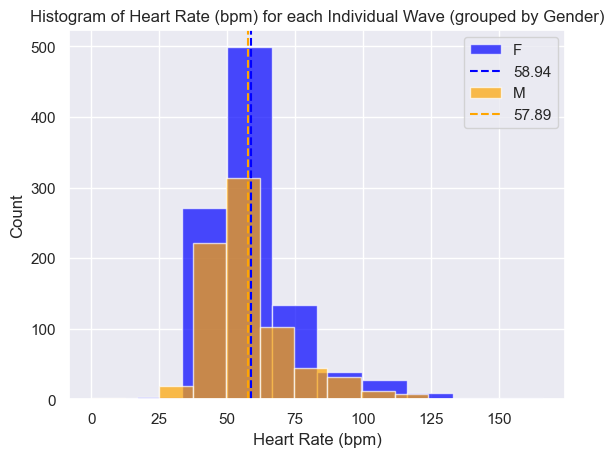

In [98]:
plt.hist(gender_bpms[0], label='F', color='blue', alpha=.7)
plt.axvline(x=np.mean(gender_bpms[0]), color='blue', ls='--', label=f'{np.mean(gender_bpms[0]):.2f}')
plt.hist(gender_bpms[1], label='M', color='orange', alpha=.7)
plt.axvline(x=np.mean(gender_bpms[1]), color='orange', ls='--', label=f"{np.mean(gender_bpms[1]):.2f}")
plt.title("Histogram of Heart Rate (bpm) for each Individual Wave (grouped by Gender)")
plt.xlabel("Heart Rate (bpm)")
plt.ylabel("Count")
plt.legend();

In [99]:
# compute exploratory metrics
# compute bpms
peak_heights = {lead:{0:[], 1:[]} for lead in leads}

for i in range(all_data.shape[0]):
    # find sex of patient
    sex = demodf_enc.loc[demodf_enc.ID==all_ids[i]]['Sex'].to_numpy().flatten()[0]
    
    for j in range(len(leads)):
        peak_heights[leads[j]][sex].append(np.max(all_data[i,j,:]))
        
        

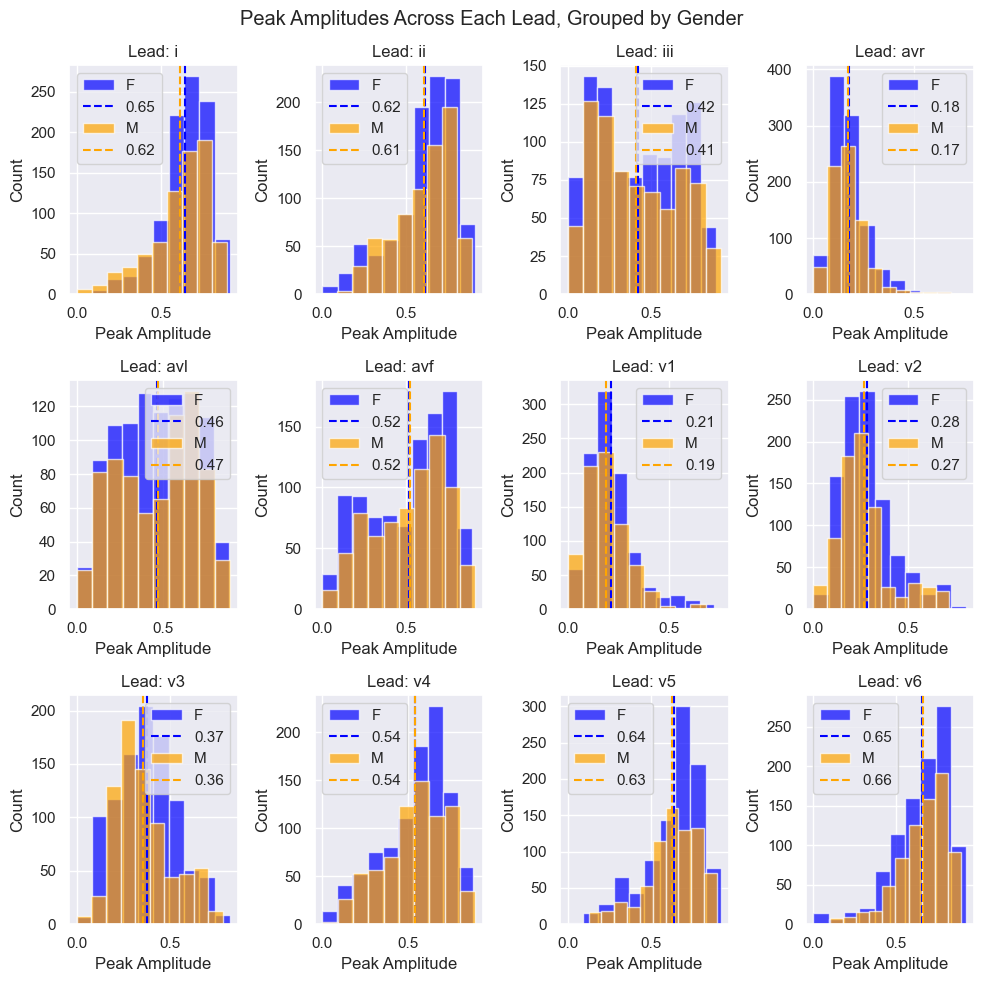

In [100]:
fig, ax = plt.subplots(3,4, figsize=(10,10))
ax = ax.flatten()
for i in range(len(leads)):
    plt.sca(ax[i])
    plt.hist(peak_heights[leads[i]][0], label='F', color='blue', alpha=.7)
    plt.axvline(x=np.mean(peak_heights[leads[i]][0]), color='blue', ls='--', label=f'{np.mean(peak_heights[leads[i]][0]):.2f}')
    plt.hist(peak_heights[leads[i]][1], label='M', color='orange', alpha=.7)
    plt.axvline(x=np.mean(peak_heights[leads[i]][1]), color='orange', ls='--', label=f'{np.mean(peak_heights[leads[i]][1]):.2f}')
    plt.title(f"Lead: {leads[i]}")
    plt.xlabel("Peak Amplitude")
    plt.ylabel("Count")
    plt.legend();
plt.suptitle("Peak Amplitudes Across Each Lead, Grouped by Gender")
plt.tight_layout()

In [35]:
responses = [demodf_enc.columns[i] for i in range(3, len(demodf_enc.columns))]

response_bpms = {col:[] for col in responses}
response_ids = {col:demodf_enc.loc[demodf_enc[col]==1]['ID'].to_numpy().flatten() for col in responses}

for i in range(all_data.shape[0]):
    # find sex of patient
    
    idx = 0
    
    # find where actual data stops
    for k in range(2, all_data.shape[2]):
        if all_data[i,0,k:-1].any() == False:
            idx = k-1
            break

    # compute bpm from length of wave
    bpm = k * 60/freq
    for response in responses:
        if all_ids[i] in response_ids[response]:
            response_bpms[response].append(bpm)
        

0:Rhythms
1:Conduction abnormalities
2:Extrasystolies
3:Hypertrophies
4:Cardiac pacing
5:Ischemia
6:Non-specific repolarization abnormalities
7:Other states
8:Electric axis of the heart_Electric axis of the heart: horizontal
9:Electric axis of the heart_Electric axis of the heart: left axis deviation
10:Electric axis of the heart_Electric axis of the heart: normal
11:Electric axis of the heart_Electric axis of the heart: right axis deviation
12:Electric axis of the heart_Electric axis of the heart: vertical


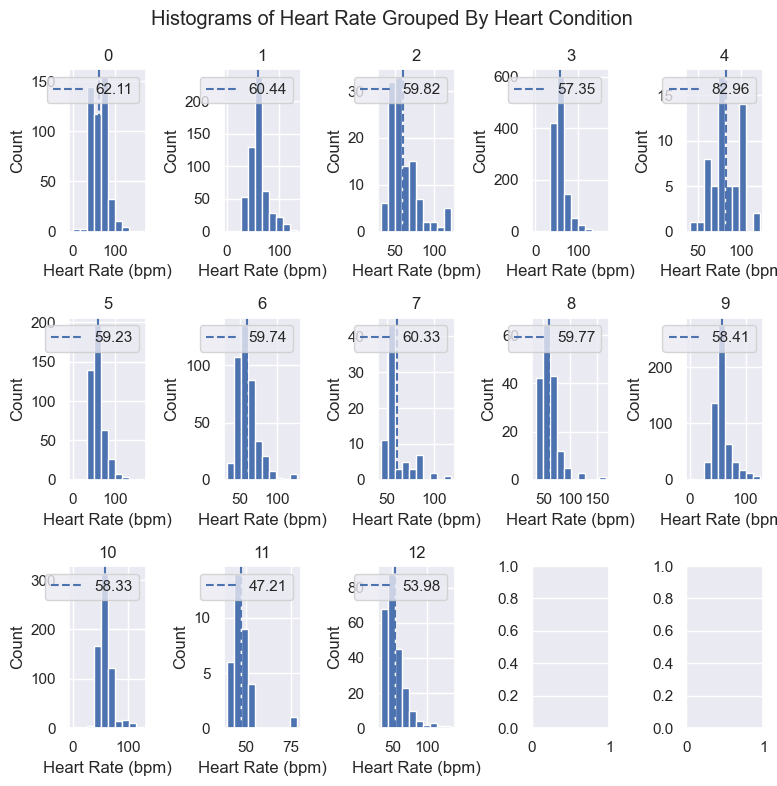

In [36]:
fig, ax = plt.subplots(3,5, figsize=(8,8))
ax = ax.flatten()

legend_help = {print(f"{i}:{responses[i]}") for i in range(len(responses))}

for i in range(len(responses)):
    plt.sca(ax[i])
    
    plt.hist(response_bpms[responses[i]])
    plt.axvline(np.mean(response_bpms[responses[i]]), label=f'{np.mean(response_bpms[responses[i]]):.2f}', ls='--')
    plt.title(i)
    plt.xlabel("Heart Rate (bpm)")
    plt.ylabel("Count")
    plt.legend()
plt.suptitle("Histograms of Heart Rate Grouped By Heart Condition")
plt.tight_layout()


<a id="2.3"></a>
## <div style="background-color:orange"> 2.3 EDA of Unencoded Demographic Information (credit to Brian Ndzuki)</div>

For brevity, feel free to skip to section [3](#3), as rest of section 2 was done as an intermediate step in the project and is no longer directly relevant.

In [38]:
df = pd.read_csv('lobachevsky-university-electrocardiography-database-1.0.1/ludb.csv')
df.head() 

ID  Sex   Age            Rhythms  \
0   1  F\n  51\n  Sinus bradycardia   
1   2  M\n  64\n       Sinus rhythm   
2   3  M\n  53\n       Sinus rhythm   
3   4  M\n  56\n       Sinus rhythm   
4   5  M\n  61\n       Sinus rhythm   

                        Electric axis of the heart  \
0  Electric axis of the heart: left axis deviation   
1               Electric axis of the heart: normal   
2             Electric axis of the heart: vertical   
3  Electric axis of the heart: left axis deviation   
4           Electric axis of the heart: horizontal   

               Conduction abnormalities Extrasystolies  \
0                                   NaN            NaN   
1                                   NaN            NaN   
2                                   NaN            NaN   
3  Incomplete right bundle branch block            NaN   
4                                   NaN            NaN   

                                       Hypertrophies Cardiac pacing  \
0  Left ventricular overload\nLeft ventricular hy...            NaN   
1  Left atrial hypertrophy\nLeft ventricular hype...            NaN   
2  Left atrial hypertrophy\nLeft ventricular hype...            NaN   
3  Left atrial hypertrophy\nLeft ventricular hype...            NaN   
4                            Left atrial hypertrophy            NaN   

                                            Ischemia  \
0                                                NaN   
1                                                NaN   
2    Ischemia: inferior wall\nIschemia: lateral wall   
3  Ischemia: inferior wall\nScar formation: infer...   
4                                                NaN   

           Non-specific repolarization abnormalities Other states  
0  Non-specific repolarization abnormalities: pos...          NaN  
1  Non-specific repolarization abnormalities: pos...          NaN  
2                                                NaN          NaN  
3                                                NaN          NaN  
4  Non-specific repolarization abnormalities: inf...          NaN

In [39]:
df.isna().sum()

ID                                             0
Sex                                            0
Age                                            0
Rhythms                                        0
Electric axis of the heart                    10
Conduction abnormalities                     134
Extrasystolies                               186
Hypertrophies                                 58
Cardiac pacing                               190
Ischemia                                     149
Non-specific repolarization abnormalities    151
Other states                                 191
dtype: int64

In [40]:
df['Sex'] = df['Sex'].apply(lambda x: x.strip())
df['Age'] = df['Age'].apply(lambda x: x.strip())

In [41]:
df.head()

ID Sex Age            Rhythms  \
0   1   F  51  Sinus bradycardia   
1   2   M  64       Sinus rhythm   
2   3   M  53       Sinus rhythm   
3   4   M  56       Sinus rhythm   
4   5   M  61       Sinus rhythm   

                        Electric axis of the heart  \
0  Electric axis of the heart: left axis deviation   
1               Electric axis of the heart: normal   
2             Electric axis of the heart: vertical   
3  Electric axis of the heart: left axis deviation   
4           Electric axis of the heart: horizontal   

               Conduction abnormalities Extrasystolies  \
0                                   NaN            NaN   
1                                   NaN            NaN   
2                                   NaN            NaN   
3  Incomplete right bundle branch block            NaN   
4                                   NaN            NaN   

                                       Hypertrophies Cardiac pacing  \
0  Left ventricular overload\nLeft ventricular hy...            NaN   
1  Left atrial hypertrophy\nLeft ventricular hype...            NaN   
2  Left atrial hypertrophy\nLeft ventricular hype...            NaN   
3  Left atrial hypertrophy\nLeft ventricular hype...            NaN   
4                            Left atrial hypertrophy            NaN   

                                            Ischemia  \
0                                                NaN   
1                                                NaN   
2    Ischemia: inferior wall\nIschemia: lateral wall   
3  Ischemia: inferior wall\nScar formation: infer...   
4                                                NaN   

           Non-specific repolarization abnormalities Other states  
0  Non-specific repolarization abnormalities: pos...          NaN  
1  Non-specific repolarization abnormalities: pos...          NaN  
2                                                NaN          NaN  
3                                                NaN          NaN  
4  Non-specific repolarization abnormalities: inf...          NaN

In [42]:
df.dtypes

ID                                            int64
Sex                                          object
Age                                          object
Rhythms                                      object
Electric axis of the heart                   object
Conduction abnormalities                     object
Extrasystolies                               object
Hypertrophies                                object
Cardiac pacing                               object
Ischemia                                     object
Non-specific repolarization abnormalities    object
Other states                                 object
dtype: object

### Data Visualization

#### 1. Looking at Heart Rhythms

In [43]:
np.unique(df.Rhythms.values)

array(['Atrial fibrillation', 'Atrial fibrillation\nAberrant conduction',
       'Atrial flutter, typical', 'Irregular sinus rhythm',
       'Sinus arrhythmia', 'Sinus arrhythmia\nWandering atrial pacemaker',
       'Sinus bradycardia',
       'Sinus bradycardia\nWandering atrial pacemaker', 'Sinus rhythm',
       'Sinus rhythm\nWandering atrial pacemaker', 'Sinus tachycardia'],
      dtype=object)

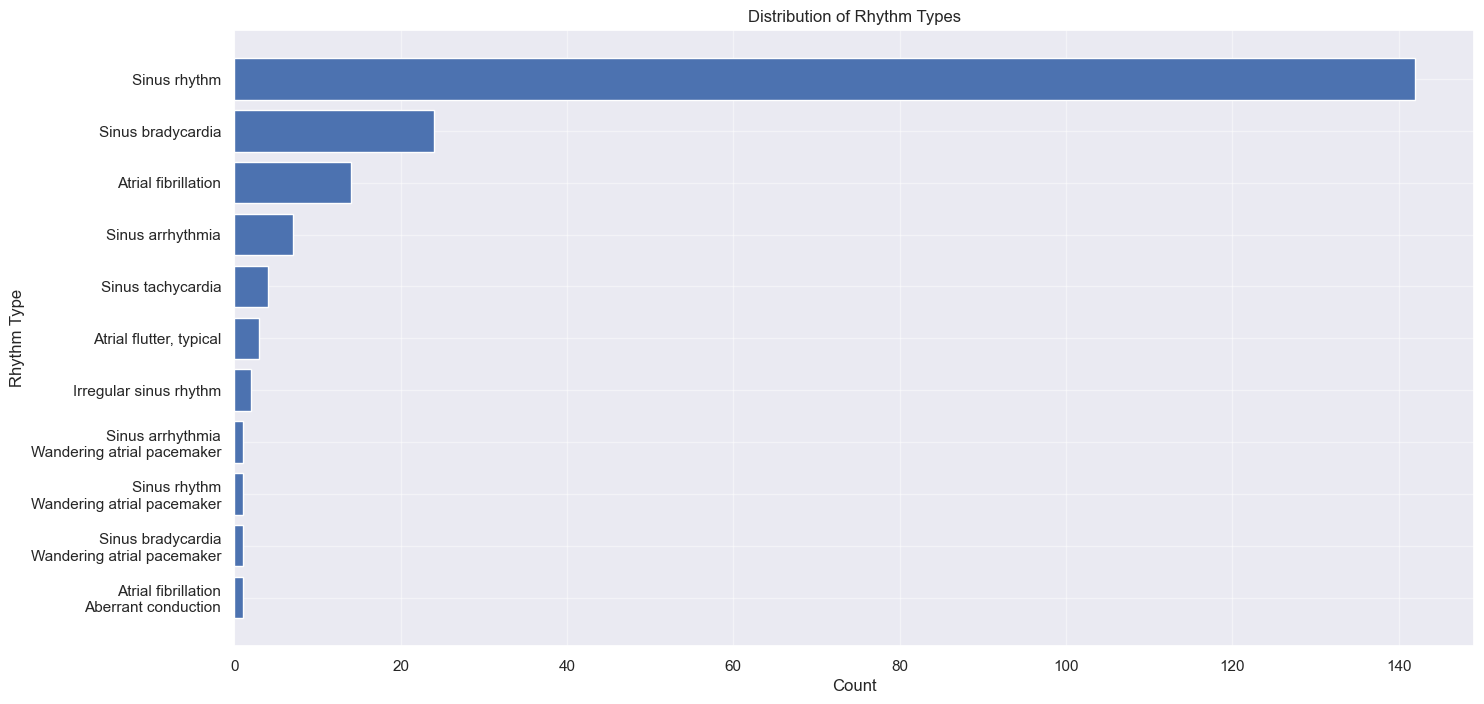

In [44]:
# Create a bar plot of the Rhythms column
fig, ax = plt.subplots(figsize=(16,8))
rhythms_counts = df['Rhythms'].value_counts().sort_values(ascending=True)
ax.barh(rhythms_counts.index, rhythms_counts.values)
plt.ylabel('Rhythm Type')
plt.xlabel('Count')
plt.title('Distribution of Rhythm Types')
plt.grid(':', alpha=0.45)
plt.show()

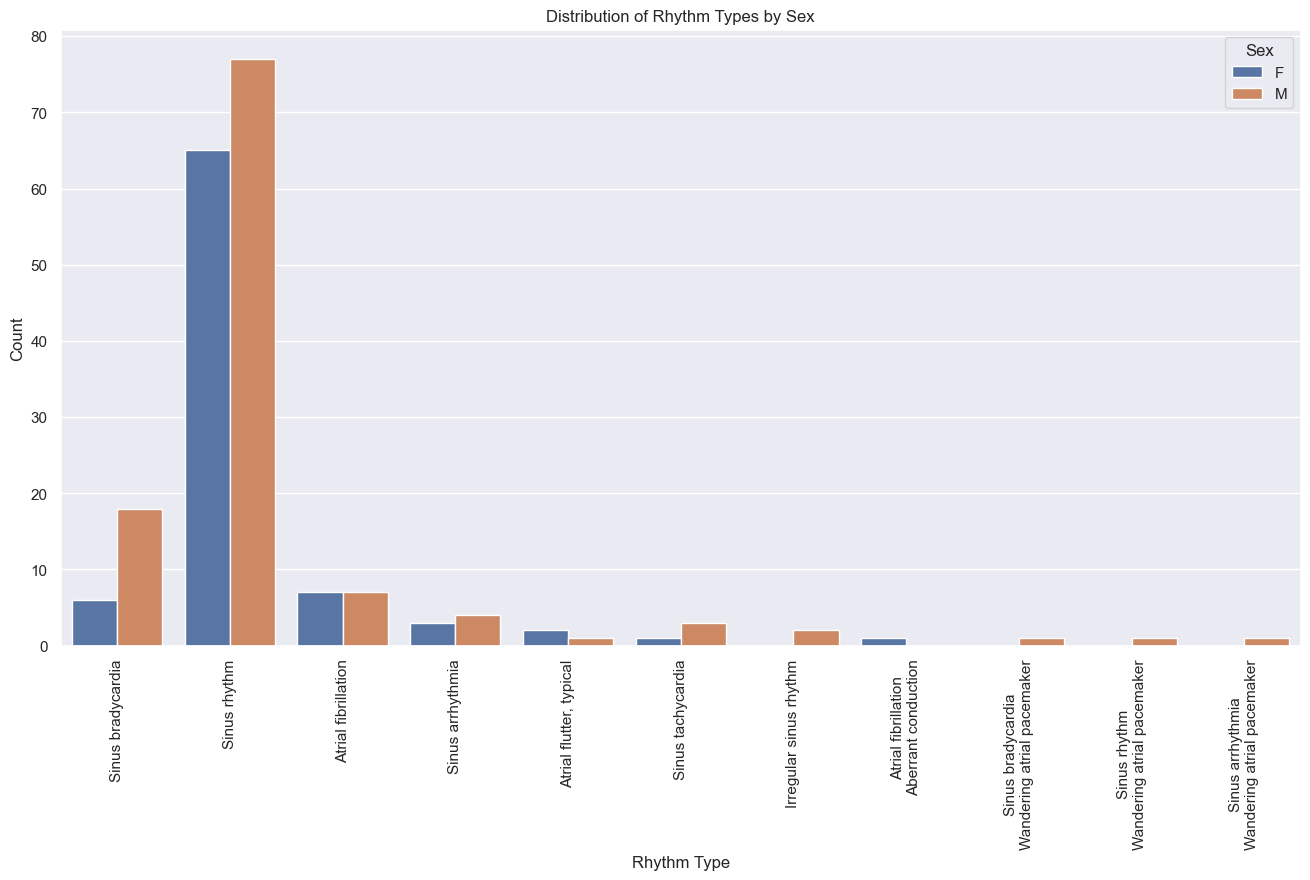

In [45]:
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(x='Rhythms', hue='Sex', data=df)
plt.xlabel('Rhythm Type')
plt.ylabel('Count')
plt.title('Distribution of Rhythm Types by Sex')
plt.xticks(rotation=90)
plt.show()

#### 2. Looking at Conduction Abnormalities

In [46]:
df['Conduction abnormalities'].isna().sum()

134

In [47]:
df['Conduction abnormalities'] = df['Conduction abnormalities'].fillna('Abnormality Absent')

In [48]:
df['Conduction abnormalities'].isna().sum()

0

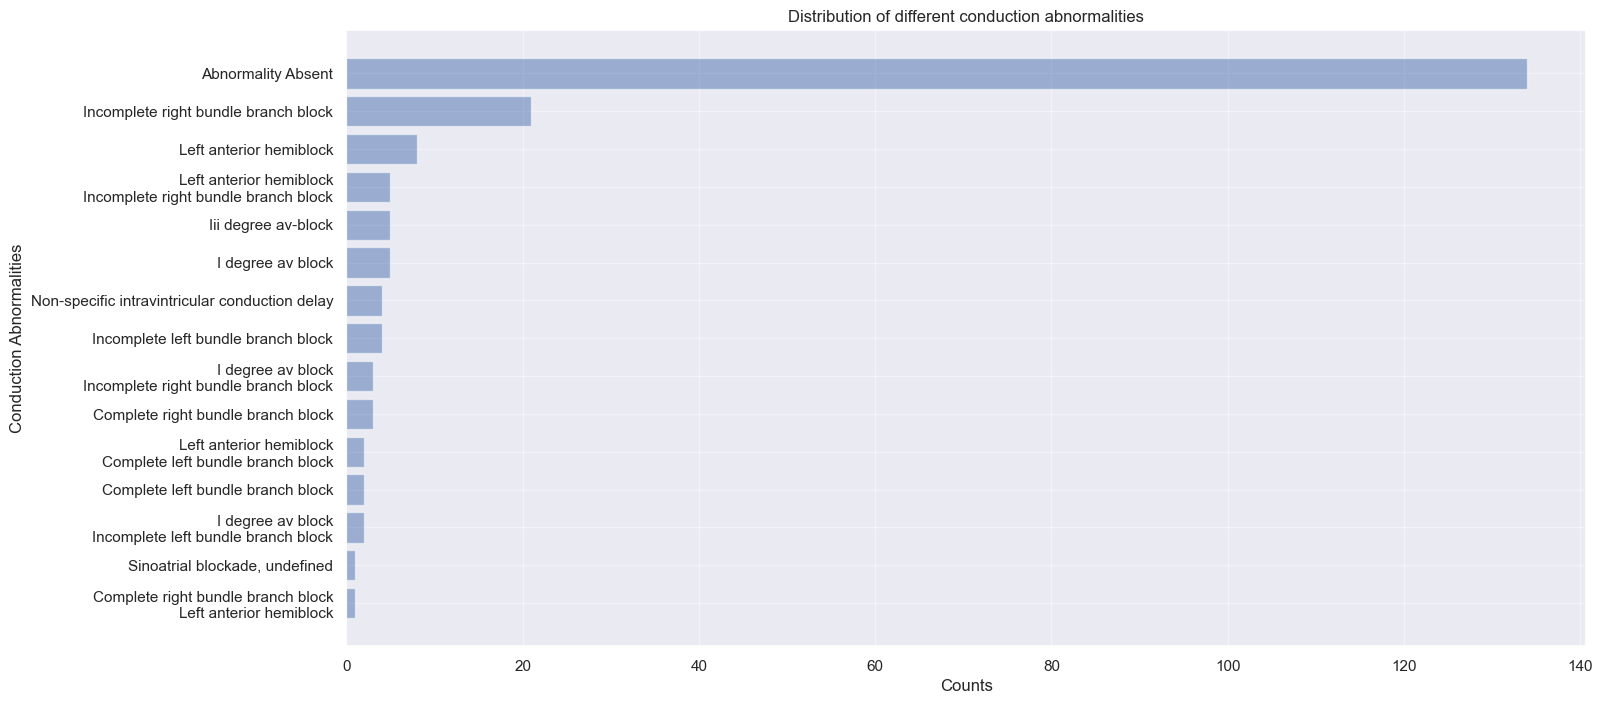

In [49]:
fig, ax = plt.subplots(figsize=(16,8))
rhythms_counts = df['Conduction abnormalities'].value_counts().sort_values(ascending=True)
ax.barh(rhythms_counts.index, rhythms_counts.values, alpha=0.5)
plt.xlabel('Counts')
plt.ylabel('Conduction Abnormalities')
plt.title('Distribution of different conduction abnormalities')
plt.grid(':', alpha=0.45)
plt.xticks()
plt.show()

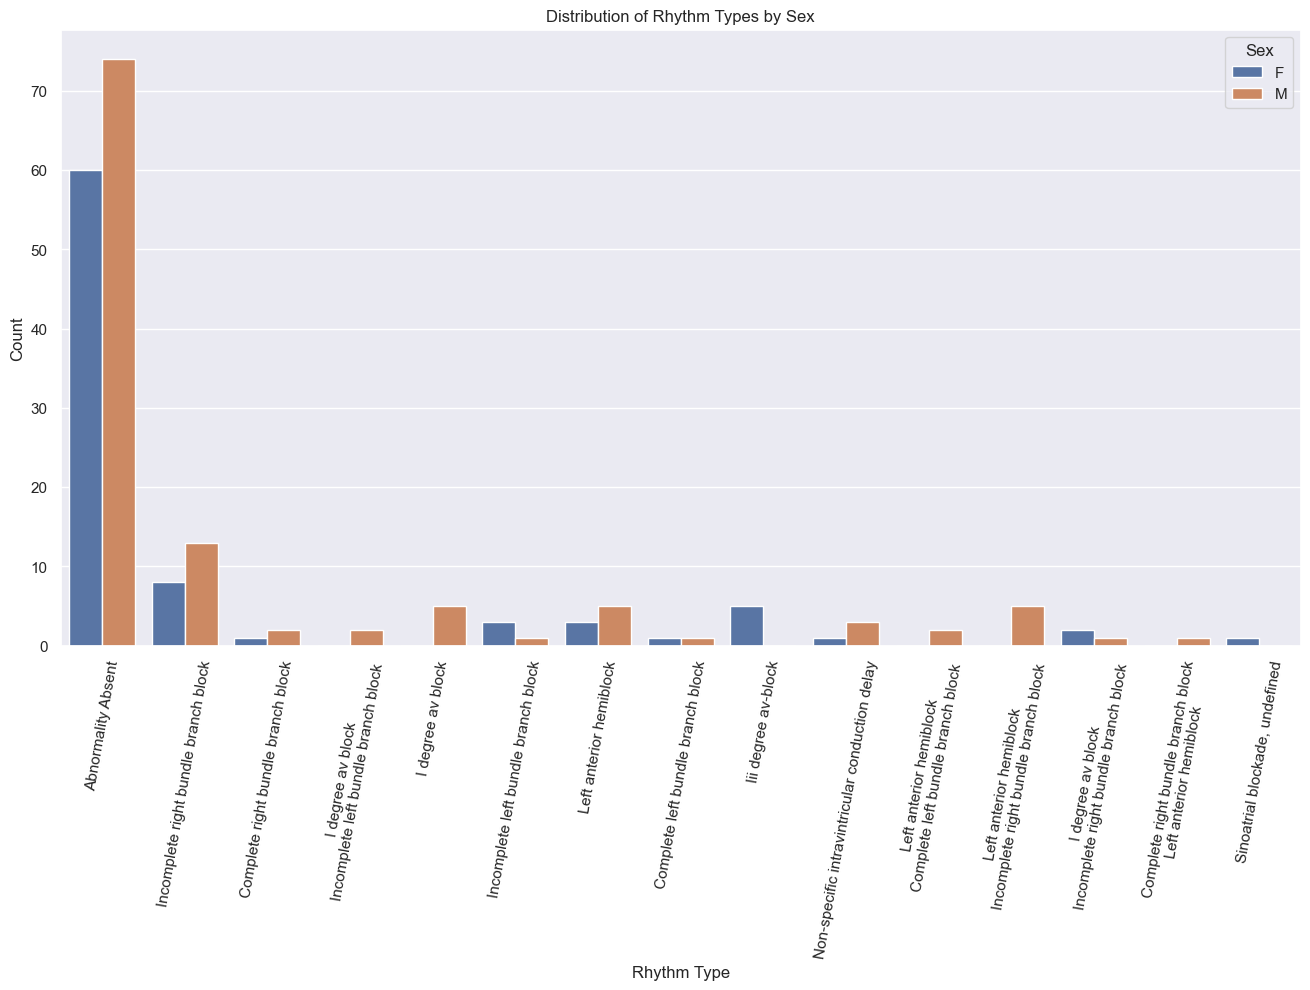

In [50]:
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(x='Conduction abnormalities', hue='Sex', data=df)
plt.xlabel('Rhythm Type')
plt.ylabel('Count')
plt.title('Distribution of Rhythm Types by Sex')
plt.xticks(rotation=80)
plt.show()

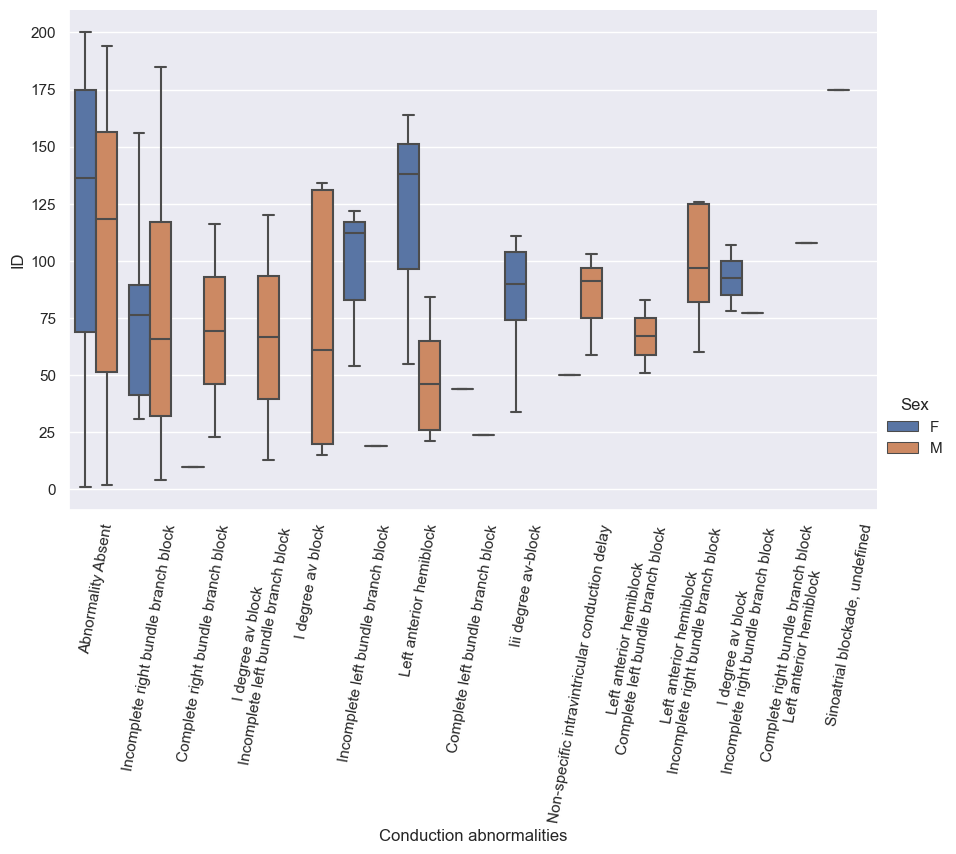

In [51]:
sns.catplot(x='Conduction abnormalities', y='ID', hue='Sex', kind='box', data=df, height=6, aspect=1.5)
plt.xticks(rotation=80)
plt.show()

#### 3. Looking at Non-Specific Repolarization Abnormalities

In [52]:
def clean_Repolarization_abnormality(row):
    value = row['Non-specific repolarization abnormalities']
    if pd.isnull(value):
        return value
    else:
        return value.split(':')[1]
df['Non-specific repolarization abnormalities'] = df['Non-specific repolarization abnormalities'].fillna(':Normal')
df['Abnormality'] = df.apply(clean_Repolarization_abnormality, axis=1)
df['Abnormality'] = df['Abnormality'].apply(lambda x: x.split('\n')[0] if isinstance(x, str) else None)


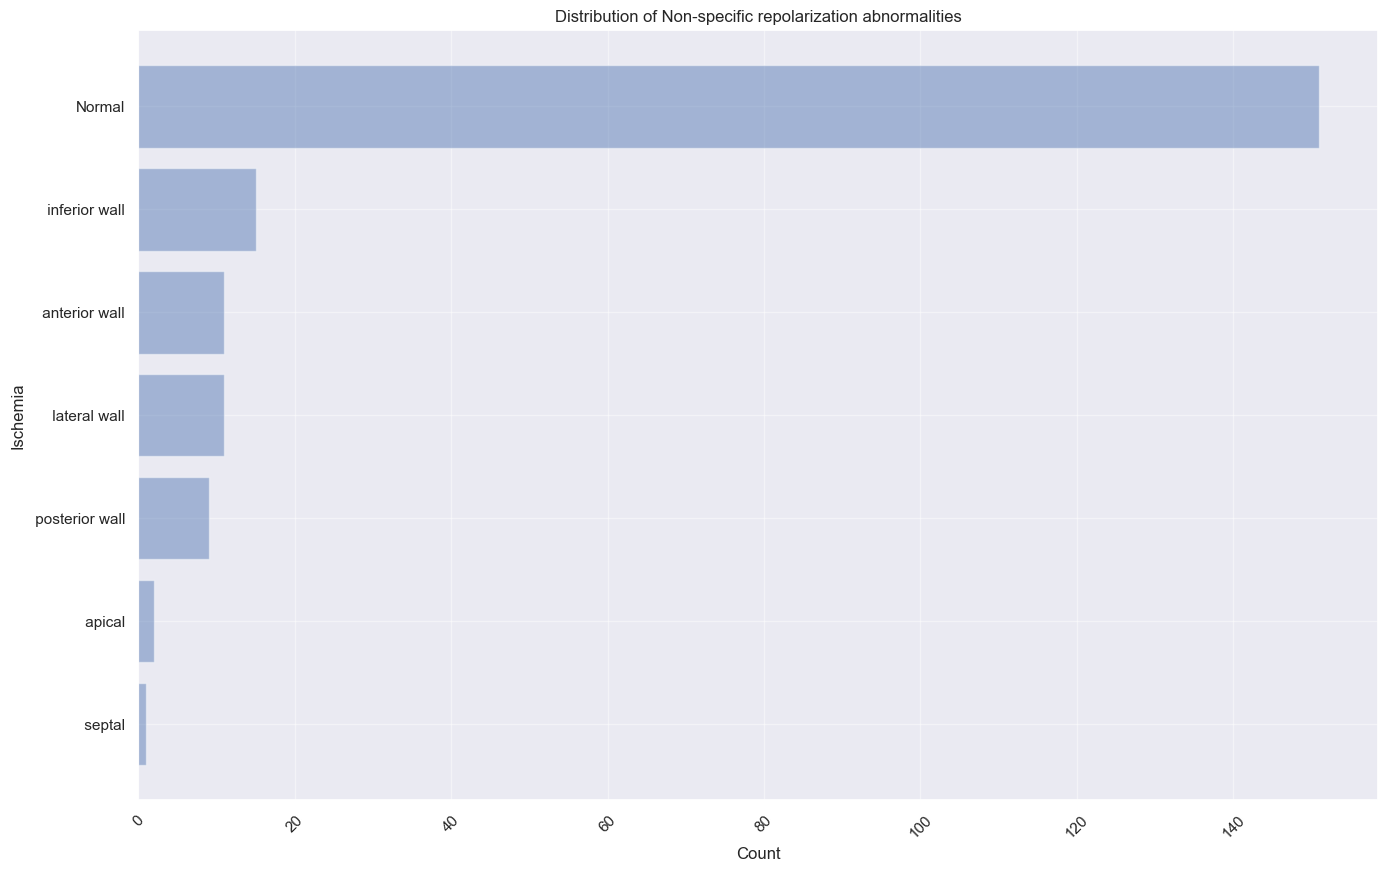

In [53]:
fig, ax = plt.subplots(figsize=(16,10))
counts = df['Abnormality'].value_counts().sort_values(ascending=True)
ax.barh(counts.index, counts.values, alpha=0.45)
plt.xlabel('Count')
plt.ylabel('Ischemia')
plt.title('Distribution of Non-specific repolarization abnormalities')
plt.xticks(rotation=45)
plt.grid(':', alpha=0.45)
plt.show()

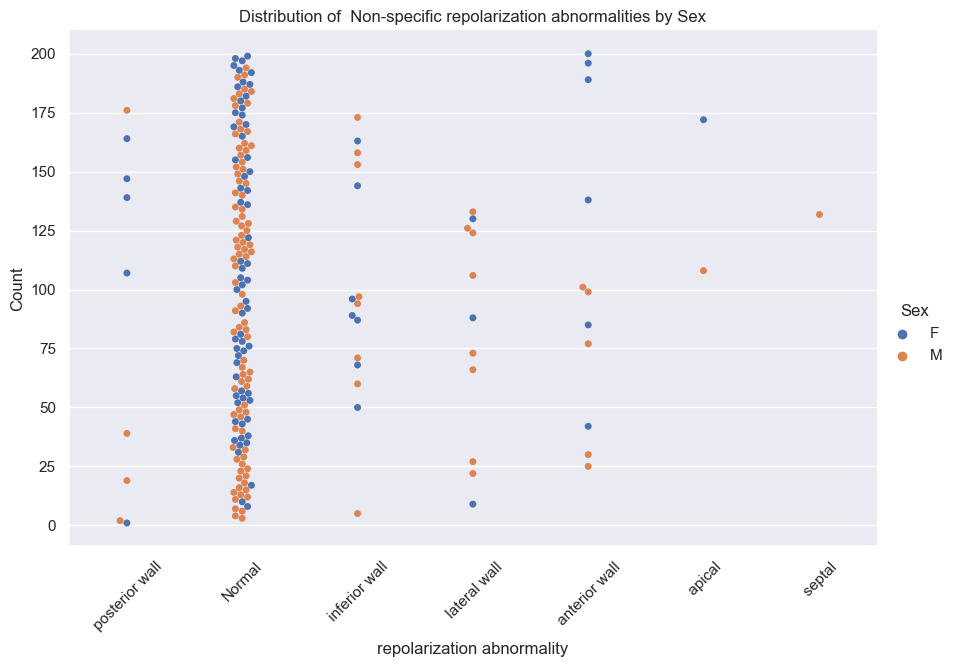

In [54]:
# fig, ax = plt.subplots(figsize=(16,8))
counts = df['Abnormality'].value_counts().sort_values(ascending=True)
sns.catplot(x='Abnormality', y = 'ID', hue='Sex', kind='swarm', data=df, height=6, aspect=1.5)
plt.xlabel('repolarization abnormality')
plt.ylabel('Count')
plt.title('Distribution of  Non-specific repolarization abnormalities by Sex')
plt.xticks(rotation=45)
plt.show()

#### 4. Looking at Cardiac Pacing

In [55]:
df['Cardiac pacing'].isna().sum()
df['Cardiac pacing'] = df['Cardiac pacing'].fillna('Normal Pacing')

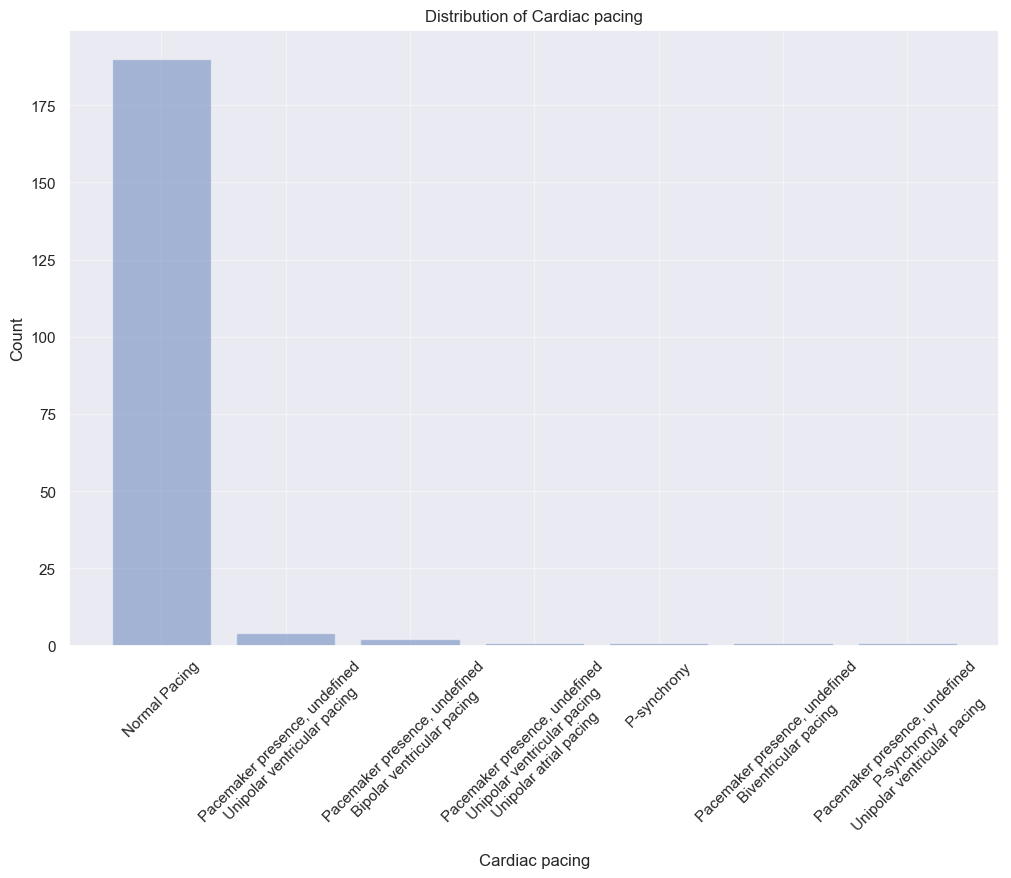

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
counts = df['Cardiac pacing'].value_counts(normalize=False)
ax.bar(counts.index, counts.values, alpha=0.45)
plt.ylabel('Count')
plt.xlabel('Cardiac pacing')
plt.title('Distribution of Cardiac pacing')
plt.xticks(rotation=45)
plt.grid(':', alpha=0.45)
plt.show()

#### 5. Other Categorical Variables


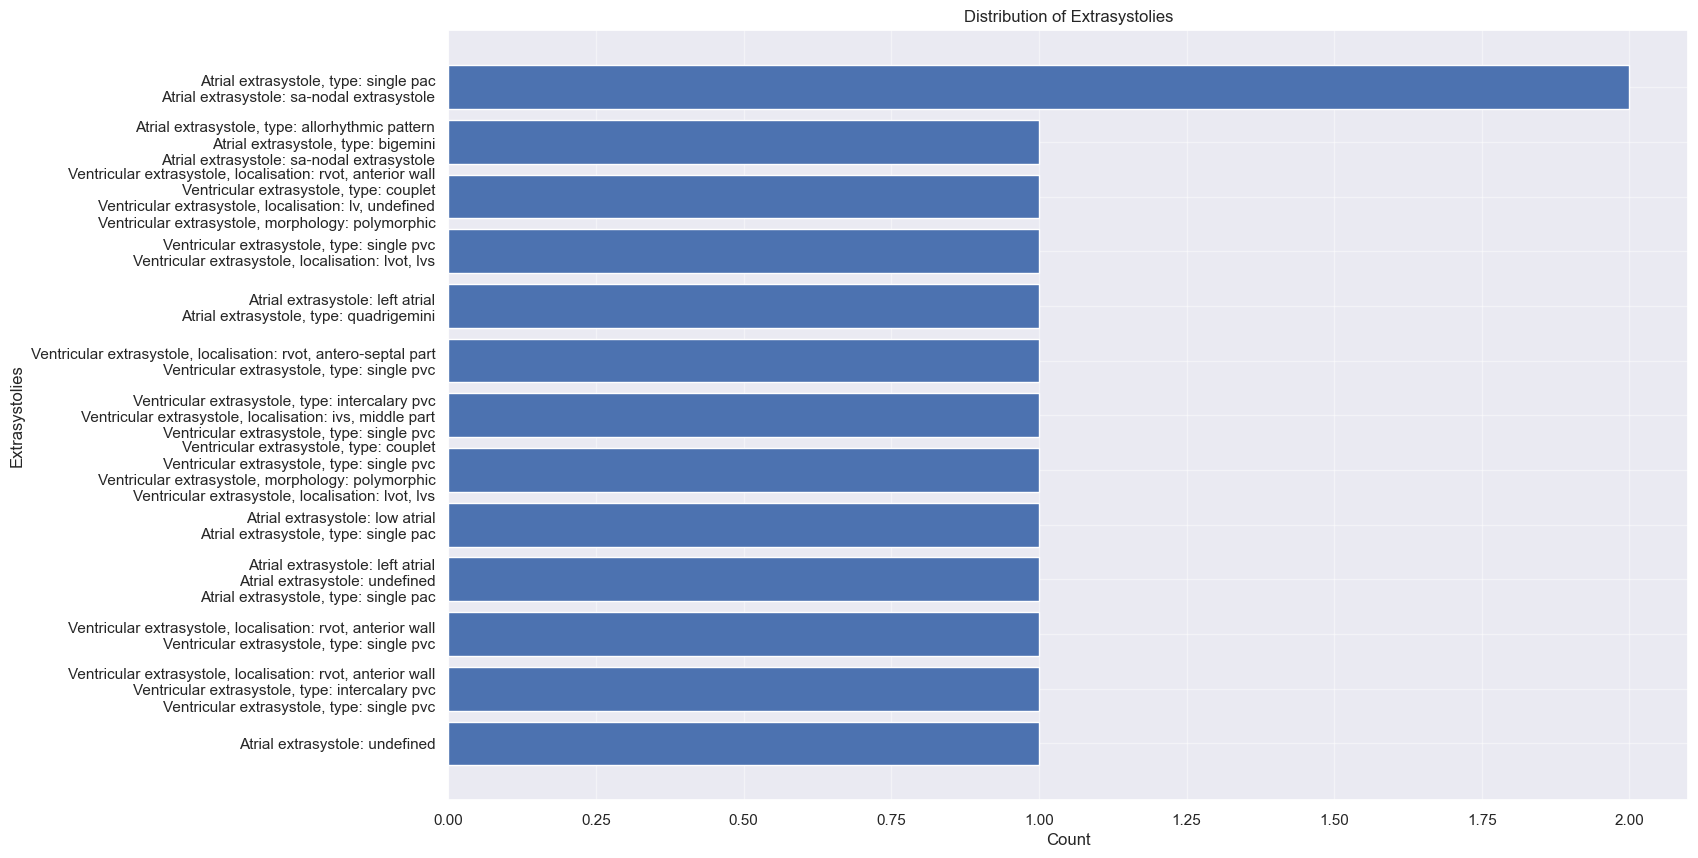

In [57]:
fig, ax = plt.subplots(figsize=(16,10))
rhythms_counts = df['Extrasystolies'].value_counts().sort_values(ascending=True)
ax.barh(rhythms_counts.index, rhythms_counts.values)
plt.xlabel('Count')
plt.ylabel('Extrasystolies')
plt.title('Distribution of Extrasystolies')
plt.grid(':', alpha=0.45)
plt.show()

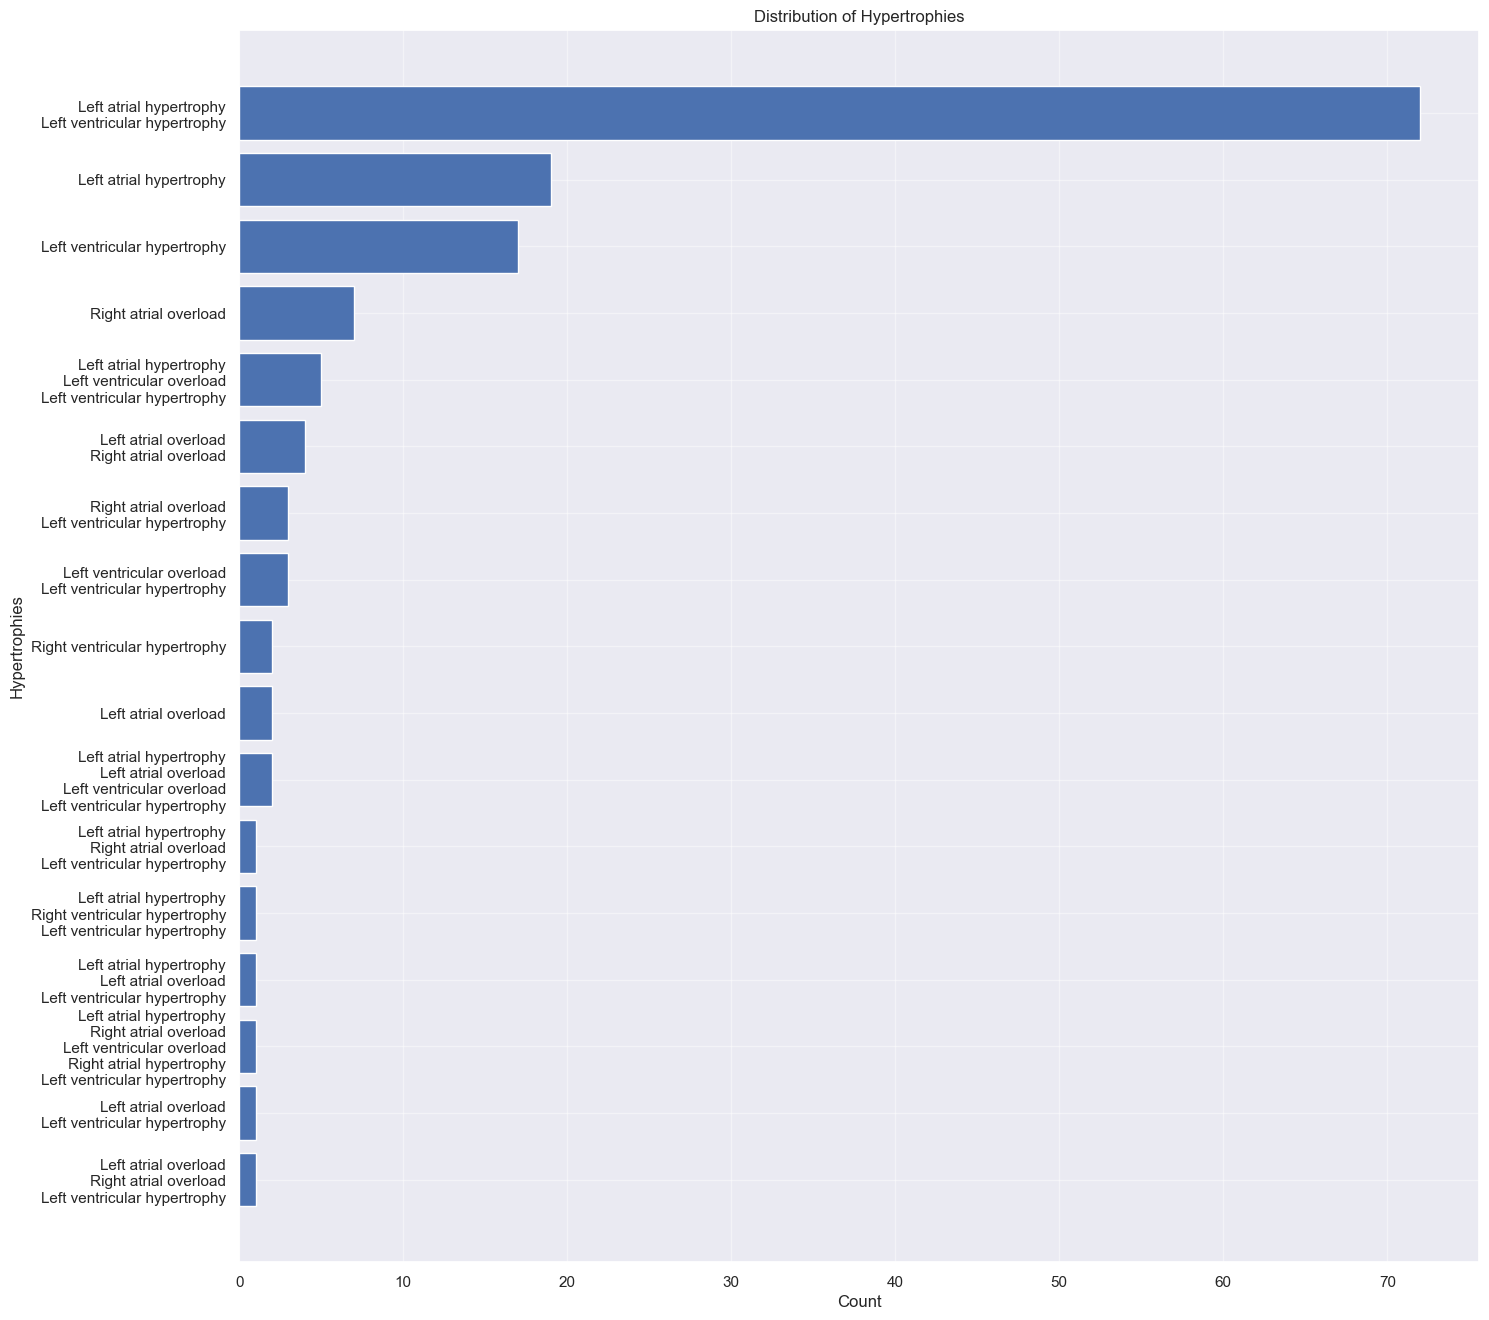

In [58]:
fig, ax = plt.subplots(figsize=(16,16))
counts = df['Hypertrophies'].value_counts().sort_values(ascending=True)
ax.barh(counts.index, counts.values)
plt.xlabel('Count')
plt.ylabel('Hypertrophies')
plt.title('Distribution of Hypertrophies')
plt.grid(':', alpha=0.45)
plt.show()

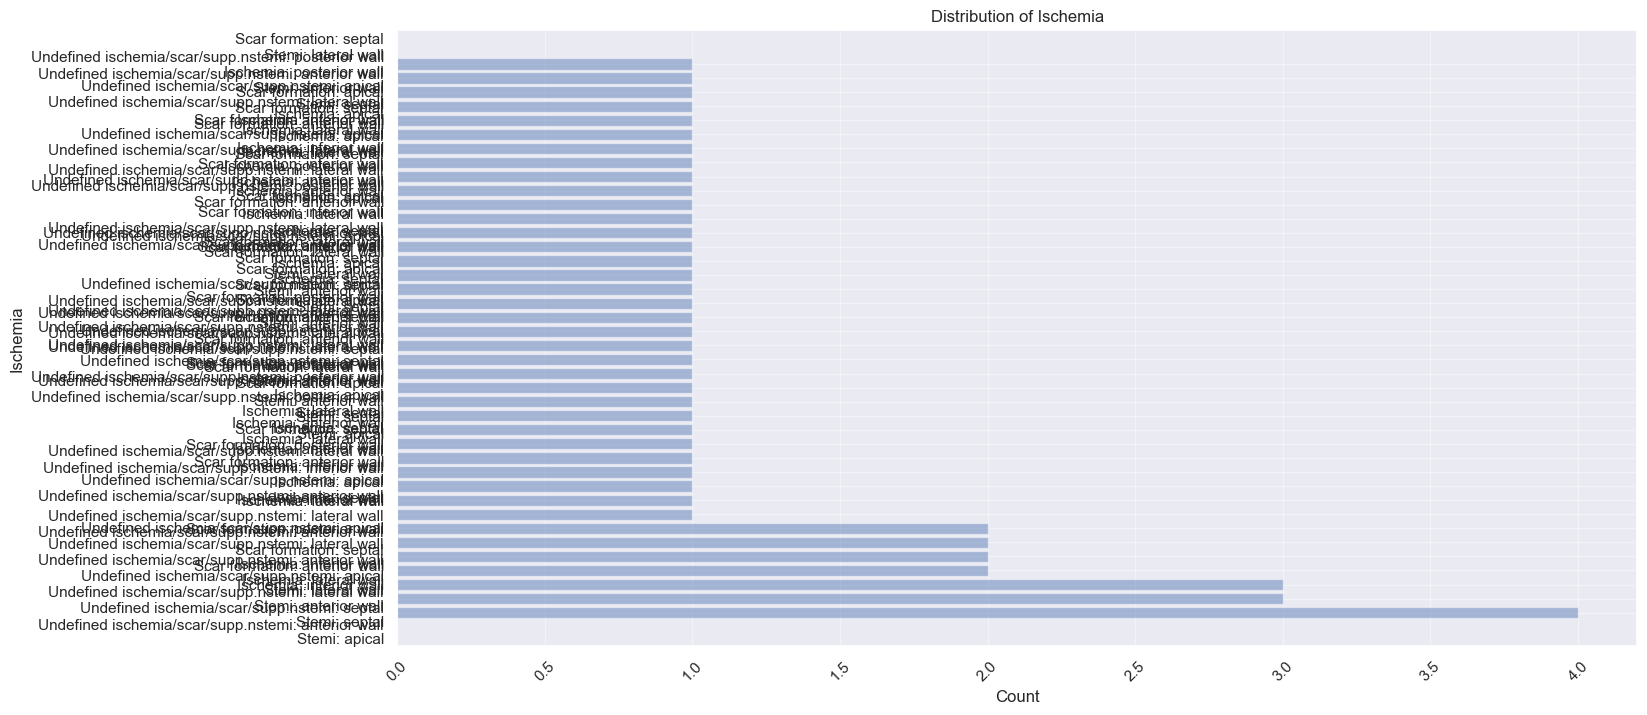

In [59]:
fig, ax = plt.subplots(figsize=(16,8))
counts = df['Ischemia'].value_counts()
ax.barh(counts.index, counts.values, alpha=0.45)
plt.xlabel('Count')
plt.ylabel('Ischemia')
plt.title('Distribution of Ischemia')
plt.xticks(rotation=45)
plt.grid(':', alpha=0.45)
plt.show()

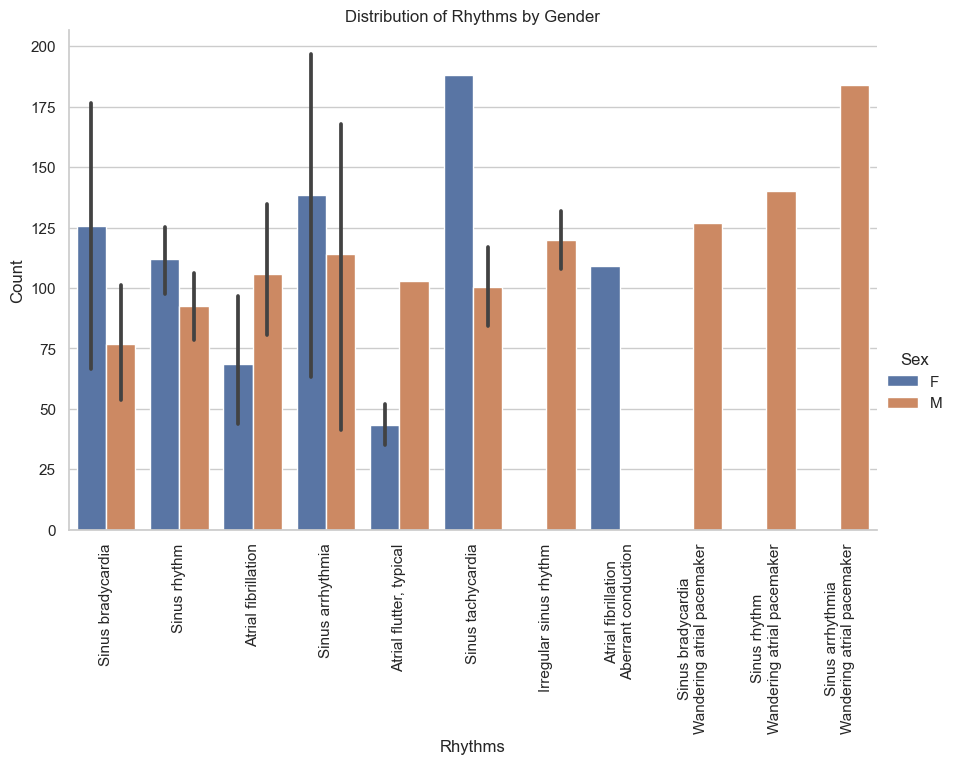

In [60]:
# Create a count plot of Rhythms by Gender
sns.set_style("whitegrid")
sns.catplot(x='Rhythms', y='ID', hue='Sex', kind='bar', data=df, height=6, aspect=1.5)
plt.xlabel('Rhythms')
plt.ylabel('Count')
plt.title('Distribution of Rhythms by Gender')
plt.xticks(rotation=90)

plt.show()


<a id="3"></a>
# 3. Base Model

As aformentioned, our base model will be a convolutional neural network, taking in as input the section of an ECG recording corresponding to a single heartbeat (one P,Q,R,S, and T segment each for those who are familiar) across all 12 leads and produce as output a binary indicator of the presence or absence of a specific disease. We are choosing this model design as it is best suited to the relatively small size of our dataset, as using individual waves as opposed to the full 10s recording per patient greatly increases the number of individual observations avialable for training, and such an approach has seen [success in use in CNNs predicting on ECG data](https://doi.org/10.3390/electronics9060951
)  similar the one we plan to build

<a id="3.1"></a>
## 3.1 Create Tensorflow Dataset Pipeline

In [71]:
# use this function to load the dataset based on the response variable in question
demodf_enc = pd.read_csv('demodf_enc.csv')

def pickle_saver(item, filepath):
    with open(filepath, "wb") as pkle:
        pickle.dump(item, pkle)
    return
        
def pickle_loader(filepath):
    with open(filepath, "rb") as pkle:
        item = pickle.load(pkle)
    return item

def get_datasets(resp):
    """
    Inputs: 
        resp: Response Columns of Interest ex: "Ischemia"
        
    Outputs:
        train_dataset (tf.dataset): Tensorflow dataset for training
        val_dataset (tf.dataset): Tensorflow dataset for validation
        test_dataset (tuple): Tuple of Numpy arrays for Xtest (N x 12 x 1423) and Ytest (N x 1)
        resp_ids (Nx1 Numpy Array): Arrays of IDs mapping observations to patients
    """
    
    # get data
    resp_xdata = pickle_loader(f"pickle_data/{resp}_xdata.pickle")
    resp_ydata = pickle_loader(f"pickle_data/{resp}_ydata.pickle")
    resp_ids = pickle_loader(f"pickle_data/{resp}_ids.pickle")
    
    # train val test split
    Xtemp, Xtest, Ytemp, Ytest, temp_ids, test_ids = train_test_split(resp_xdata, resp_ydata, resp_ids, test_size=.2, random_state=109)
    Xtrain, Xval, Ytrain, Yval, train_ids, val_ids = train_test_split(Xtemp, Ytemp, temp_ids, test_size=.2, random_state=109)
    
    # convert x and y to tfds
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain)).shuffle(4000).batch(64).prefetch(AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((Xval, Yval)).shuffle(4000).batch(64).prefetch(AUTOTUNE)
#     test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest)).shuffle(4000).batch(64).prefetch(AUTOTUNE)
    test_dataset = (Xtest, Ytest)
    id_set = (train_ids, val_ids, test_ids)
    return train_dataset, val_dataset, test_dataset, id_set

In [72]:
ischemia_train, ischemia_val, ischemia_test, ischemia_ids = get_datasets("Ischemia")

<a id="3.2"></a>
## <div style="background-color:orange">3.2 Model Definition (done in tandem with Brian Ndzuki)</div>
Note: Due to shape of input need to use `data_format="channels_first"` on all 1D operating layers (`Conv1D`, `MaxPool1D`, etc.)

In [73]:
# Create a Residual Block
def Residual(X, num_channels, strides=1, use_1x1conv=False):
    # Define a convolutional layer with given num_channels, strides, kernel_size=3 and same padding 
    A = Conv1D(num_channels, strides=strides, kernel_size=3, padding='same', data_format='channels_first')(X)
    # Add a batch normalization layer
    A = BatchNormalization()(A)
    # Add ReLU activation
    A = Activation('relu')(A)
    # Define a convolutional layer with given num_channels, kernel_size=3 and same padding 
    A = Conv1D(num_channels, kernel_size=3, padding='same', data_format='channels_first')(A)
    # Add another batch normalization layer
    A = BatchNormalization()(A)
    if use_1x1conv:
        # Add a 1x1 convolution layer with given num_channels and strides
        X = tf.keras.layers.Conv2D(filters=num_channels, strides=strides, kernel_size=1)(X)
    # Add A and X for skip connection using Add layer from keras
    A = Add()([X, A]) # Skip connection
    return relu(A)

def ecg_Model(input_shape):

    # Define the input layer
    inpt = Input(shape=input_shape)

    # Add convolutional layers
    X = Conv1D(128, kernel_size=5, strides=3, activation='relu', data_format='channels_first')(inpt)
    X = MaxPool1D(pool_size=2, data_format='channels_first')(X)
    X = Residual(X, 128)
    X = BatchNormalization()(X)
    X = Conv1D(64, kernel_size=3, activation='relu', data_format='channels_first')(X)
    X = MaxPool1D(pool_size=2, data_format='channels_first')(X)
    X = BatchNormalization()(X)
    X = Conv1D(32, kernel_size=3, activation='relu', data_format='channels_first')(X)
    X = MaxPool1D(pool_size=2, data_format='channels_first')(X)

    # Flatten the output and add fully connected layers
    X = Flatten()(X)
    X = Dense(150, activation='relu')(X)
    X = Dropout(0.2)(X)
    outputs = Dense(1, activation='sigmoid')(X)

    # Define the model
    model = Model(inputs=inpt, outputs=outputs)

    return model

In [74]:
input_shape = (12,1423)
model = ecg_Model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12, 1423)]   0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 128, 473)     7808        ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 128, 236)    0           ['conv1d_10[0][0]']              
                                                                                                  
 conv1d_11 (Conv1D)             (None, 128, 236)     49280       ['max_pooling1d_6[0][0]']        
                                                                                            

## 3.3 Model Training & Evaluation


<a id="3.3.1"></a>
### 3.3.1 Ischemia

In [75]:
history = model.fit(ischemia_train, epochs=200,
                   validation_data=ischemia_val,
                   callbacks=[ModelCheckpoint("models/ischemia", save_best_only=True),
                             EarlyStopping(patience=30, restore_best_weights=True)])
pickle_saver(history.history, "model_histories/ischemia.pickle")

Epoch 1/200


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/model_2/conv1d_14/Conv1D/Conv2DBackpropFilter' defined at (most recent call last):
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\justi\AppData\Local\Temp\ipykernel_27424\1472523711.py", line 1, in <module>
      history = model.fit(ischemia_train, epochs=200,
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\engine\training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/model_2/conv1d_14/Conv1D/Conv2DBackpropFilter'
Conv2DCustomBackpropFilterOp only supports NHWC.
	 [[{{node gradient_tape/model_2/conv1d_14/Conv1D/Conv2DBackpropFilter}}]] [Op:__inference_train_function_12100]

In [8]:
history = pickle_loader("model_histories/ischemia.pickle")

def plot_train_results(history, resp):

    # create subplots
    fig, ax = plt.subplots(1, 2, figsize=(12,8))
    
    # create epochs list
    eps = np.linspace(1, len(history['loss']), len(history['loss']))
    
    # plot losses
    plt.sca(ax[0])
    plt.plot(eps, history['loss'], label='train')
    plt.plot(eps, history['val_loss'], label='validation')
    plt.xlabel("Epochs")
    plt.ylabel("Binary Cross Entropy")
    plt.title("Loss vs. Epochs")
    plt.legend()
    
    # plot accuracies
    plt.sca(ax[1])
    plt.plot(eps, history['accuracy'], label='train')
    plt.plot(eps, history['val_accuracy'], label='validation')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epochs")
    plt.legend()
    
    plt.suptitle(f"Train Results for {resp}")
    plt.tight_layout()
    
plot_train_results(history, "Ischemia")

FileNotFoundError: [Errno 2] No such file or directory: 'model_histories/ischemia.pickle'

In [213]:
# model = tf.keras.models.load_model("models/ischemia")
ischemia_raw_preds = model.predict(ischemia_test[0]).flatten()
ischemia_preds = ischemia_raw_preds.round()

17/17 [==============================] - 0s 3ms/step


Test Accuracy: 0.917


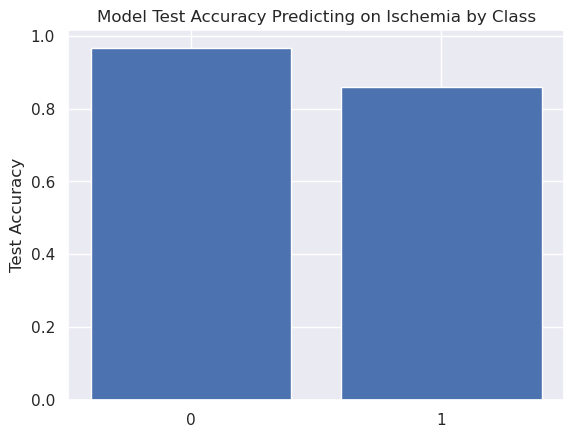

In [227]:
acc0 = accuracy_score(ischemia_preds[ischemia_test[1]==0], ischemia_test[1][ischemia_test[1]==0])
acc1 = accuracy_score(ischemia_preds[ischemia_test[1]==1], ischemia_test[1][ischemia_test[1]==1])
full_acc = accuracy_score(ischemia_preds, ischemia_test[1])
plt.bar(np.arange(2), [acc0, acc1])
plt.title("Model Test Accuracy Predicting on Ischemia by Class")
plt.ylabel("Test Accuracy")
plt.xticks(ticks=[0,1])
print(f"Test Accuracy: {full_acc:.3f}")

From the plot above, we can see that the model performs equally well on predicting the two classes, with a mean accuracy of 93.6%.

#### Model Interpretation: Permutation Importance

We can determine the importance of each ECG lead in predicting by substituting the actual value of all other leads with the mean value for the entire dataset (effectively leaving only a single lead with valuable information) and determining model accuracy. 

In [215]:
def permutation_acc(lead_idx, resp, xtest, ytest, model):
    
    resp_xdata = pickle_loader(f"pickle_data/{resp}_xdata.pickle")
    copy_xtest = np.copy(xtest)
    
    # get data
    for i in range(12):
        
        # leave lead of interest alone
        if i == lead_idx:
            continue
    
        data = resp_xdata[:,i,:]


        to_sub = np.mean(data, axis=0) # get mean of ECG lead in question
        full_sub = np.repeat(np.expand_dims(to_sub, axis=0), xtest.shape[0], axis=0)


        copy_xtest[:,i,:] = full_sub
        
    preds = model.predict(copy_xtest, verbose=False).flatten().round()    
    return accuracy_score(preds, ytest)

def permutation_importance(resp, xtest, ytest, model):
    lead_accs = []
    lead_names = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
    for i in range(12):
        lead_accs.append(permutation_acc(i, resp, xtest, ytest, model))

    lead_accs = np.array(lead_accs)
#     lead_accs = lead_accs / np.max(lead_accs) # normalize importances
    plt.bar(np.arange(12), lead_accs)
    plt.title(f"Feature Importances for {resp} Model (by Accuracy as Sole Predictor)")
    plt.ylabel("Accuracy")

    plt.xticks(ticks=np.arange(12), labels=lead_names)
    return lead_accs

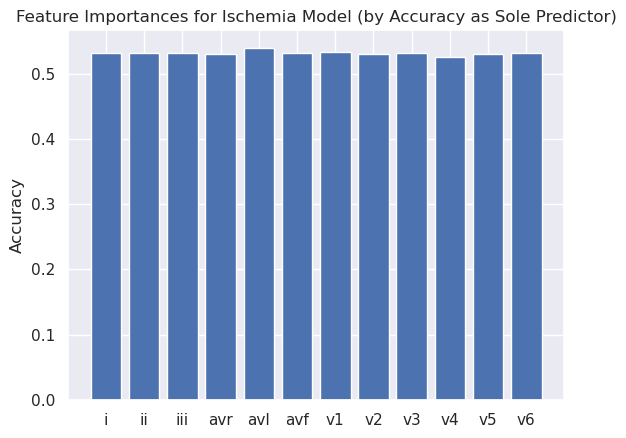

In [216]:
permutation_importance('Ischemia', ischemia_test[0], ischemia_test[1], model);

#### Model Interpretation: Demographically Sorted Results
To make sure that the model is performing (relatively) equitably across different subpopulations, we can plot the model accuracy results for subpopulations of interest

In [225]:
def id_specific_results(resp, demodf_enc, xtest, ytest, id_set, model):
    
    
    # get predictions
    preds = model.predict(xtest, verbose=False).flatten().round()  
    
    test_ids = id_set[2]
    
    # get ids belonging to each gender
    gender_ids = {}
    gender_ids[0] = demodf_enc.loc[demodf_enc['Sex']==0]['ID'].unique()
    gender_ids[1] = demodf_enc.loc[demodf_enc['Sex']==1]['ID'].unique()
    
    wave_index = {}
    
    # get wave indicies for all genders
    gender_counts = {}
    
    # loop through genders
    for gender in range(2):
        gender_counts[gender] = 0
        wave_index[gender] = []
        
        # get indices of waves belonging to specific gender
        for i in range(len(xtest)):
            if test_ids[i] in gender_ids[gender]:
                wave_index[gender].append(i)
                gender_counts[gender] += 1
                
        # convert to np array for easy indexing
        wave_index[gender] = np.array(wave_index[gender])
        
    # compute gender accuracies
    gender_accuracies = []
    for gender in range(2):
        gender_preds = preds[wave_index[gender]]
        gender_ytrue = ytest[wave_index[gender]]
        gen_acc = accuracy_score(gender_ytrue, gender_preds)
        gender_accuracies.append(gen_acc)
    gender_set = ([0, 1], gender_accuracies)
    
    #### get model accuracy by age
    # get age ranges
    ages = np.linspace(10, 80, 8)
    age_counts = {}
    
    age_wave_index = {}
    for i in range(len(ages)):
        age_counts[f"{ages[i]:.0f}-{ages[i]+10:.0f}"] = 0
        
        age_wave_index[i] = []
        # get patients in age range
        buff = demodf_enc.loc[(demodf_enc['Age']>=ages[i]) & (demodf_enc['Age']<ages[i]+10)]
        age_ids = buff['ID'].unique()
        
        
        # get wave ids for patients in age range
        for j in range(len(xtest)):
            if test_ids[j] in age_ids:
                age_wave_index[i].append(j)
                age_counts[f"{ages[i]:.0f}-{ages[i]+10:.0f}"] += 1
                
        # convert to np array for easy indexing
        age_wave_index[i] = np.array(age_wave_index[i])
    
    # compute age accuracies
    age_accuracies = []
    for i in range(len(ages)):
        # reusing above code
        age = i
        age_preds = preds[age_wave_index[age]]
        age_ytrue = ytest[age_wave_index[age]]
        age_acc = accuracy_score(age_ytrue, age_preds)
        age_accuracies.append(age_acc)
    age_set = (ages, age_accuracies)
        
    
    
    #### get model accuracy by # of abnormalities
    age_corr_df = demodf_enc.sort_values('Age')

    # count all abnormalities per patient
    demodf_abn = demodf_enc.drop(['Sex', 'Age', 'ID'], axis=1)
    age_corr_df['num_abn'] = demodf_abn.sum(axis=1)
    
    # get unique abnormality counts
    ab_count = age_corr_df['num_abn'].unique()
    ab_count = np.sort(ab_count)
    num_abn_count = {}
    
    abn_wave_index = {}
    for i in range(len(ab_count)):
        num_abn_count[ab_count[i]] = 0
        
        abn_wave_index[i] = []
        # get patients in abn range
        buff = age_corr_df.loc[age_corr_df['num_abn']==ab_count[i]]
        abn_ids = buff['ID'].unique()
        
        
        # get wave ids for patients in abn range
        for j in range(len(xtest)):
            if test_ids[j] in abn_ids:
                abn_wave_index[i].append(j)
                num_abn_count[ab_count[i]] += 1
                
        # convert to np array for easy indexing
        abn_wave_index[i] = np.array(abn_wave_index[i])
    
    # compute abn accuracies
    abn_accuracies = []
    for i in range(len(ab_count)):
        # reusing above code
        abn_preds = preds[abn_wave_index[i]]
        abn_ytrue = ytest[abn_wave_index[i]]
        abn_acc = accuracy_score(abn_ytrue, abn_preds)
        abn_accuracies.append(abn_acc)
    abn_set = (ab_count, abn_accuracies)
    
    fig, ax = plt.subplots(2, 2, figsize=(8,8))
    ax = ax.flatten()
    
    plt.sca(ax[0])
    plt.title("Model Accuracy by Gender")
    plt.bar(gender_set[0], gender_set[1])
    plt.xticks(ticks=[0,1], labels=["Male", "Female"])
    plt.xlabel("Patient ID")
    plt.ylabel("Accuracy")
    
    plt.sca(ax[1])
    plt.title("Model Accuracy by Age Range")
    xticker = np.linspace(0, len(age_set[0])-1, len(age_set[0]))
    plt.bar(xticker, age_set[1])
    ticklabels = [f"{age:.0f}-{age+10:.0f}" for age in age_set[0]]
    ticklabels[-1] = "80+"
    plt.xticks(ticks=xticker, labels=ticklabels, rotation=45)
    plt.xlabel("Age Range")
    plt.ylabel("Accuracy")
    
    plt.sca(ax[2])
    plt.title("Model Accuracy by Number of Abnormalities")
    xticker = np.linspace(0, len(abn_set[0])-1, len(abn_set[0]))
    plt.bar(xticker, abn_set[1])
    ticklabels = [f"{n}" for n in abn_set[0]]
#     ticklabels[-1] = ""
    plt.xticks(xticker, labels=ticklabels)
    plt.xlabel("Number of Abnormalities")
    plt.ylabel("Accuracy")
    
    ax[3].remove()
    
    plt.tight_layout()
    
    print(f"Gender Counts:\n{gender_counts}")
    print(f"Age Counts:\n{age_counts}")
    print(f"Number of Abnormailities Counts:\n{num_abn_count}")

Gender Counts:
{0: 325, 1: 194}
Age Counts:
{'10-20': 37, '20-30': 37, '30-40': 37, '40-50': 46, '50-60': 120, '60-70': 150, '70-80': 69, '80-90': 23}
Number of Abnormailities Counts:
{1: 42, 2: 77, 3: 193, 4: 150, 5: 54, 6: 3}


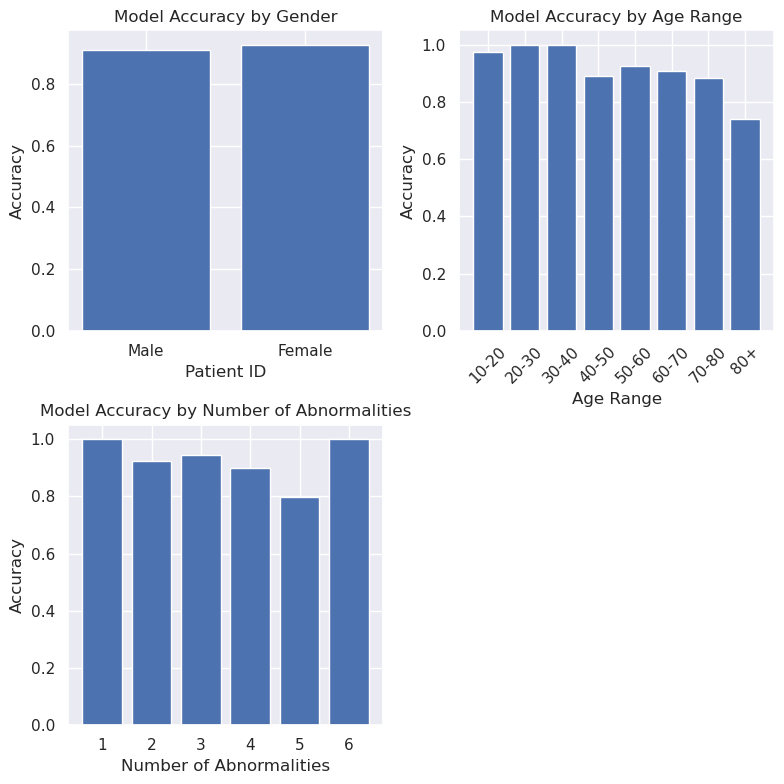

In [226]:
id_specific_results("Ischemia", demodf_enc, ischemia_test[0], ischemia_test[1], ischemia_ids, model)

<a id="3.3.1eval"></a>
#### Overall Evaluation

1. Class Separated Predictions

    Looking at the results from all of the figures above, we can see that the model seems to more accurately predict the lack of ischemia than its actual presence. The difference between the two isn't huge, but is certainly enough to be considered a "weakness" of the model. 
    
2. Permutation Importances
    Looking at the permutation importances, we see that no individual ECG lead is all that much better than the other in predicting ischemia, and they all have poor accuracies near 50%, which we would expect for completely random data. This suggests that in order to make accurate predictions the model relies on the combination of information from different leads, and pays strong attention to what would be equivalent of "interaction" in a polynomial regression model.
3. Demographically Separated Predictions
    - Sex
        - The model seems not to be bias in favor of any one gender in predicting ischemia
    - Age
        - There seems to be a clear trend of decreasing model accuracy with increasing age. While for the later ages this could possibly be due to a lack of examples available for training, this trend still holds for ages with a good number of examples like 50-60 and 60-70, suggesting that it may have more to do with the model needing patient age as a way to contextualize the ECG data being seen.
    - Number of Abnormalities
        - There seems to be a negative relationship between number of abnormalties and accuracy. Practically, this could make some sense, as the effects of different heart conditions on an ECG trace would be summative, potentially obscuring key ECG trace features that would be indicative of specific individual conditions.
        
Overall the model performed reasonably well, but there are signs that adding extra inputs in the form of demographic information (especially age) could be of benefit.

<a id="3.3.2"></a>
### 3.3.2 Hypertrophies

In [189]:
# get the training data
column = 'Hypertrophies'
hypertrophies_train, hypertrophies_val, hypertrophies_test, hypertrophies_ids = get_datasets(column)

In [190]:
input_shape = (12,1423)
model = ecg_Model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_hypertrophies = model.fit(hypertrophies_train, epochs=200,
                   validation_data=hypertrophies_val,
                   callbacks=[ModelCheckpoint("models/hypertrophies", save_best_only=True),
                             EarlyStopping(patience=30, restore_best_weights=True)])
pickle_saver(history_hypertrophies.history, "model_histories/hypertrophies.pickle")

Epoch 1/200


2023-05-07 22:12:02.427656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1606,12,1423]
	 [[{{node Placeholder/_0}}]]
2023-05-07 22:12:02.428109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1606]
	 [[{{node Placeholder/_1}}]]


23/26 [=========================>....] - ETA: 0s - loss: 0.5032 - accuracy: 0.7575

2023-05-07 22:12:06.828997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [402,12,1423]
	 [[{{node Placeholder/_0}}]]
2023-05-07 22:12:06.829407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [402,12,1423]
	 [[{{node Placeholder/_0}}]]
2023-05-07 22:12:07.712854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape 

INFO:tensorflow:Assets written to: models/hypertrophies/assets


INFO:tensorflow:Assets written to: models/hypertrophies/assets


26/26 [==============================] - 7s 118ms/step - loss: 0.4908 - accuracy: 0.7634 - val_loss: 0.6884 - val_accuracy: 0.5174
Epoch 2/200
26/26 [==============================] - 1s 18ms/step - loss: 0.3299 - accuracy: 0.8543 - val_loss: 0.7057 - val_accuracy: 0.5174
Epoch 3/200
26/26 [==============================] - 0s 16ms/step - loss: 0.2685 - accuracy: 0.8873 - val_loss: 0.7403 - val_accuracy: 0.5174
Epoch 4/200
26/26 [==============================] - 0s 15ms/step - loss: 0.2185 - accuracy: 0.9078 - val_loss: 0.8325 - val_accuracy: 0.5174
Epoch 5/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1932 - accuracy: 0.9209 - val_loss: 0.8807 - val_accuracy: 0.5174
Epoch 6/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1571 - accuracy: 0.9427 - val_loss: 0.9418 - val_accuracy: 0.5174
Epoch 7/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1262 - accuracy: 0.9545 - val_loss: 1.0136 - val_accuracy: 0.5174
Epoch 8/200
26/26

2023-05-07 22:12:17.014245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:12:17.694596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/hypertrophies/assets


INFO:tensorflow:Assets written to: models/hypertrophies/assets


26/26 [==============================] - 3s 103ms/step - loss: 0.0214 - accuracy: 0.9975 - val_loss: 0.6195 - val_accuracy: 0.5572
Epoch 18/200
26/26 [==============================] - 1s 18ms/step - loss: 0.0168 - accuracy: 0.9988 - val_loss: 0.6343 - val_accuracy: 0.5597
Epoch 19/200
25/26 [===========================>..] - ETA: 0s - loss: 0.0124 - accuracy: 0.9994

2023-05-07 22:12:20.149661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:12:20.825381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/hypertrophies/assets


INFO:tensorflow:Assets written to: models/hypertrophies/assets


26/26 [==============================] - 3s 103ms/step - loss: 0.0123 - accuracy: 0.9994 - val_loss: 0.4057 - val_accuracy: 0.8955
Epoch 20/200
24/26 [==========================>...] - ETA: 0s - loss: 0.0127 - accuracy: 0.9993

2023-05-07 22:12:22.865850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:12:23.539358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/hypertrophies/assets


INFO:tensorflow:Assets written to: models/hypertrophies/assets


26/26 [==============================] - 3s 107ms/step - loss: 0.0128 - accuracy: 0.9994 - val_loss: 0.3901 - val_accuracy: 0.8980
Epoch 21/200
22/26 [========================>.....] - ETA: 0s - loss: 0.0122 - accuracy: 1.0000

2023-05-07 22:12:25.559329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:12:26.241362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/hypertrophies/assets


INFO:tensorflow:Assets written to: models/hypertrophies/assets


26/26 [==============================] - 3s 107ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.2544 - val_accuracy: 0.9328
Epoch 22/200
24/26 [==========================>...] - ETA: 0s - loss: 0.0123 - accuracy: 0.9980

2023-05-07 22:12:28.333436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:12:29.027287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/hypertrophies/assets


INFO:tensorflow:Assets written to: models/hypertrophies/assets


26/26 [==============================] - 3s 109ms/step - loss: 0.0122 - accuracy: 0.9981 - val_loss: 0.2088 - val_accuracy: 0.9303
Epoch 23/200
24/26 [==========================>...] - ETA: 0s - loss: 0.0115 - accuracy: 0.9993

2023-05-07 22:12:31.098004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:12:31.781108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/hypertrophies/assets


INFO:tensorflow:Assets written to: models/hypertrophies/assets


26/26 [==============================] - 3s 108ms/step - loss: 0.0129 - accuracy: 0.9988 - val_loss: 0.1850 - val_accuracy: 0.9353
Epoch 24/200
26/26 [==============================] - 0s 18ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.1873 - val_accuracy: 0.9303
Epoch 25/200
25/26 [===========================>..] - ETA: 0s - loss: 0.0077 - accuracy: 0.9994

2023-05-07 22:12:34.235845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:12:36.062183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/hypertrophies/assets


INFO:tensorflow:Assets written to: models/hypertrophies/assets


26/26 [==============================] - 4s 150ms/step - loss: 0.0077 - accuracy: 0.9994 - val_loss: 0.1841 - val_accuracy: 0.9279
Epoch 26/200
26/26 [==============================] - 1s 19ms/step - loss: 0.0072 - accuracy: 0.9994 - val_loss: 0.1913 - val_accuracy: 0.9254
Epoch 27/200
26/26 [==============================] - 0s 15ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.1989 - val_accuracy: 0.9353
Epoch 28/200
26/26 [==============================] - 0s 15ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2056 - val_accuracy: 0.9279
Epoch 29/200
26/26 [==============================] - 0s 15ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2056 - val_accuracy: 0.9279
Epoch 30/200
26/26 [==============================] - 0s 15ms/step - loss: 0.0061 - accuracy: 0.9988 - val_loss: 0.2062 - val_accuracy: 0.9204
Epoch 31/200
26/26 [==============================] - 0s 15ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.2040 - val_accuracy: 0.9303
Epoch 32/20

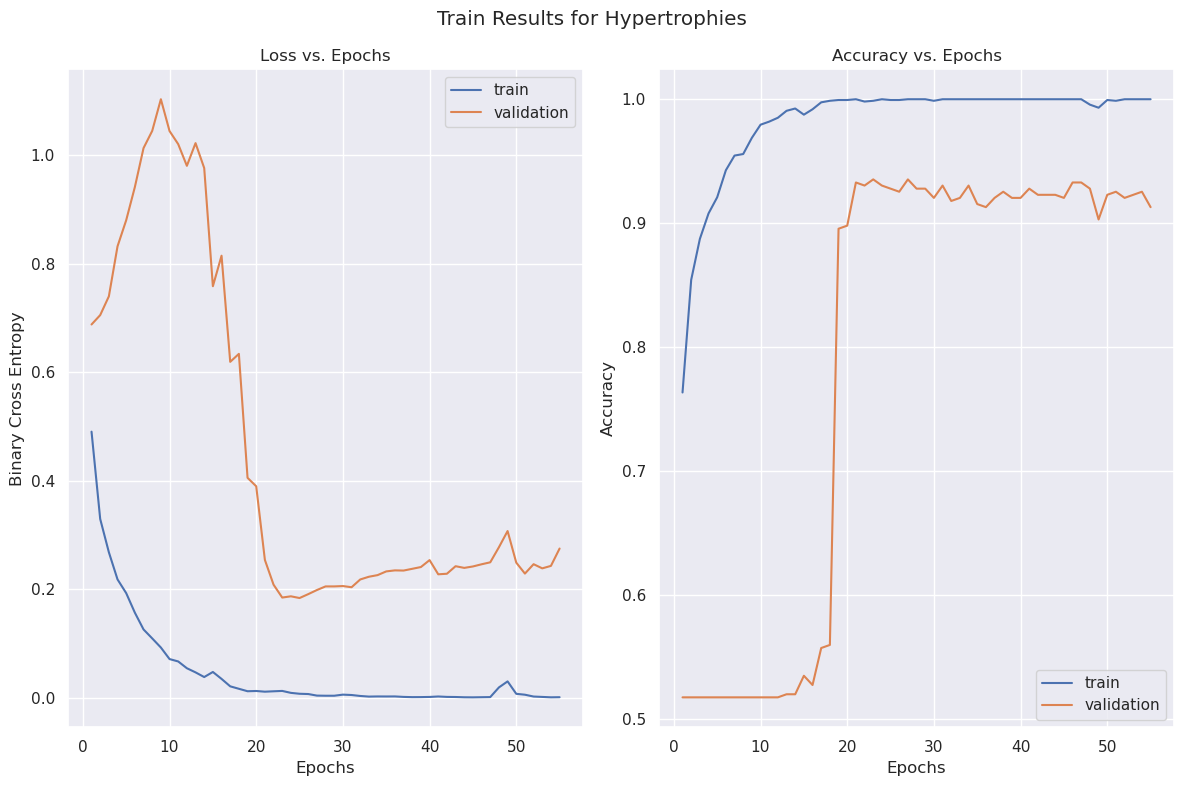

In [191]:
history = pickle_loader("model_histories/hypertrophies.pickle")
plot_train_results(history, column)

In [192]:
hypertrophies_preds = model.predict(hypertrophies_test[0]).flatten().round()

16/16 [==============================] - 0s 3ms/step


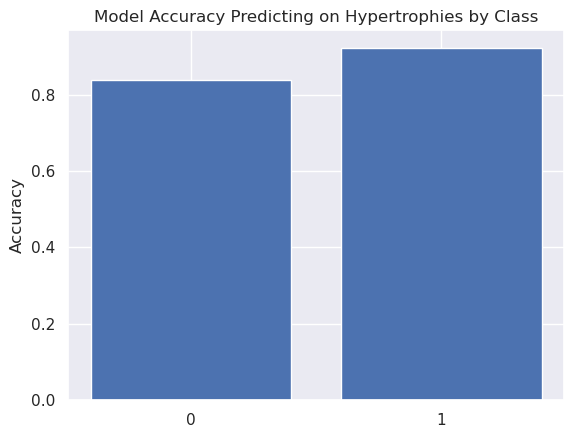

In [193]:
acc0 = accuracy_score(hypertrophies_preds[hypertrophies_test[1]==0], hypertrophies_test[1][hypertrophies_test[1]==0])
acc1 = accuracy_score(hypertrophies_preds[hypertrophies_test[1]==1], hypertrophies_test[1][hypertrophies_test[1]==1])

plt.bar(np.arange(2), [acc0, acc1])
plt.title(f"Model Accuracy Predicting on {column} by Class")
plt.ylabel("Accuracy")
plt.xticks(ticks=[0,1]);

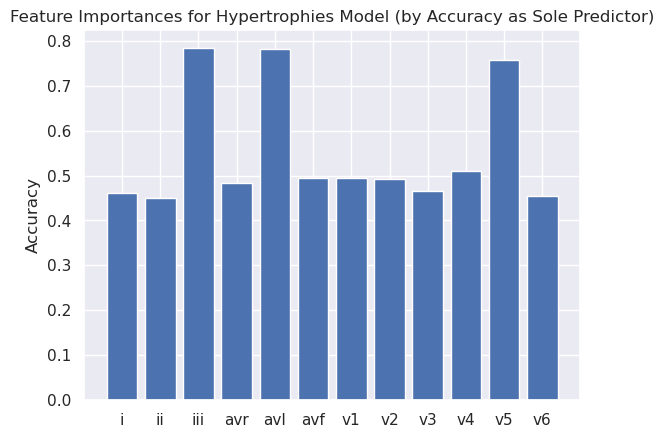

In [194]:
permutation_importance('Hypertrophies', hypertrophies_test[0], hypertrophies_test[1], model);

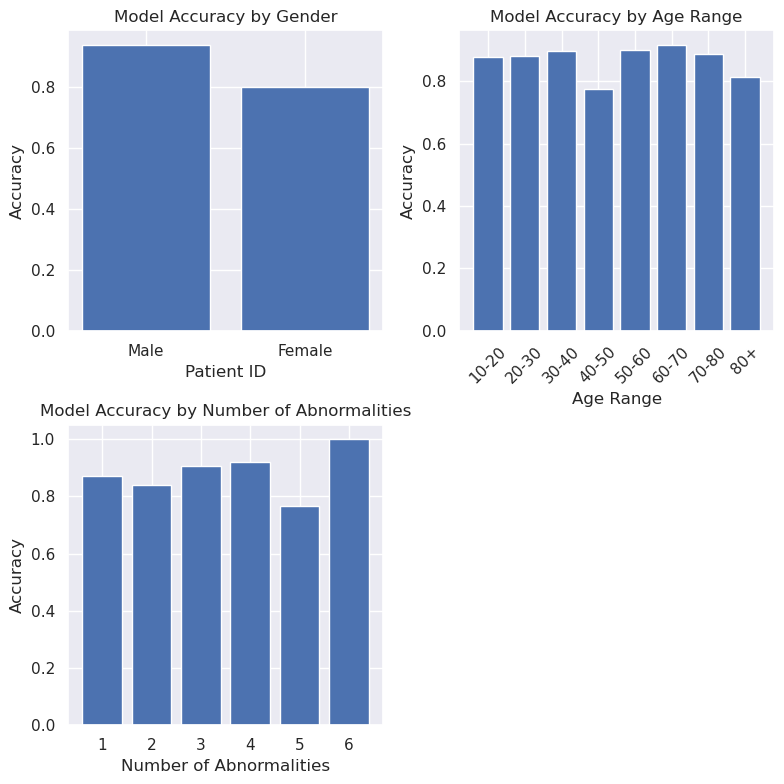

In [195]:
id_specific_results("Hypertrophies", demodf_enc, hypertrophies_test[0], hypertrophies_test[1], hypertrophies_ids, model)

<a id="3.3.2eval"></a>
#### Overall Evaluation

1. Class Separated Predictions

    Looking at the results from all of the figures above, we can see that the model seems to more accurately predict the presence of hypertrophy than its absence. The difference between the two isn't huge, but is certainly enough to again be considered a "weakness" of the model. 
    
2. Permutation Importances
    Looking at the permutation importances, we see that leads iii (heart interior surface), aVL (lateral surface), and v5 (lateral surface). Given that two leads from the lateral surace category had high importance, this would suggest that the electrical activity from this part of the heart is most telling of the presence of hypertrophy. This result is actually consistent with studies done on the affect of <a href="https://ecgwaves.com/topic/ecg-left-ventricular-hypertrophy-lvh-clinical-characteristics/#:~:text=ECG%20changes%20seen%20in%20left,leads%20(V1%2C%20V2).">hypertrophy on ECG waves</a>, where it was found that electrical amplitudes of the R waves were larger than normal, and that difference was most pronounced on the v5, v6, aVL and i leads. 
3. Demographically Separated Predictions
    - Sex
        - The model seems to be much better at predicting for males than females. Taking into account the fact that R wave amplitude is expected to play a part in predictions, and that the average ampltiude for men and women is likely to differ, this may be resolvable by providing sex as an input metric, allowing the model to contextualize ampltidues seen
    - Age
        - There doesn't seem to be any clear relationship between age and model accuracy
    - Number of Abnormalities
        - There doesn't seem to be any clear relationship between number of abnormalities and model accuracy
        
Overall the model performed reasonably well, but just as before there are signs that adding extra inputs in the form of demographic information (especially gender) could be of benefit.

<a id="3.3.3"></a>
### 3.3.3 Conduction Abnormalities

In [196]:
# get the training data
column = 'Conduction abnormalities'
cond_train, cond_val, cond_test, cond_ids = get_datasets(column)

In [197]:
input_shape = (12,1423)
model = ecg_Model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(cond_train, epochs=200,
                   validation_data=cond_val,
                   callbacks=[ModelCheckpoint("models/cond", save_best_only=True),
                             EarlyStopping(patience=30, restore_best_weights=True)])
pickle_saver(history.history, "model_histories/cond.pickle")

Epoch 1/200


2023-05-07 22:32:33.492898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1519,12,1423]
	 [[{{node Placeholder/_0}}]]
2023-05-07 22:32:33.493312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1519,12,1423]
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.7005

2023-05-07 22:32:38.799121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [380]
	 [[{{node Placeholder/_1}}]]
2023-05-07 22:32:38.799518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [380]
	 [[{{node Placeholder/_1}}]]
2023-05-07 22:32:39.753032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node

INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 8s 170ms/step - loss: 0.5934 - accuracy: 0.7005 - val_loss: 0.6948 - val_accuracy: 0.4921
Epoch 2/200
24/24 [==============================] - 1s 20ms/step - loss: 0.4289 - accuracy: 0.7972 - val_loss: 0.6961 - val_accuracy: 0.4711
Epoch 3/200
24/24 [==============================] - 0s 15ms/step - loss: 0.3866 - accuracy: 0.8045 - val_loss: 0.6993 - val_accuracy: 0.4711
Epoch 4/200
24/24 [==============================] - 0s 15ms/step - loss: 0.3459 - accuracy: 0.8433 - val_loss: 0.7095 - val_accuracy: 0.4711
Epoch 5/200
24/24 [==============================] - 0s 15ms/step - loss: 0.3118 - accuracy: 0.8756 - val_loss: 0.7274 - val_accuracy: 0.4711
Epoch 6/200
24/24 [==============================] - 0s 15ms/step - loss: 0.2796 - accuracy: 0.8874 - val_loss: 0.7231 - val_accuracy: 0.4711
Epoch 7/200
24/24 [==============================] - 0s 16ms/step - loss: 0.2423 - accuracy: 0.9118 - val_loss: 0.7519 - val_accuracy: 0.4711
Epoch 8/200
24/24

2023-05-07 22:32:49.140343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:32:49.817013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 3s 111ms/step - loss: 0.0470 - accuracy: 0.9947 - val_loss: 0.6888 - val_accuracy: 0.5684
Epoch 18/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0299 - accuracy: 0.9963

2023-05-07 22:32:51.876295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:32:52.558599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 3s 115ms/step - loss: 0.0308 - accuracy: 0.9967 - val_loss: 0.6416 - val_accuracy: 0.6053
Epoch 19/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0241 - accuracy: 0.9986

2023-05-07 22:32:56.935972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:32:57.613635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 3s 115ms/step - loss: 0.0243 - accuracy: 0.9987 - val_loss: 0.5589 - val_accuracy: 0.6605
Epoch 20/200
24/24 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9993

2023-05-07 22:32:59.643372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:33:00.322813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 3s 116ms/step - loss: 0.0217 - accuracy: 0.9993 - val_loss: 0.5473 - val_accuracy: 0.6895
Epoch 21/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0190 - accuracy: 1.0000

2023-05-07 22:33:02.357135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:33:03.036456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 3s 116ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.4009 - val_accuracy: 0.8026
Epoch 22/200
24/24 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9993

2023-05-07 22:33:05.053792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:33:05.732264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 3s 116ms/step - loss: 0.0150 - accuracy: 0.9993 - val_loss: 0.3950 - val_accuracy: 0.8079
Epoch 23/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0156 - accuracy: 0.9993

2023-05-07 22:33:08.920580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:33:09.606163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 4s 166ms/step - loss: 0.0156 - accuracy: 0.9993 - val_loss: 0.3133 - val_accuracy: 0.8579
Epoch 24/200
24/24 [==============================] - 1s 20ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.3136 - val_accuracy: 0.8605
Epoch 25/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0110 - accuracy: 0.9993

2023-05-07 22:33:13.323848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:33:14.002925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 3s 112ms/step - loss: 0.0110 - accuracy: 0.9993 - val_loss: 0.2972 - val_accuracy: 0.8711
Epoch 26/200
24/24 [==============================] - 0s 19ms/step - loss: 0.0091 - accuracy: 0.9993 - val_loss: 0.3008 - val_accuracy: 0.8737
Epoch 27/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0087 - accuracy: 1.0000

2023-05-07 22:33:16.569886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:33:17.249440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 3s 112ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.2795 - val_accuracy: 0.8974
Epoch 28/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

2023-05-07 22:33:19.263411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:33:19.944645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 3s 115ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.2760 - val_accuracy: 0.8974
Epoch 29/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

2023-05-07 22:33:21.989933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:33:22.669725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/cond/assets


INFO:tensorflow:Assets written to: models/cond/assets


24/24 [==============================] - 3s 115ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.2716 - val_accuracy: 0.9079
Epoch 30/200
24/24 [==============================] - 1s 19ms/step - loss: 0.0071 - accuracy: 0.9993 - val_loss: 0.2722 - val_accuracy: 0.9132
Epoch 31/200
24/24 [==============================] - 0s 15ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2719 - val_accuracy: 0.9105
Epoch 32/200
24/24 [==============================] - 0s 15ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2761 - val_accuracy: 0.9158
Epoch 33/200
24/24 [==============================] - 0s 15ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2777 - val_accuracy: 0.9053
Epoch 34/200
24/24 [==============================] - 0s 15ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2815 - val_accuracy: 0.9105
Epoch 35/200
24/24 [==============================] - 0s 15ms/step - loss: 0.0054 - accuracy: 0.9993 - val_loss: 0.2941 - val_accuracy: 0.9105
Epoch 36/20

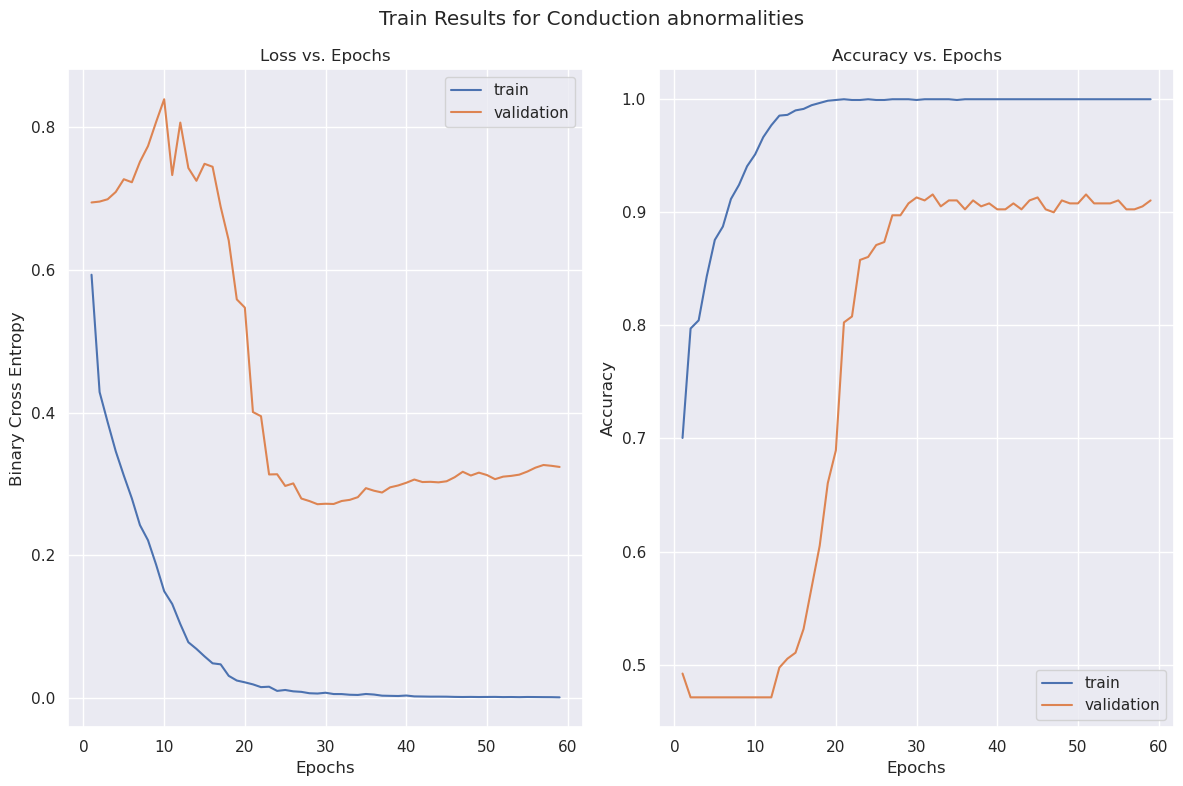

In [198]:
history = pickle_loader("model_histories/cond.pickle") 
plot_train_results(history, column)

In [199]:
cond_preds = model.predict(cond_test[0]).flatten().round()

15/15 [==============================] - 0s 10ms/step


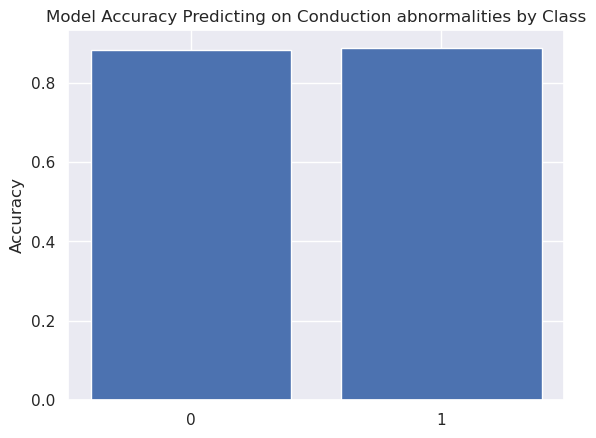

In [200]:
acc0 = accuracy_score(cond_preds[cond_test[1]==0], cond_test[1][cond_test[1]==0])
acc1 = accuracy_score(cond_preds[cond_test[1]==1], cond_test[1][cond_test[1]==1])

plt.bar(np.arange(2), [acc0, acc1])
plt.title(f"Model Accuracy Predicting on {column} by Class")
plt.ylabel("Accuracy")
plt.xticks(ticks=[0,1]);

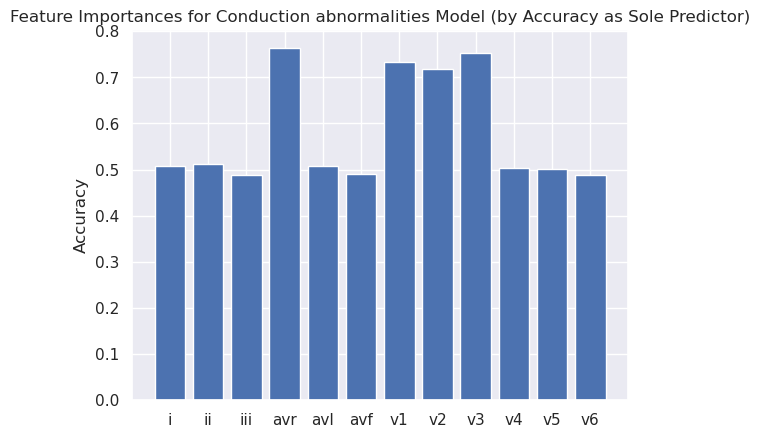

In [201]:
permutation_importance('Conduction abnormalities', cond_test[0], cond_test[1], model);

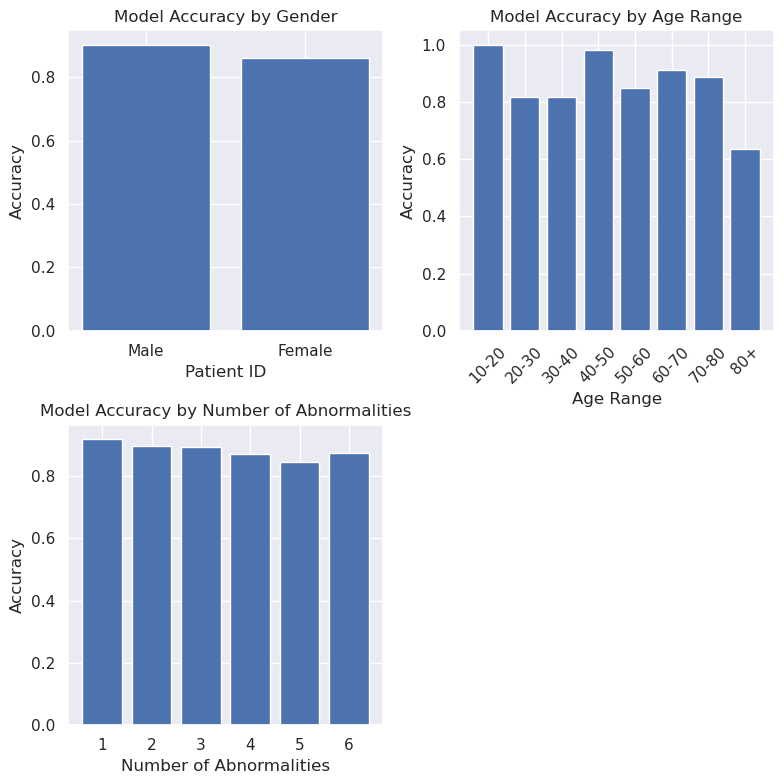

In [202]:
id_specific_results("Conduction abnormalities", demodf_enc, cond_test[0], cond_test[1], cond_ids, model)

<a id="3.3.3eval"></a>
#### Overall Evaluation

1. Class Separated Predictions

    The model seems to have similar accuracy in predicting both classes.
    
2. Permutation Importances
    Looking at the permutation importances, we see that leads aVR (Left Ventricle), v1, v2, and v3 (all anterior surface of the heart) were the most important. While in this case we couldn't find literature to support this point, this would suggest that electrical activity most pronounced in the heart's anterior surface is most affected by this condition.
3. Demographically Separated Predictions
    - Sex
        - The model seems to have very similar accuracies across sexes
    - Age
        - While there isn't a clear trend between age and accuracy, we see that the different ages do have noticeable different accuracies, implying the possibility of some kind of complex relationship. 
    - Number of Abnormalities
        - The model seems to be similarly accurate across different numbers of abnormalities.

<a id="3.3.4"></a>
### 3.3.4 Non-specific repolarization abnormalities

In [203]:
non_spec_rep_train, non_spec_rep_val, non_spec_rep_test, non_spec_rep_ids = get_datasets("Non-specific repolarization abnormalities")

model_nsr = ecg_Model(input_shape)
model_nsr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_3 = model_nsr.fit(non_spec_rep_train, epochs=200,
                   validation_data=non_spec_rep_val,
                   callbacks=[ModelCheckpoint("models/non_spec_rep", save_best_only=True),
                             EarlyStopping(patience=30, restore_best_weights=True)])

pickle_saver(history_3.history, "model_histories/non_spec_rep.pickle")

Epoch 1/200


2023-05-07 22:36:15.743785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1688]
	 [[{{node Placeholder/_1}}]]
2023-05-07 22:36:15.744183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1688]
	 [[{{node Placeholder/_1}}]]


27/27 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8116

2023-05-07 22:36:20.832965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [422]
	 [[{{node Placeholder/_1}}]]
2023-05-07 22:36:20.833379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [422]
	 [[{{node Placeholder/_1}}]]
2023-05-07 22:36:21.770032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node

INFO:tensorflow:Assets written to: models/non_spec_rep/assets


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


27/27 [==============================] - 8s 143ms/step - loss: 0.3870 - accuracy: 0.8116 - val_loss: 0.6770 - val_accuracy: 0.4597
Epoch 2/200
27/27 [==============================] - 1s 18ms/step - loss: 0.2878 - accuracy: 0.8780 - val_loss: 0.7462 - val_accuracy: 0.4597
Epoch 3/200
25/27 [==========================>...] - ETA: 0s - loss: 0.2558 - accuracy: 0.8844

2023-05-07 22:36:25.022771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:36:25.699936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


27/27 [==============================] - 3s 100ms/step - loss: 0.2543 - accuracy: 0.8863 - val_loss: 0.6631 - val_accuracy: 0.4573
Epoch 4/200
26/27 [===========================>..] - ETA: 0s - loss: 0.1940 - accuracy: 0.9195

2023-05-07 22:36:27.737319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:36:28.427148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


27/27 [==============================] - 4s 146ms/step - loss: 0.1927 - accuracy: 0.9200 - val_loss: 0.6255 - val_accuracy: 0.8246
Epoch 5/200
26/27 [===========================>..] - ETA: 0s - loss: 0.1630 - accuracy: 0.9411

2023-05-07 22:36:31.613480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:36:32.307485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


27/27 [==============================] - 3s 105ms/step - loss: 0.1632 - accuracy: 0.9408 - val_loss: 0.6024 - val_accuracy: 0.8318
Epoch 6/200
27/27 [==============================] - 1s 18ms/step - loss: 0.1236 - accuracy: 0.9520 - val_loss: 0.6517 - val_accuracy: 0.4502
Epoch 7/200
25/27 [==========================>...] - ETA: 0s - loss: 0.0787 - accuracy: 0.9731

2023-05-07 22:36:34.815560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:36:35.506535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


27/27 [==============================] - 3s 101ms/step - loss: 0.0794 - accuracy: 0.9733 - val_loss: 0.5494 - val_accuracy: 0.8318
Epoch 8/200
27/27 [==============================] - 1s 18ms/step - loss: 0.0590 - accuracy: 0.9828 - val_loss: 0.8549 - val_accuracy: 0.5592
Epoch 9/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0661 - accuracy: 0.9775 - val_loss: 0.6822 - val_accuracy: 0.6066
Epoch 10/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0510 - accuracy: 0.9793 - val_loss: 1.2294 - val_accuracy: 0.5569
Epoch 11/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0297 - accuracy: 0.9923 - val_loss: 0.6176 - val_accuracy: 0.6825
Epoch 12/200
25/27 [==========================>...] - ETA: 0s - loss: 0.0399 - accuracy: 0.9875

2023-05-07 22:36:39.550921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:36:40.229377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


27/27 [==============================] - 3s 100ms/step - loss: 0.0398 - accuracy: 0.9876 - val_loss: 0.3262 - val_accuracy: 0.8697
Epoch 13/200
27/27 [==============================] - 1s 18ms/step - loss: 0.0185 - accuracy: 0.9947 - val_loss: 0.8545 - val_accuracy: 0.6943
Epoch 14/200
25/27 [==========================>...] - ETA: 0s - loss: 0.0157 - accuracy: 0.9962

2023-05-07 22:36:42.719459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:36:43.404513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


27/27 [==============================] - 3s 100ms/step - loss: 0.0157 - accuracy: 0.9964 - val_loss: 0.3039 - val_accuracy: 0.8839
Epoch 15/200
27/27 [==============================] - 1s 18ms/step - loss: 0.0130 - accuracy: 0.9970 - val_loss: 0.6118 - val_accuracy: 0.7891
Epoch 16/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0191 - accuracy: 0.9929 - val_loss: 0.6377 - val_accuracy: 0.7915
Epoch 17/200
25/27 [==========================>...] - ETA: 0s - loss: 0.0340 - accuracy: 0.9894

2023-05-07 22:36:46.326279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-07 22:36:47.004858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


INFO:tensorflow:Assets written to: models/non_spec_rep/assets


27/27 [==============================] - 3s 102ms/step - loss: 0.0328 - accuracy: 0.9899 - val_loss: 0.2682 - val_accuracy: 0.8886
Epoch 18/200
27/27 [==============================] - 1s 18ms/step - loss: 0.0138 - accuracy: 0.9953 - val_loss: 0.2847 - val_accuracy: 0.8863
Epoch 19/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.2728 - val_accuracy: 0.9384
Epoch 20/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.2924 - val_accuracy: 0.9360
Epoch 21/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3120 - val_accuracy: 0.9408
Epoch 22/200
27/27 [==============================] - 0s 15ms/step - loss: 9.0963e-04 - accuracy: 1.0000 - val_loss: 0.3107 - val_accuracy: 0.9431
Epoch 23/200
27/27 [==============================] - 0s 15ms/step - loss: 6.8828e-04 - accuracy: 1.0000 - val_loss: 0.2993 - val_accuracy: 0.9526
Epo

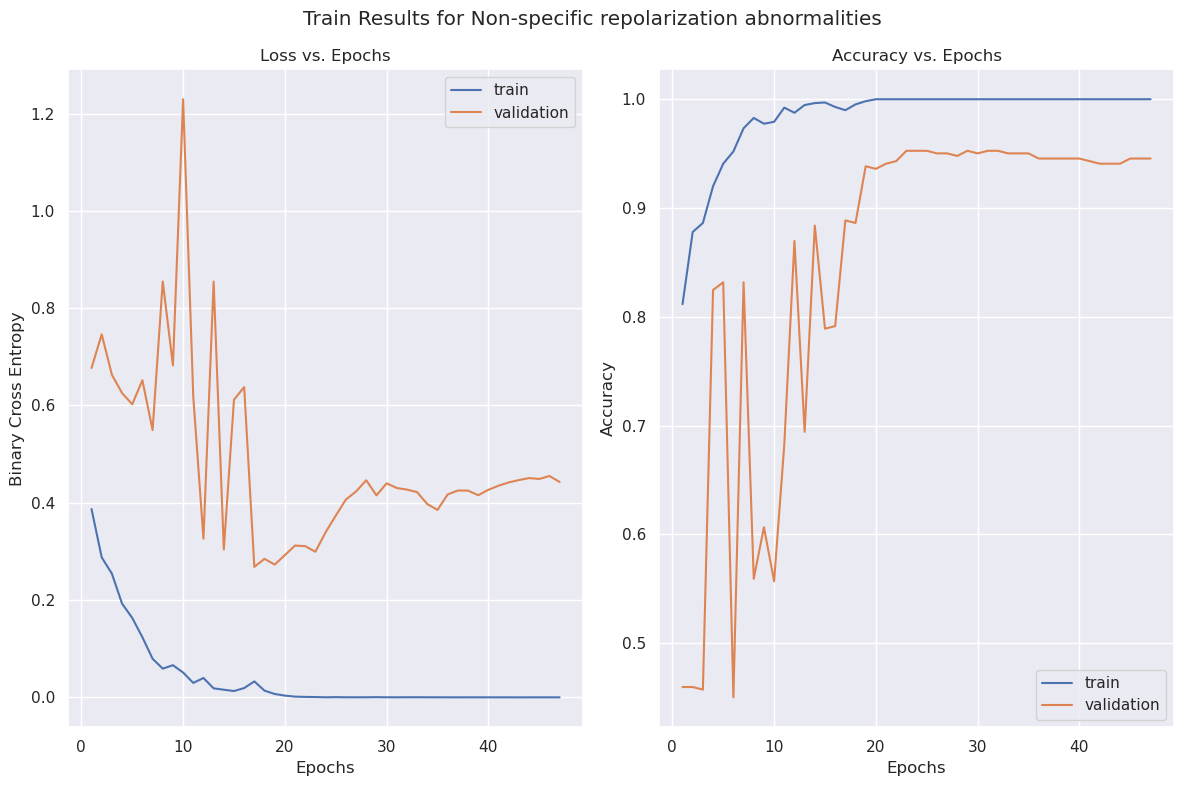

In [204]:
history = pickle_loader("model_histories/non_spec_rep.pickle")
plot_train_results(history, "Non-specific repolarization abnormalities")

17/17 [==============================] - 0s 9ms/step


([<matplotlib.axis.XTick at 0x7f2b9c266cd0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

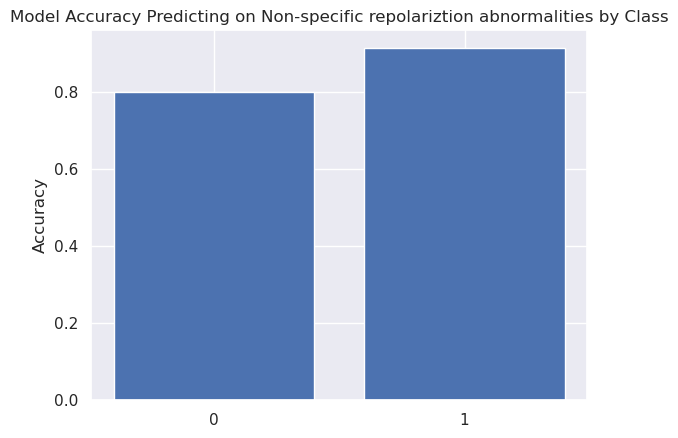

In [205]:
non_spec_rep_preds = model_nsr.predict(non_spec_rep_test[0]).flatten().round()


acc_ca0 = accuracy_score(non_spec_rep_preds[non_spec_rep_test[1]==0], non_spec_rep_test[1][non_spec_rep_test[1]==0])
acc_ca1 = accuracy_score(non_spec_rep_preds[non_spec_rep_test[1]==1], non_spec_rep_test[1][non_spec_rep_test[1]==1])

plt.bar(np.arange(2), [acc_ca0, acc_ca1])
plt.title("Model Accuracy Predicting on Non-specific repolariztion abnormalities by Class")
plt.ylabel("Accuracy")
plt.xticks(ticks=[0,1])

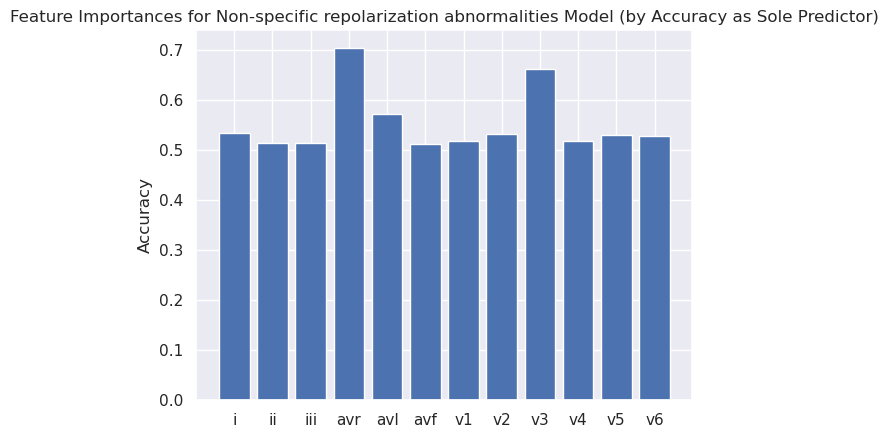

In [206]:
permutation_importance('Non-specific repolarization abnormalities', non_spec_rep_test[0], non_spec_rep_test[1], model_nsr);

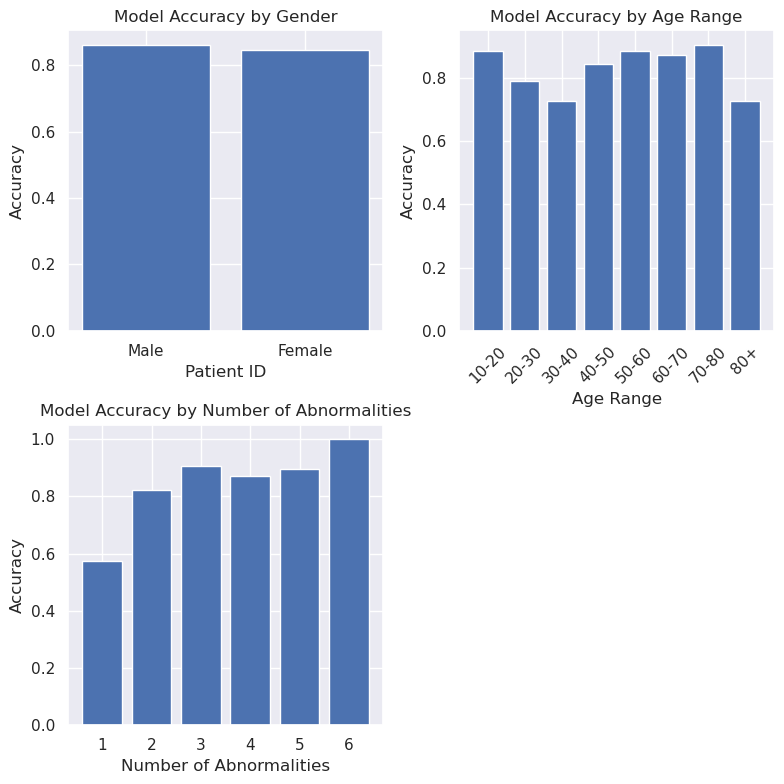

In [207]:
id_specific_results("Non-specific repolarization abnormalities", demodf_enc, non_spec_rep_test[0], non_spec_rep_test[1], non_spec_rep_ids, model_nsr)

<a id="3.3.4eval"></a>
#### Overall Evaluation

1. Class Separated Predictions

    The model seems to be predicting more accurately on the presence of repolarization abnormality than absence.
    
2. Permutation Importances
    Looking at the permutation importances, we see that leads aVR (Left Ventricle), and v3 (anterior surface of the heart) were the most important. Since repolarization most directly affects the heart's ventricles and the strength of their contraction, it would make sense that the left ventricle was weighted to be the top predictor.
3. Demographically Separated Predictions
    - Sex
        - The model seems to have very similar accuracies across sexes
    - Age
        - While there isn't a clear trend between age and accuracy, we see that the different ages do have noticeable different accuracies, implying the possibility of some kind of complex relationship. 
    - Number of Abnormalities
        - There seems to be a clear positive relationship between number of abnormalities and model accuracy. This likely serves as indication that this information would be of benefit to the model.

<a id="4"></a>
# 4 Final Model

The results of our models in section 3 make it clear that for our final model, we need to include some of the availble demographic information as an additional input to help the model contextualize the ECG traces it is being presented with. To do this, we will include an additional branch of the network that handles this demographic information, then merges it with output of the convolutional layers post flattening.

<a id="4.1"></a>
## 4.1 Create New Tensorflow Dataset Pipeline

In [18]:
demodf_enc = pd.read_csv('demodf_enc.csv')
age_corr_df = demodf_enc.sort_values('Age')

# count all abnormalities per patient
demodf_abn = demodf_enc[['Rhythms', 'Conduction abnormalities', 'Extrasystolies', 'Hypertrophies', 'Cardiac pacing', 
                         'Ischemia', 'Non-specific repolarization abnormalities', 'Other states']]
age_corr_df['num_abn'] = demodf_abn.sum(axis=1)
age_corr_df = age_corr_df.astype({'Sex':int, 'Age':int, 'num_abn':int})
age_corr_df[['ID', 'Sex', 'Age', 'Rhythms', 'Conduction abnormalities', 'Extrasystolies', 'Hypertrophies', 'Cardiac pacing', 
                         'Ischemia', 'Non-specific repolarization abnormalities', 'Other states', 'num_abn']].head()

ID  Sex  Age  Rhythms  Conduction abnormalities  Extrasystolies  \
183  184    0   11        1                         0               0   
144  145    0   15        0                         0               0   
188  189    1   17        1                         0               0   
187  188    1   17        1                         0               0   
176  177    1   18        0                         0               0   

     Hypertrophies  Cardiac pacing  Ischemia  \
183              0               0         0   
144              0               0         0   
188              0               0         0   
187              1               0         0   
176              0               0         0   

     Non-specific repolarization abnormalities  Other states  num_abn  
183                                          0             0        1  
144                                          0             1        1  
188                                          1             0        2  
187                                          0             0        2  
176                                          0             0        0

In [19]:
def pickle_saver(item, filepath):
    with open(filepath, "wb") as pkle:
        pickle.dump(item, pkle)
    return
        
def pickle_loader(filepath):
    with open(filepath, "rb") as pkle:
        item = pickle.load(pkle)
    return item

def demo_data_getter(column, patient_ids, scale=True):
    
    # fit standard scaler to properly scale column
    all_col = age_corr_df[column].to_numpy()
    scal = StandardScaler().fit(all_col.reshape(-1,1))
    
    data_agg = []
    
    for i in range(len(patient_ids)):
        buff = age_corr_df.loc[age_corr_df['ID']==patient_ids[i]]
        data_agg.append(buff[column].iloc[0])
        
    output = np.array(data_agg)
    if scale:
        output = scal.transform(output.reshape(-1,1))
   
    return output.flatten()

def get_datasets_v2(resp):
    """
    Inputs: 
        resp: Response Columns of Interest ex: "Ischemia"
        
    Outputs:
        train_dataset (tf.dataset): Tensorflow dataset for training
        val_dataset (tf.dataset): Tensorflow dataset for validation
        test_dataset (tuple): Tuple of Numpy arrays for Xtest (N x 12 x 1423) and Ytest (N x 1)
        resp_ids (Nx1 Numpy Array): Arrays of IDs mapping observations to patients
    """
    
    # get data
    resp_xdata = pickle_loader(f"pickle_data/{resp}_xdata.pickle")
    resp_ydata = pickle_loader(f"pickle_data/{resp}_ydata.pickle")
    resp_ids = pickle_loader(f"pickle_data/{resp}_ids.pickle")
    
    # get age, sex, number of abnormalities
    demo_data = np.zeros((len(resp_ids), 3))
    demo_data[:,0] = demo_data_getter('Age', resp_ids)
    demo_data[:,1] = demo_data_getter('Sex', resp_ids, scale=False)
    demo_data[:,2] = demo_data_getter('num_abn', resp_ids)
    
    
    # train val test split
    Xtemp, Xtest, Ytemp, Ytest, demo_temp, demo_test, temp_ids, test_ids = train_test_split(resp_xdata, resp_ydata, demo_data, resp_ids, test_size=.2, random_state=109)
    Xtrain, Xval, Ytrain, Yval, demo_train, demo_val, train_ids, val_ids = train_test_split(Xtemp, Ytemp, demo_temp, temp_ids, test_size=.2, random_state=109)
    
    # convert x and y to tfds
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = tf.data.Dataset.from_tensor_slices(((Xtrain, demo_train), Ytrain)).shuffle(4000).batch(64).prefetch(AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices(((Xval, demo_val), Yval)).shuffle(4000).batch(64).prefetch(AUTOTUNE)
#     test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest)).shuffle(4000).batch(64).prefetch(AUTOTUNE)
    test_dataset = ((Xtest, demo_test), Ytest)
    id_set = (train_ids, val_ids, test_ids)
    return train_dataset, val_dataset, test_dataset, id_set

In [20]:
ischemia_train, ischemia_val, ischemia_test, ischemia_ids = get_datasets_v2("Ischemia")

<a id="4.2"></a>
## 4.2 Create New 2 Branched Model

In [21]:
# Create a Residual Block
def Residual(X, num_channels, strides=1, use_1x1conv=False):
    # Define a convolutional layer with given num_channels, strides, kernel_size=3 and same padding 
    A = Conv1D(num_channels, strides=strides, kernel_size=3, padding='same', data_format='channels_first')(X)
    # Add a batch normalization layer
    A = BatchNormalization()(A)
    # Add ReLU activation
    A = Activation('relu')(A)
    # Define a convolutional layer with given num_channels, kernel_size=3 and same padding 
    A = Conv1D(num_channels, kernel_size=3, padding='same', data_format='channels_first')(A)
    # Add another batch normalization layer
    A = BatchNormalization()(A)
    if use_1x1conv:
        # Add a 1x1 convolution layer with given num_channels and strides
        X = tf.keras.layers.Conv2D(filters=num_channels, strides=strides, kernel_size=1)(X)
    # Add A and X for skip connection using Add layer from keras
    A = Add()([X, A]) # Skip connection
    return relu(A)

def ecg_Model_v2(input_shape):

    # Define the input layer
    inpt = Input(shape=input_shape)
    demo_input = Input(shape=(3))

    ### Convolution of ECG Data
    # Add convolutional layers
    X = Conv1D(128, kernel_size=5, strides=3, activation='relu', data_format='channels_first')(inpt)
    X = MaxPool1D(pool_size=2, data_format='channels_first')(X)
    X = Residual(X, 128)
    X = BatchNormalization()(X)
    X = Conv1D(64, kernel_size=3, activation='relu', data_format='channels_first')(X)
    X = MaxPool1D(pool_size=2, data_format='channels_first')(X)
    X = BatchNormalization()(X)
    X = Conv1D(32, kernel_size=3, activation='relu', data_format='channels_first')(X)
    X = MaxPool1D(pool_size=2, data_format='channels_first')(X)
    
    ### Weighting of Demographic data
    A = Dense(20, activation='relu')(demo_input)
    A = Dropout(0.2)(A)
    A = Dense(20, activation='relu')(demo_input)

    # Flatten and concatenate branches
    X = Flatten()(X)
    A = Flatten()(A)
    W = tf.keras.layers.Concatenate()([X, A])
    
    
    
    W = Dense(150, activation='relu')(W)
    W = Dropout(0.2)(W)
    outputs = Dense(1, activation='sigmoid')(W)

    # Define the model
    model = Model(inputs=[inpt, demo_input], outputs=outputs)

    return model

In [22]:
input_shape = (12,1423)
model = ecg_Model_v2(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 1423)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 473)     7808        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 128, 236)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 128, 236)     49280       ['max_pooling1d[0][0]']          
                                                                                              

<a id="4.3.1"></a>
### 4.3.1 Ischemia

In [23]:
history = model.fit(ischemia_train, epochs=200,
                   validation_data=ischemia_val,
                   callbacks=[ModelCheckpoint("models_v2/ischemia", save_best_only=True),
                             EarlyStopping(patience=30, restore_best_weights=True)])

pickle_saver(history.history, "model_v2_histories/ischemia.pickle")

Epoch 1/200


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/model/conv1d_4/Conv1D/Conv2DBackpropFilter' defined at (most recent call last):
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\justi\AppData\Local\Temp\ipykernel_67896\2452258632.py", line 1, in <module>
      history = model.fit(ischemia_train, epochs=200,
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\engine\training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\justi\miniconda3\envs\cs109b\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/model/conv1d_4/Conv1D/Conv2DBackpropFilter'
Conv2DCustomBackpropFilterOp only supports NHWC.
	 [[{{node gradient_tape/model/conv1d_4/Conv1D/Conv2DBackpropFilter}}]] [Op:__inference_train_function_4324]

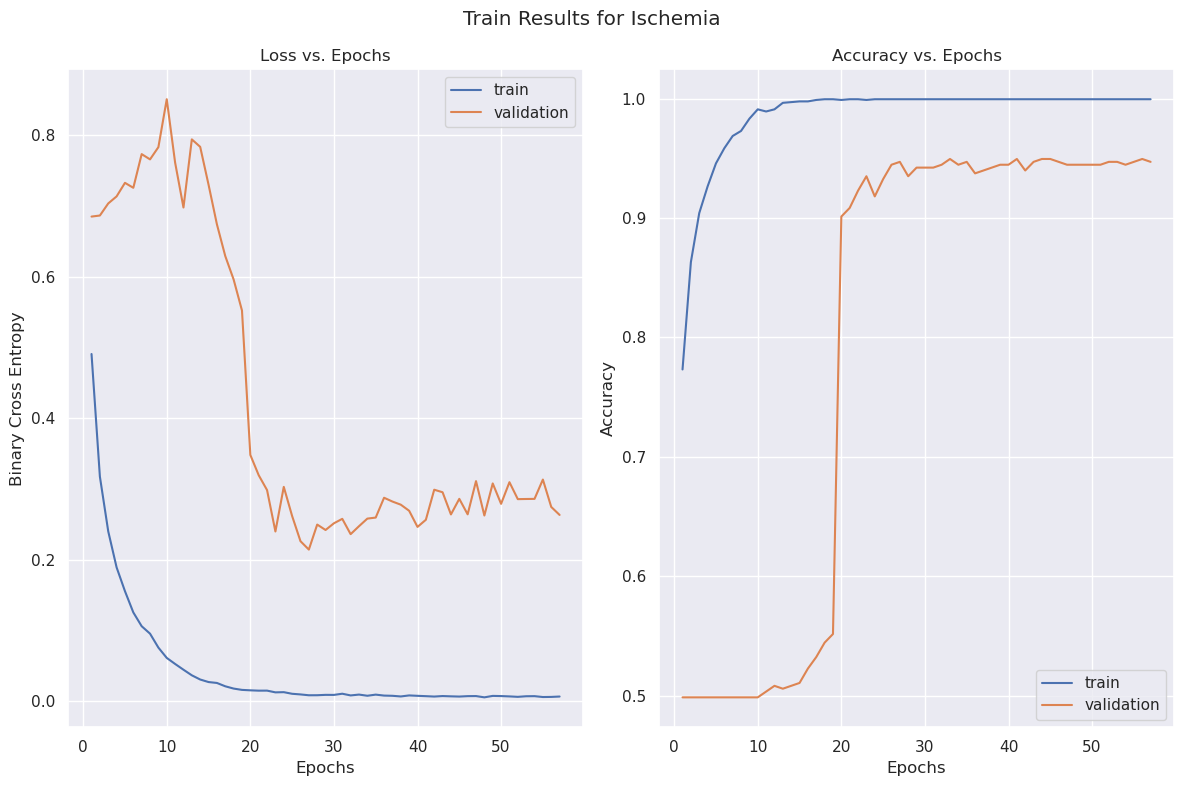

In [298]:
history = pickle_loader("model_v2_histories/ischemia.pickle")
plot_train_results(history, "Ischemia")

17/17 [==============================] - 0s 3ms/step
Test Accuracy: 0.934


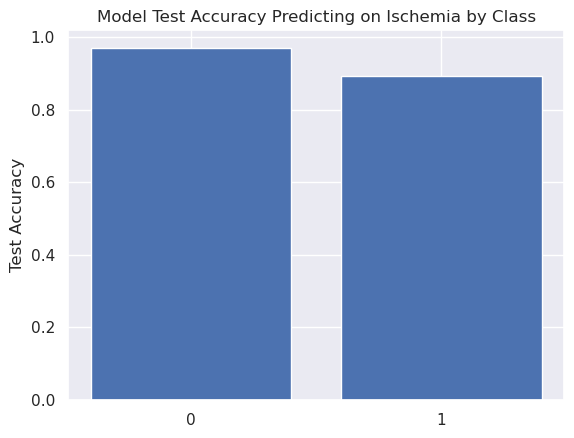

In [300]:
ischemia_raw_preds = model.predict(ischemia_test[0]).flatten()
ischemia_preds = ischemia_raw_preds.round()

acc0 = accuracy_score(ischemia_preds[ischemia_test[1]==0], ischemia_test[1][ischemia_test[1]==0])
acc1 = accuracy_score(ischemia_preds[ischemia_test[1]==1], ischemia_test[1][ischemia_test[1]==1])
full_acc = accuracy_score(ischemia_preds, ischemia_test[1])
plt.bar(np.arange(2), [acc0, acc1])
plt.title("Model Test Accuracy Predicting on Ischemia by Class")
plt.ylabel("Test Accuracy")
plt.xticks(ticks=[0,1])
print(f"Test Accuracy: {full_acc:.3f}")

In [303]:
def permutation_acc_v2(lead_idx, resp, xtest, ytest, model):
    
    resp_xdata = pickle_loader(f"pickle_data/{resp}_xdata.pickle")
    copy_xtest = np.copy(xtest[0])
    
    # get data
    for i in range(12):
        
        # leave lead of interest alone
        if i == lead_idx:
            continue
    
        data = resp_xdata[:,i,:]


        to_sub = np.mean(data, axis=0) # get mean of ECG lead in question
        full_sub = np.repeat(np.expand_dims(to_sub, axis=0), xtest[0].shape[0], axis=0)


        copy_xtest[:,i,:] = full_sub
        
    preds = model.predict((copy_xtest, xtest[1]), verbose=False).flatten().round()    
    return accuracy_score(preds, ytest)

def permutation_importance_v2(resp, xtest, ytest, model):
    lead_accs = []
    lead_names = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
    for i in range(12):
        lead_accs.append(permutation_acc_v2(i, resp, xtest, ytest, model))

    lead_accs = np.array(lead_accs)
#     lead_accs = lead_accs / np.max(lead_accs) # normalize importances
    plt.bar(np.arange(12), lead_accs)
    plt.title(f"Feature Importances for {resp} Model (by Accuracy as Sole Predictor)")
    plt.ylabel("Accuracy")

    plt.xticks(ticks=np.arange(12), labels=lead_names)
    return lead_accs

array([0.53179191, 0.522158  , 0.53179191, 0.54720617, 0.53757225,
       0.53371869, 0.53179191, 0.52023121, 0.52986513, 0.55876686,
       0.52601156, 0.53179191])

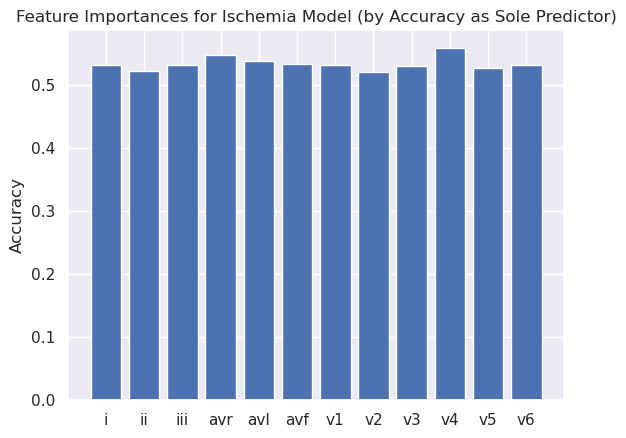

In [304]:
permutation_importance_v2("Ischemia", ischemia_test[0], ischemia_test[1], model)

In [311]:
def id_specific_results_v2(resp, demodf_enc, xtest, ytest, id_set, model):
    
    
    # get predictions
    preds = model.predict(xtest, verbose=False).flatten().round()  
    
    test_ids = id_set[2]
    
    # get ids belonging to each gender
    gender_ids = {}
    gender_ids[0] = demodf_enc.loc[demodf_enc['Sex']==0]['ID'].unique()
    gender_ids[1] = demodf_enc.loc[demodf_enc['Sex']==1]['ID'].unique()
    
    wave_index = {}
    
    # get wave indicies for all genders
    gender_counts = {}
    
    # loop through genders
    for gender in range(2):
        gender_counts[gender] = 0
        wave_index[gender] = []
        
        # get indices of waves belonging to specific gender
        for i in range(len(xtest[0])):
            if test_ids[i] in gender_ids[gender]:
                wave_index[gender].append(i)
                gender_counts[gender] += 1
                
        # convert to np array for easy indexing
        wave_index[gender] = np.array(wave_index[gender])
        
    # compute gender accuracies
    gender_accuracies = []
    for gender in range(2):
        gender_preds = preds[wave_index[gender]]
        gender_ytrue = ytest[wave_index[gender]]
        gen_acc = accuracy_score(gender_ytrue, gender_preds)
        gender_accuracies.append(gen_acc)
    gender_set = ([0, 1], gender_accuracies)
    
    #### get model accuracy by age
    # get age ranges
    ages = np.linspace(10, 80, 8)
    age_counts = {}
    
    age_wave_index = {}
    for i in range(len(ages)):
        age_counts[f"{ages[i]:.0f}-{ages[i]+10:.0f}"] = 0
        
        age_wave_index[i] = []
        # get patients in age range
        buff = demodf_enc.loc[(demodf_enc['Age']>=ages[i]) & (demodf_enc['Age']<ages[i]+10)]
        age_ids = buff['ID'].unique()
        
        
        # get wave ids for patients in age range
        for j in range(len(xtest[0])):
            if test_ids[j] in age_ids:
                age_wave_index[i].append(j)
                age_counts[f"{ages[i]:.0f}-{ages[i]+10:.0f}"] += 1
                
        # convert to np array for easy indexing
        age_wave_index[i] = np.array(age_wave_index[i])
    
    # compute age accuracies
    age_accuracies = []
    for i in range(len(ages)):
        # reusing above code
        age = i
        age_preds = preds[age_wave_index[age]]
        age_ytrue = ytest[age_wave_index[age]]
        age_acc = accuracy_score(age_ytrue, age_preds)
        age_accuracies.append(age_acc)
    age_set = (ages, age_accuracies)
        
    
    
    #### get model accuracy by # of abnormalities
    
    # get unique abnormality counts
    ab_count = age_corr_df['num_abn'].unique()
    ab_count = np.sort(ab_count)
    num_abn_count = {}
    
    abn_wave_index = {}
    for i in range(len(ab_count)):
        num_abn_count[ab_count[i]] = 0
        
        abn_wave_index[i] = []
        # get patients in abn range
        buff = age_corr_df.loc[age_corr_df['num_abn']==ab_count[i]]
        abn_ids = buff['ID'].unique()
        
        
        # get wave ids for patients in abn range
        for j in range(len(xtest[0])):
            if test_ids[j] in abn_ids:
                abn_wave_index[i].append(j)
                num_abn_count[ab_count[i]] += 1
                
        # convert to np array for easy indexing
        abn_wave_index[i] = np.array(abn_wave_index[i])
    
    # compute abn accuracies
    abn_accuracies = []
    for i in range(len(ab_count)):
        # reusing above code
        abn_preds = preds[abn_wave_index[i]]
        abn_ytrue = ytest[abn_wave_index[i]]
        abn_acc = accuracy_score(abn_ytrue, abn_preds)
        abn_accuracies.append(abn_acc)
    abn_set = (ab_count, abn_accuracies)
    
    fig, ax = plt.subplots(2, 2, figsize=(8,8))
    ax = ax.flatten()
    
    plt.sca(ax[0])
    plt.title("Model Accuracy by Gender")
    plt.bar(gender_set[0], gender_set[1])
    plt.xticks(ticks=[0,1], labels=["Male", "Female"])
    plt.xlabel("Patient ID")
    plt.ylabel("Accuracy")
    
    plt.sca(ax[1])
    plt.title("Model Accuracy by Age Range")
    xticker = np.linspace(0, len(age_set[0])-1, len(age_set[0]))
    plt.bar(xticker, age_set[1])
    ticklabels = [f"{age:.0f}-{age+10:.0f}" for age in age_set[0]]
    ticklabels[-1] = "80+"
    plt.xticks(ticks=xticker, labels=ticklabels, rotation=45)
    plt.xlabel("Age Range")
    plt.ylabel("Accuracy")
    
    plt.sca(ax[2])
    plt.title("Model Accuracy by Number of Abnormalities")
    xticker = np.linspace(0, len(abn_set[0])-1, len(abn_set[0]))
    plt.bar(xticker, abn_set[1])
    ticklabels = [f"{n}" for n in abn_set[0]]
#     ticklabels[-1] = ""
    plt.xticks(xticker, labels=ticklabels)
    plt.xlabel("Number of Abnormalities")
    plt.ylabel("Accuracy")
    
    ax[3].remove()
    
    plt.tight_layout()
    
    print(f"Gender Counts:\n{gender_counts}")
    print(f"Age Counts:\n{age_counts}")
    print(f"Number of Abnormailities Counts:\n{num_abn_count}")

Gender Counts:
{0: 325, 1: 194}
Age Counts:
{'10-20': 37, '20-30': 37, '30-40': 37, '40-50': 46, '50-60': 120, '60-70': 150, '70-80': 69, '80-90': 23}
Number of Abnormailities Counts:
{0: 42, 1: 68, 2: 198, 3: 147, 4: 61, 5: 3}


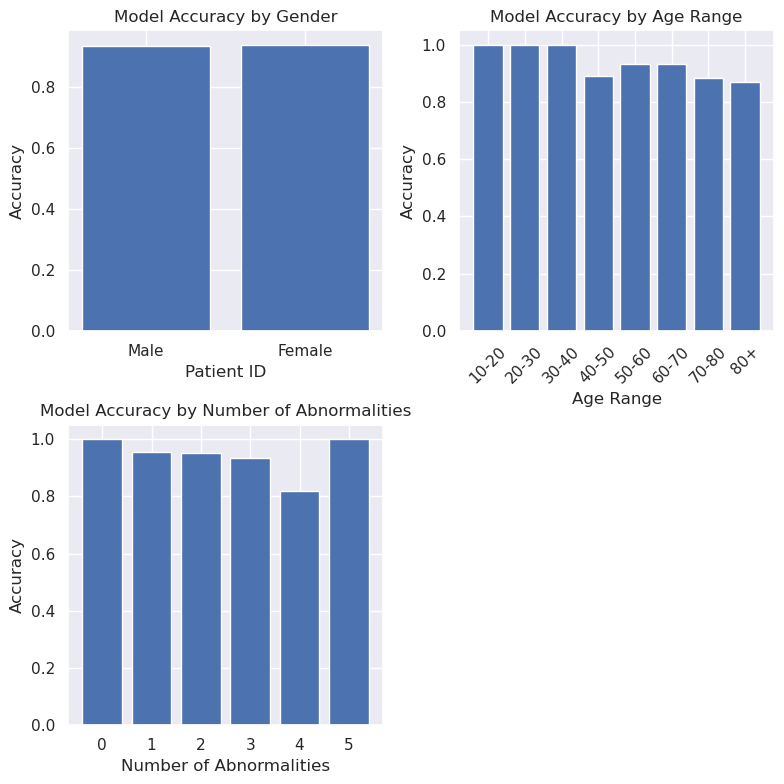

In [312]:
id_specific_results_v2('Ischemia', demodf_enc, ischemia_test[0], ischemia_test[1], ischemia_ids, model)

<a id="4.3.1eval"></a>
#### Overall Evaluation

1. Class Separated Predictions
    Similar to before, the model seems to be more accurate in predicting on observations representing the lack of ischemia as opposed to observations that actually do have ischemia. We also note that accuracy in predicting both classes seems greater than was observed with the baseline model.  
    
2. Permutation Importances
    Similar to before, it still appears as though each individual lead is not by itself a strong predictor of ischemia, meaning the model requires the combination of each of the different leads.
3. Demographically Separated Predictions
    - Sex
        - Similar to before, the model seems to predict with equal accuracy on the two genders.
    - Age
        - While we still see a negative relationship between accuracy and age, the magnitude of this relationship has decreased and we have become more accurate in predicting for later ages.
    - Number of Abnormalities
        - While the accuracy for each subpopulation has increased, the relative magnitudes of accuracy grouped by the number of abnormalities seems to be similar to before
        
From this, we can takeaway that the addition of age as a predictor seemed to give our model the greatest boost of the demographic predictors added.  

### <div style="background-color:orange">4.3.2 Hypertrophy (credit to George Popoola)</div>

In [16]:
hypertrophies_train, hypertrophies_val, hypertrophies_test, hypertrophies_ids = get_datasets_v2("Hypertrophies")

In [17]:
model = ecg_Model_v2(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])
history_hyp = model.fit(hypertrophies_train, epochs=200,
                   validation_data=hypertrophies_val,
                   callbacks=[ModelCheckpoint("models_v2/hypertrophies", save_best_only=True),
                             EarlyStopping(patience=30, restore_best_weights=True)])

pickle_saver(history_hyp.history, "model_v2_histories/hypertrophies.pickle")

Epoch 1/200


2023-05-08 21:41:30.394563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1606,3]
	 [[{{node Placeholder/_1}}]]
2023-05-08 21:41:30.395064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [1606]
	 [[{{node Placeholder/_2}}]]
2023-05-08 21:42:45.390639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-08 21:43:43.229912: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 21:43:48.183877: I tensorflow/compiler/xl

26/26 [==============================] - ETA: 0s - loss: 0.5352 - accuracy: 0.7360

2023-05-08 21:44:23.120976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [402]
	 [[{{node Placeholder/_2}}]]
2023-05-08 21:44:23.121388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [402,12,1423]
	 [[{{node Placeholder/_0}}]]
2023-05-08 21:44:24.250098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	

INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


26/26 [==============================] - 176s 212ms/step - loss: 0.5352 - accuracy: 0.7360 - val_loss: 0.6729 - val_accuracy: 0.5174
Epoch 2/200
25/26 [===========================>..] - ETA: 0s - loss: 0.3231 - accuracy: 0.8494

2023-05-08 21:44:28.227566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:44:28.987734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


26/26 [==============================] - 3s 122ms/step - loss: 0.3240 - accuracy: 0.8487 - val_loss: 0.6702 - val_accuracy: 0.5174
Epoch 3/200
26/26 [==============================] - 1s 19ms/step - loss: 0.2604 - accuracy: 0.8910 - val_loss: 0.6859 - val_accuracy: 0.5174
Epoch 4/200
26/26 [==============================] - 0s 16ms/step - loss: 0.2214 - accuracy: 0.9097 - val_loss: 0.6810 - val_accuracy: 0.5174
Epoch 5/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1847 - accuracy: 0.9271 - val_loss: 0.7067 - val_accuracy: 0.5174
Epoch 6/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1608 - accuracy: 0.9427 - val_loss: 0.7471 - val_accuracy: 0.5174
Epoch 7/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1292 - accuracy: 0.9533 - val_loss: 0.7922 - val_accuracy: 0.5174
Epoch 8/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1189 - accuracy: 0.9539 - val_loss: 0.8273 - val_accuracy: 0.5174
Epoch 9/200
26/26

2023-05-08 21:44:37.288606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:44:38.042752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


26/26 [==============================] - 3s 116ms/step - loss: 0.0396 - accuracy: 0.9875 - val_loss: 0.6368 - val_accuracy: 0.5323
Epoch 16/200
25/26 [===========================>..] - ETA: 0s - loss: 0.0296 - accuracy: 0.9956

2023-05-08 21:44:40.670972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:44:41.434031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


26/26 [==============================] - 3s 133ms/step - loss: 0.0296 - accuracy: 0.9956 - val_loss: 0.6287 - val_accuracy: 0.5348
Epoch 17/200
25/26 [===========================>..] - ETA: 0s - loss: 0.0281 - accuracy: 0.9962

2023-05-08 21:44:43.718862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:44:44.477614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


26/26 [==============================] - 3s 120ms/step - loss: 0.0282 - accuracy: 0.9963 - val_loss: 0.5186 - val_accuracy: 0.7264
Epoch 18/200
22/26 [========================>.....] - ETA: 0s - loss: 0.0225 - accuracy: 0.9964

2023-05-08 21:44:48.809808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:44:49.566395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


26/26 [==============================] - 3s 133ms/step - loss: 0.0223 - accuracy: 0.9963 - val_loss: 0.3985 - val_accuracy: 0.8184
Epoch 19/200
25/26 [===========================>..] - ETA: 0s - loss: 0.0184 - accuracy: 0.9975

2023-05-08 21:44:52.185195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:44:52.950194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


26/26 [==============================] - 3s 120ms/step - loss: 0.0185 - accuracy: 0.9975 - val_loss: 0.2898 - val_accuracy: 0.9129
Epoch 20/200
22/26 [========================>.....] - ETA: 0s - loss: 0.0177 - accuracy: 0.9972

2023-05-08 21:44:55.230108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:44:55.994517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


26/26 [==============================] - 3s 119ms/step - loss: 0.0180 - accuracy: 0.9969 - val_loss: 0.2606 - val_accuracy: 0.9055
Epoch 21/200
24/26 [==========================>...] - ETA: 0s - loss: 0.0194 - accuracy: 0.9948

2023-05-08 21:44:58.291846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:44:59.426189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


26/26 [==============================] - 3s 136ms/step - loss: 0.0193 - accuracy: 0.9950 - val_loss: 0.2224 - val_accuracy: 0.9378
Epoch 22/200
24/26 [==========================>...] - ETA: 0s - loss: 0.0133 - accuracy: 0.9993

2023-05-08 21:45:01.790117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:45:02.567360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


INFO:tensorflow:Assets written to: models_v2/hypertrophies/assets


26/26 [==============================] - 3s 124ms/step - loss: 0.0138 - accuracy: 0.9994 - val_loss: 0.1876 - val_accuracy: 0.9403
Epoch 23/200
26/26 [==============================] - 1s 19ms/step - loss: 0.0203 - accuracy: 0.9950 - val_loss: 0.2118 - val_accuracy: 0.9378
Epoch 24/200
26/26 [==============================] - 0s 16ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.1897 - val_accuracy: 0.9478
Epoch 25/200
26/26 [==============================] - 0s 16ms/step - loss: 0.0219 - accuracy: 0.9956 - val_loss: 0.2002 - val_accuracy: 0.9403
Epoch 26/200
26/26 [==============================] - 0s 16ms/step - loss: 0.0132 - accuracy: 0.9988 - val_loss: 0.1978 - val_accuracy: 0.9378
Epoch 27/200
26/26 [==============================] - 0s 16ms/step - loss: 0.0120 - accuracy: 0.9994 - val_loss: 0.2064 - val_accuracy: 0.9453
Epoch 28/200
26/26 [==============================] - 0s 16ms/step - loss: 0.0085 - accuracy: 0.9994 - val_loss: 0.2046 - val_accuracy: 0.9478
Epoch 29/20

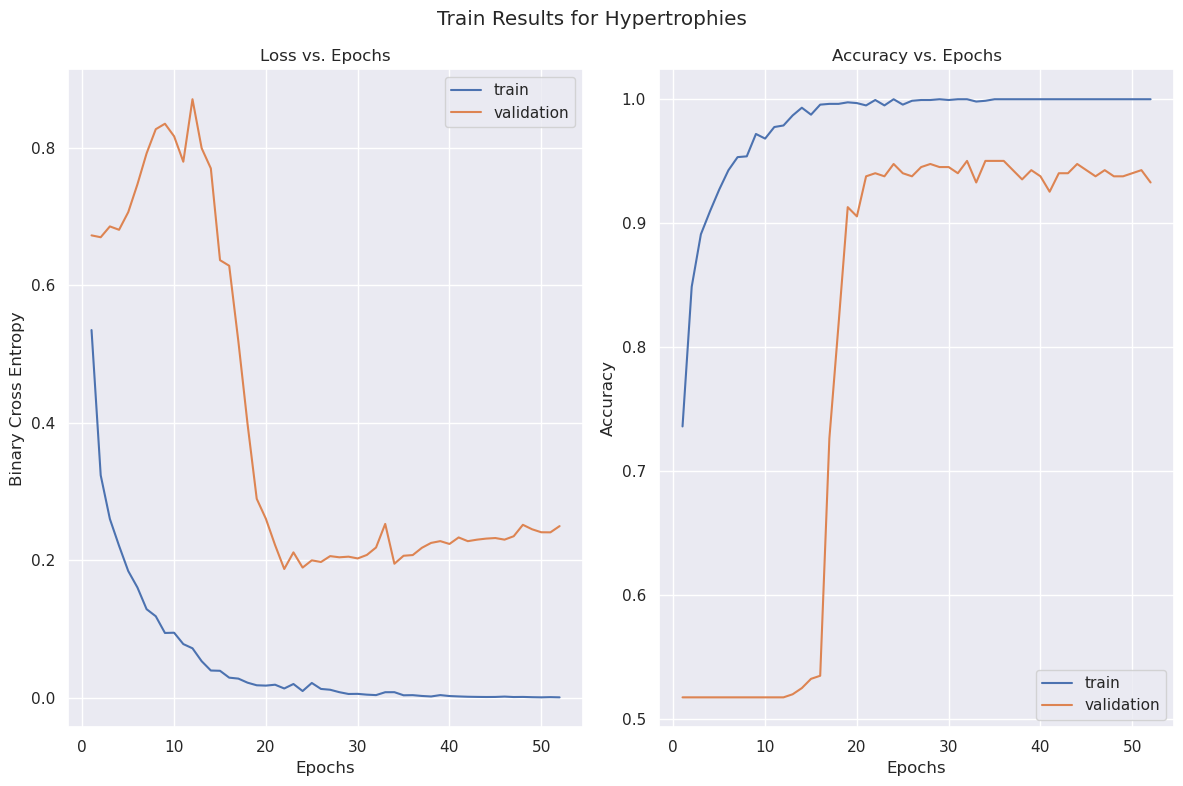

In [20]:
history_hyp = pickle_loader("model_v2_histories/hypertrophies.pickle")
plot_train_results(history_hyp, "Hypertrophies")

16/16 [==============================] - 1s 9ms/step
Test Accuracy: 0.886


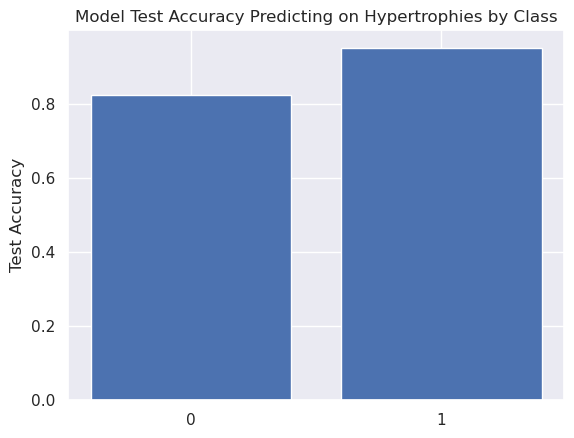

In [21]:
hypertrophies_raw_preds = model.predict(hypertrophies_test[0]).flatten()
hypertrophies_preds = hypertrophies_raw_preds.round()

acc0 = accuracy_score(hypertrophies_preds[hypertrophies_test[1]==0], hypertrophies_test[1][hypertrophies_test[1]==0])
acc1 = accuracy_score(hypertrophies_preds[hypertrophies_test[1]==1], hypertrophies_test[1][hypertrophies_test[1]==1])
full_acc = accuracy_score(hypertrophies_preds, hypertrophies_test[1])
plt.bar(np.arange(2), [acc0, acc1])
plt.title("Model Test Accuracy Predicting on Hypertrophies by Class")
plt.ylabel("Test Accuracy")
plt.xticks(ticks=[0,1])
print(f"Test Accuracy: {full_acc:.3f}")

array([0.5438247 , 0.4940239 , 0.4940239 , 0.50398406, 0.79880478,
       0.4940239 , 0.4940239 , 0.4940239 , 0.4940239 , 0.4940239 ,
       0.57968127, 0.49203187])

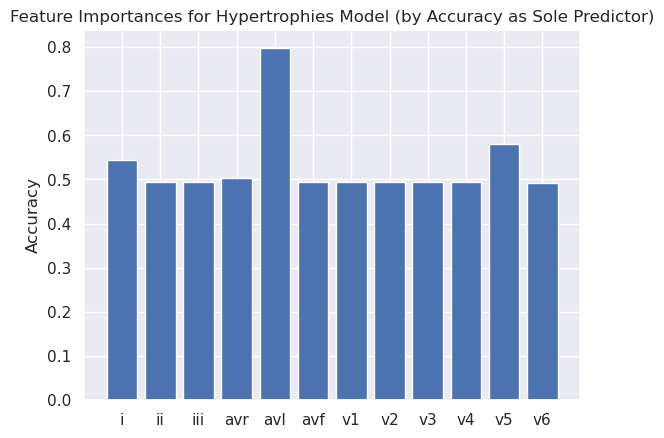

In [25]:
permutation_importance_v2("Hypertrophies", hypertrophies_test[0], hypertrophies_test[1], model)

Gender Counts:
{0: 291, 1: 211}
Age Counts:
{'10-20': 57, '20-30': 109, '30-40': 59, '40-50': 49, '50-60': 71, '60-70': 97, '70-80': 44, '80-90': 16}
Number of Abnormailities Counts:
{0: 100, 1: 98, 2: 180, 3: 103, 4: 18, 5: 3}


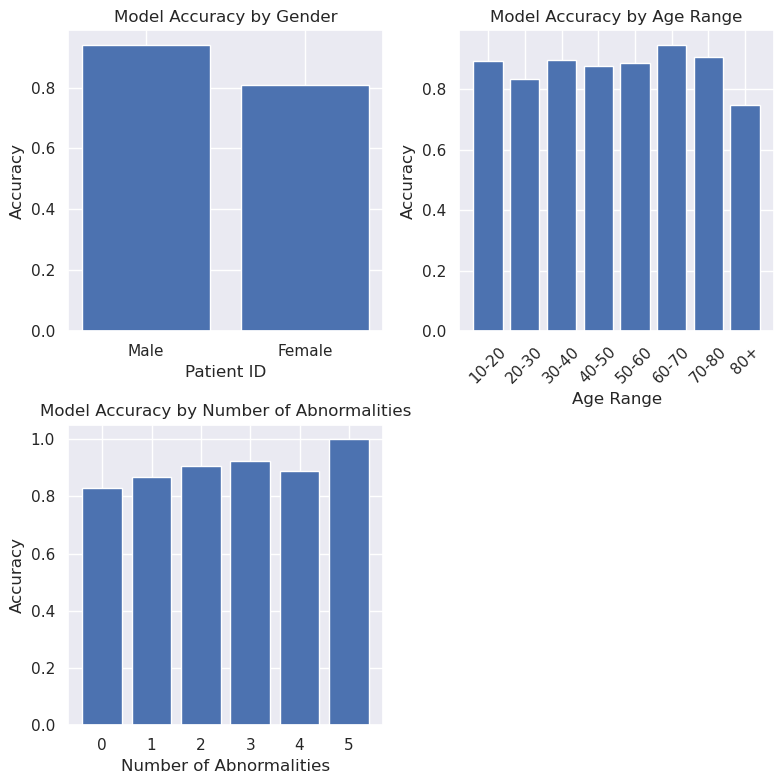

In [26]:
id_specific_results_v2('Hypertrophies', demodf_enc, hypertrophies_test[0], hypertrophies_test[1], hypertrophies_ids, model)

<a id="4.3.1eval"></a>
#### Overall Evaluation

1. Class Separated Predictions


    Based on the graph above, it seems that this model, contrary to the one for ischemia, is slighly better at predicting the presence of ishemia than detecting its absence. However, the difference is so slight, there may not be an actual effector and could be due to a sampling issue.
<br>
    
2. Permutation Importances


    Here, it appears that the avi lead (which is placed on the left arm and mainly focuses on the lateral wall of the left ventrical) contributes significantly more to the model prediction information than the other leads. This may make sense as hypertrophies involving the left ventricle seem to be one of the most common types. This is potentially the model learning about what the avl lead is observing in the left ventricle in the presense of hypertrophies.
<br>
    
3. Demographically Separated Predictions
    - Sex: As for sex, it seems that the model was better at predicting the condition of males correctly asopposed to females, by the same amount as previously, indicating the additional demographic information was not enough to resolve this imbalance.
    - Age: The model, in general, seemed to perform at around the same level for most age ranges, although tapering off in the 80+ age range (which is likely due to there being a lower number of samples for this class).
    - Number of Abnormalities: The model seems to perform better with an increasing number of abnormalities.
       
<u>Citations</u> 


“Hypertrophic Cardiomyopathy.” Pennmedicine.Org, www.pennmedicine.org/for-patients-and-visitors/patient-information/conditions-treated-a-to-z/hypertrophic-cardiomyopathy#:~:text=Obstructive%3A%20The%20most%20common%20type,(the%20body’s%20main%20artery). Accessed 8 May 2023. 
“The ECG Leads: Electrodes, Limb Leads, Chest (Precordial) Leads, 12-Lead ECG (EKG).” ECG &amp; ECHO, 28 Feb. 2023, ecgwaves.com/topic/ekg-ecg-leads-electrodes-systems-limb-chest-precordial/#:~:text=Lead%20aVL%2C%20I%20and%20%E2%80%93aVR,wall%20of%20the%20left%20ventricle. 

### <div style="background-color:orange"> 4.3.3 Conduction Abnormalities (credit to George Popoola) </div>

In [27]:
cond_train, cond_val, cond_test, cond_ids = get_datasets_v2("Conduction abnormalities")

In [28]:
model = ecg_Model_v2(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])
history_cond = model.fit(cond_train, epochs=200,
                   validation_data=cond_val,
                   callbacks=[ModelCheckpoint("models_v2/cond", save_best_only=True),
                             EarlyStopping(patience=30, restore_best_weights=True)])

pickle_saver(history_cond.history, "model_v2_histories/cond.pickle")

Epoch 1/200
 4/24 [====>.........................] - ETA: 0s - loss: 2.3976 - accuracy: 0.5156

2023-05-08 21:49:17.537468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1519,3]
	 [[{{node Placeholder/_1}}]]
2023-05-08 21:49:17.537876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1519,3]
	 [[{{node Placeholder/_1}}]]


24/24 [==============================] - ETA: 0s - loss: 0.8508 - accuracy: 0.7215

2023-05-08 21:49:18.959141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [380,3]
	 [[{{node Placeholder/_1}}]]
2023-05-08 21:49:18.959602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [380,3]
	 [[{{node Placeholder/_1}}]]
2023-05-08 21:49:19.838066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[

INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 5s 193ms/step - loss: 0.8508 - accuracy: 0.7215 - val_loss: 0.4023 - val_accuracy: 0.8000
Epoch 2/200
21/24 [=========================>....] - ETA: 0s - loss: 0.3756 - accuracy: 0.8132

2023-05-08 21:49:23.346904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:49:24.118181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 3s 131ms/step - loss: 0.3737 - accuracy: 0.8144 - val_loss: 0.3474 - val_accuracy: 0.8474
Epoch 3/200
22/24 [==========================>...] - ETA: 0s - loss: 0.3143 - accuracy: 0.8608

2023-05-08 21:49:26.394318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:49:27.161830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 3s 130ms/step - loss: 0.3103 - accuracy: 0.8611 - val_loss: 0.3040 - val_accuracy: 0.8632
Epoch 4/200
23/24 [===========================>..] - ETA: 0s - loss: 0.2665 - accuracy: 0.8927

2023-05-08 21:49:29.458267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:49:30.229199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 3s 147ms/step - loss: 0.2652 - accuracy: 0.8947 - val_loss: 0.2882 - val_accuracy: 0.8921
Epoch 5/200
24/24 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9210

2023-05-08 21:49:32.903362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:49:33.670511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 3s 131ms/step - loss: 0.2213 - accuracy: 0.9210 - val_loss: 0.2706 - val_accuracy: 0.8895
Epoch 6/200
24/24 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9381

2023-05-08 21:49:35.966165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:49:36.731358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 3s 130ms/step - loss: 0.1931 - accuracy: 0.9381 - val_loss: 0.2584 - val_accuracy: 0.9026
Epoch 7/200
22/24 [==========================>...] - ETA: 0s - loss: 0.1497 - accuracy: 0.9560

2023-05-08 21:49:39.039349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:49:40.182450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 3s 147ms/step - loss: 0.1491 - accuracy: 0.9566 - val_loss: 0.2424 - val_accuracy: 0.9000
Epoch 8/200
24/24 [==============================] - 1s 20ms/step - loss: 0.1314 - accuracy: 0.9625 - val_loss: 0.2486 - val_accuracy: 0.9079
Epoch 9/200
21/24 [=========================>....] - ETA: 0s - loss: 0.1041 - accuracy: 0.9732

2023-05-08 21:49:42.918221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:49:43.686234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 3s 127ms/step - loss: 0.1047 - accuracy: 0.9737 - val_loss: 0.2305 - val_accuracy: 0.9158
Epoch 10/200
24/24 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9829

2023-05-08 21:49:45.985403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:49:46.743570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 3s 131ms/step - loss: 0.0855 - accuracy: 0.9829 - val_loss: 0.2170 - val_accuracy: 0.9158
Epoch 11/200
24/24 [==============================] - 1s 20ms/step - loss: 0.0721 - accuracy: 0.9855 - val_loss: 0.2235 - val_accuracy: 0.9211
Epoch 12/200
24/24 [==============================] - 0s 16ms/step - loss: 0.0541 - accuracy: 0.9914 - val_loss: 0.2202 - val_accuracy: 0.9184
Epoch 13/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0433 - accuracy: 0.9933

2023-05-08 21:49:52.576320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:49:53.348738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 4s 169ms/step - loss: 0.0453 - accuracy: 0.9928 - val_loss: 0.2082 - val_accuracy: 0.9237
Epoch 14/200
24/24 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9954

2023-05-08 21:49:56.260003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:49:57.026885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/cond/assets


INFO:tensorflow:Assets written to: models_v2/cond/assets


24/24 [==============================] - 3s 130ms/step - loss: 0.0361 - accuracy: 0.9954 - val_loss: 0.2037 - val_accuracy: 0.9184
Epoch 15/200
24/24 [==============================] - 1s 20ms/step - loss: 0.0322 - accuracy: 0.9974 - val_loss: 0.2148 - val_accuracy: 0.9184
Epoch 16/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0290 - accuracy: 0.9961 - val_loss: 0.2222 - val_accuracy: 0.9184
Epoch 17/200
24/24 [==============================] - 0s 16ms/step - loss: 0.0234 - accuracy: 0.9974 - val_loss: 0.2067 - val_accuracy: 0.9289
Epoch 18/200
24/24 [==============================] - 0s 16ms/step - loss: 0.0199 - accuracy: 0.9993 - val_loss: 0.2144 - val_accuracy: 0.9263
Epoch 19/200
24/24 [==============================] - 0s 17ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.2114 - val_accuracy: 0.9289
Epoch 20/200
24/24 [==============================] - 0s 16ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.2179 - val_accuracy: 0.9289
Epoch 21/20

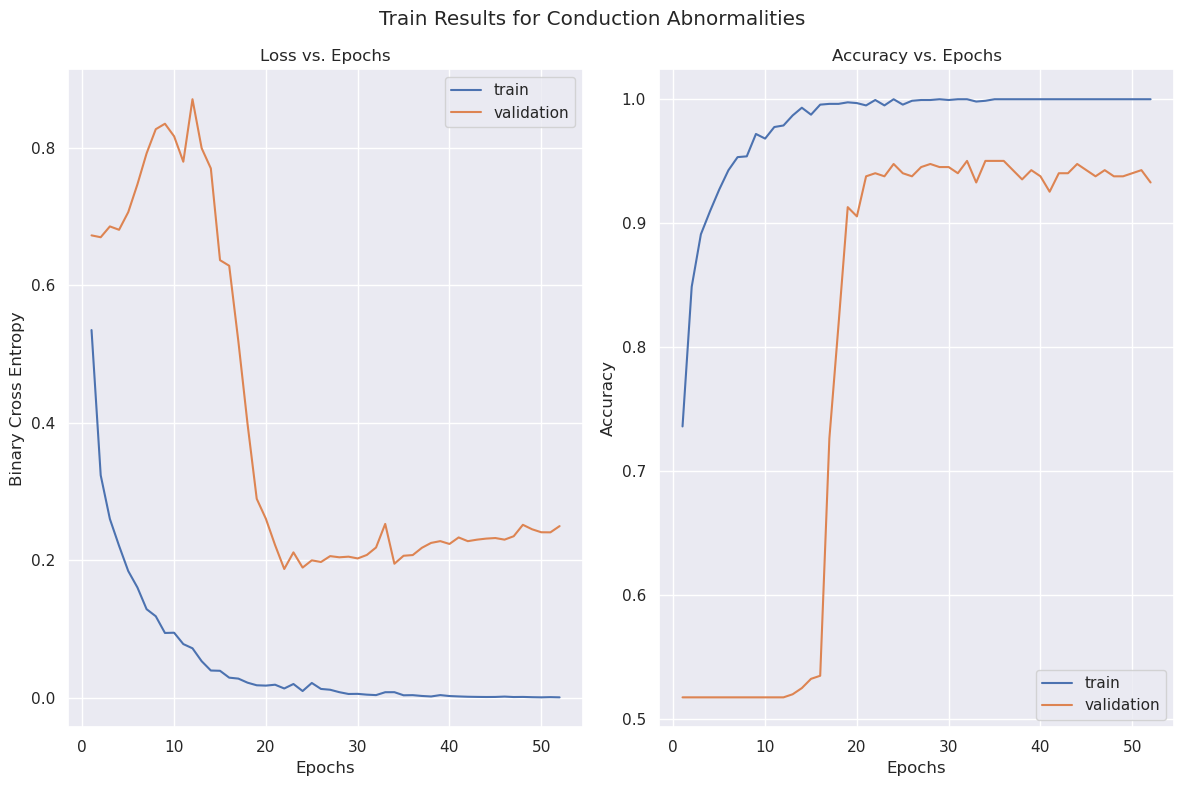

In [29]:
history_cond = pickle_loader("model_v2_histories/hypertrophies.pickle")
plot_train_results(history_cond, "Conduction Abnormalities")

15/15 [==============================] - 0s 7ms/step
Test Accuracy: 0.878


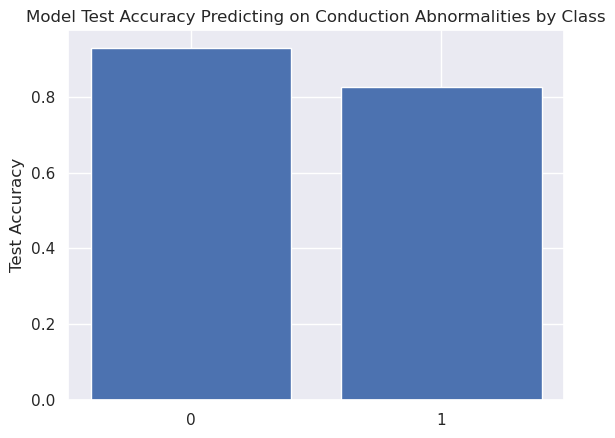

In [30]:
cond_raw_preds = model.predict(cond_test[0]).flatten()
cond_preds = cond_raw_preds.round()

acc0 = accuracy_score(cond_preds[cond_test[1]==0], cond_test[1][cond_test[1]==0])
acc1 = accuracy_score(cond_preds[cond_test[1]==1], cond_test[1][cond_test[1]==1])
full_acc = accuracy_score(cond_preds, cond_test[1])
plt.bar(np.arange(2), [acc0, acc1])
plt.title("Model Test Accuracy Predicting on Conduction Abnormalities by Class")
plt.ylabel("Test Accuracy")
plt.xticks(ticks=[0,1])
print(f"Test Accuracy: {full_acc:.3f}")

array([0.68631579, 0.69894737, 0.60210526, 0.68210526, 0.66315789,
       0.66526316, 0.65473684, 0.58315789, 0.69263158, 0.69684211,
       0.61684211, 0.67157895])

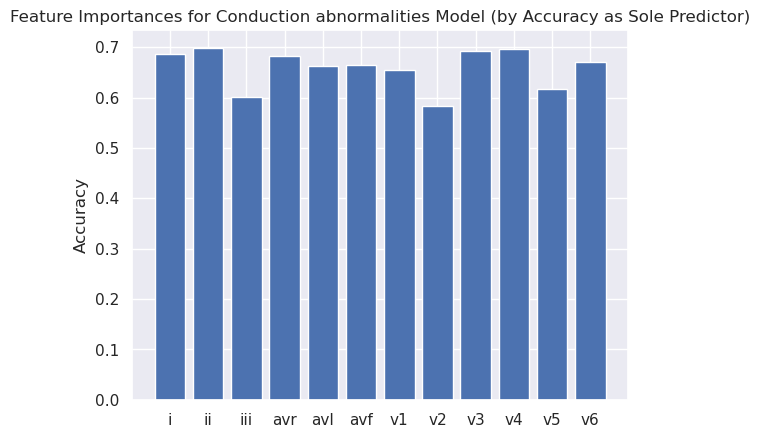

In [31]:
permutation_importance_v2("Conduction abnormalities", cond_test[0], cond_test[1], model)

Gender Counts:
{0: 288, 1: 187}
Age Counts:
{'10-20': 32, '20-30': 55, '30-40': 33, '40-50': 54, '50-60': 92, '60-70': 136, '70-80': 62, '80-90': 11}
Number of Abnormailities Counts:
{0: 37, 1: 72, 2: 182, 3: 143, 4: 33, 5: 8}


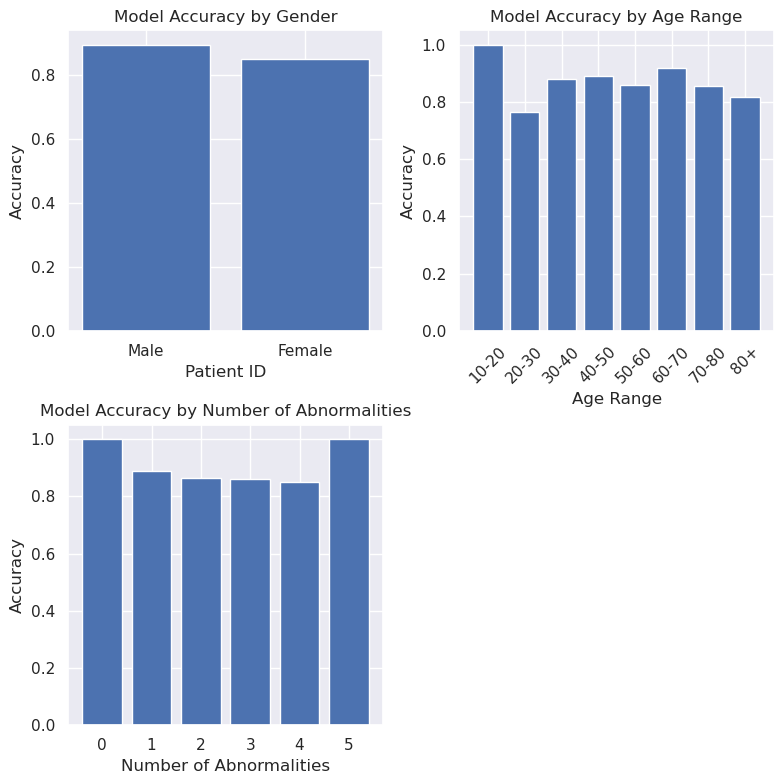

In [32]:
id_specific_results_v2('Conduction abnormalities', demodf_enc, cond_test[0], cond_test[1], cond_ids, model)

In [43]:
# Plot the model
plot_model(model, show_shapes=True, show_layer_activations=True, show_dtype=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### Overall Evaluation

1. Class Separated Predictions

Here, it seems that the model performs effectively the same (aand performs quite well) at predicting both the presence or absense of conduction abnormalities given an ECG wave. 

<br>
2. Permutation Importances

The iii lead and the v2 lead seem to be performing worse than the rest on average. But overall, the leads seem to have a comparable importance to the model performance.

<br>
3. Demographically Separated Predictions

- Sex: The predition accuracy based on sex seems to be essentially the same, with only a slightly higher value in males.
- Age: Across ages, there seems to be a significantly higher performance for younger ages for this model.
- Number of Abnormalities: As for the number of abnormalities, there seems to be comparable performances accross the board, but noticeably higher for no or 5 abnormalities.
        


### <div style="background-color:orange"> 4.3.4 Non-specific repolarization abnormalities (credit to Brian Ndzuki) </div>

In [49]:
non_spec_reps_train, non_spec_reps_val, non_spec_reps_test, non_spec_reps_ids = get_datasets_v2("Non-specific repolarization abnormalities")

In [34]:
model = ecg_Model_v2(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_nsr = model.fit(non_spec_reps_train, epochs=200,
                   validation_data=non_spec_rep_val,
                   callbacks=[ModelCheckpoint("models_v2/non_spec_rep", save_best_only=True),
                             EarlyStopping(patience=30, restore_best_weights=True)])

pickle_saver(history_nsr.history, "model_v2_histories/non_spec_rep.pickle")

Epoch 1/200
 4/27 [===>..........................] - ETA: 0s - loss: 0.8745 - accuracy: 0.7734

2023-05-08 21:50:22.442388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1688,3]
	 [[{{node Placeholder/_1}}]]
2023-05-08 21:50:22.442900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [1688]
	 [[{{node Placeholder/_2}}]]


27/27 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.8276

2023-05-08 21:50:23.695736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [422]
	 [[{{node Placeholder/_2}}]]
2023-05-08 21:50:23.696217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [422,12,1423]
	 [[{{node Placeholder/_0}}]]
2023-05-08 21:50:24.533214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	

INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


27/27 [==============================] - 4s 165ms/step - loss: 0.5052 - accuracy: 0.8276 - val_loss: 0.2944 - val_accuracy: 0.8507
Epoch 2/200
25/27 [==========================>...] - ETA: 0s - loss: 0.2587 - accuracy: 0.8813

2023-05-08 21:50:28.178122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:50:28.946978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


27/27 [==============================] - 3s 119ms/step - loss: 0.2572 - accuracy: 0.8803 - val_loss: 0.2779 - val_accuracy: 0.8768
Epoch 3/200
24/27 [=========================>....] - ETA: 0s - loss: 0.2050 - accuracy: 0.9173

2023-05-08 21:50:31.360303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:50:32.135651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


27/27 [==============================] - 3s 118ms/step - loss: 0.2058 - accuracy: 0.9153 - val_loss: 0.2311 - val_accuracy: 0.9005
Epoch 4/200
24/27 [=========================>....] - ETA: 0s - loss: 0.1696 - accuracy: 0.9323

2023-05-08 21:50:34.515639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:50:35.663785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


27/27 [==============================] - 4s 132ms/step - loss: 0.1682 - accuracy: 0.9325 - val_loss: 0.2163 - val_accuracy: 0.9028
Epoch 5/200
25/27 [==========================>...] - ETA: 0s - loss: 0.1333 - accuracy: 0.9531

2023-05-08 21:50:39.630945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:50:40.404392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


27/27 [==============================] - 3s 118ms/step - loss: 0.1347 - accuracy: 0.9514 - val_loss: 0.1984 - val_accuracy: 0.9289
Epoch 6/200
24/27 [=========================>....] - ETA: 0s - loss: 0.1051 - accuracy: 0.9688

2023-05-08 21:50:42.744753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:50:43.513217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


27/27 [==============================] - 3s 116ms/step - loss: 0.1025 - accuracy: 0.9698 - val_loss: 0.1977 - val_accuracy: 0.9171
Epoch 7/200
26/27 [===========================>..] - ETA: 0s - loss: 0.0722 - accuracy: 0.9826

2023-05-08 21:50:46.225823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:50:46.999641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


27/27 [==============================] - 3s 130ms/step - loss: 0.0739 - accuracy: 0.9822 - val_loss: 0.1839 - val_accuracy: 0.9289
Epoch 8/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0604 - accuracy: 0.9899 - val_loss: 0.2056 - val_accuracy: 0.9194
Epoch 9/200
25/27 [==========================>...] - ETA: 0s - loss: 0.0457 - accuracy: 0.9937

2023-05-08 21:50:49.823548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:50:50.637683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


27/27 [==============================] - 3s 115ms/step - loss: 0.0458 - accuracy: 0.9935 - val_loss: 0.1826 - val_accuracy: 0.9360
Epoch 10/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0335 - accuracy: 0.9964 - val_loss: 0.1895 - val_accuracy: 0.9313
Epoch 11/200
25/27 [==========================>...] - ETA: 0s - loss: 0.0237 - accuracy: 0.9975

2023-05-08 21:50:53.467120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]
2023-05-08 21:50:54.234421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,150]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


INFO:tensorflow:Assets written to: models_v2/non_spec_rep/assets


27/27 [==============================] - 3s 127ms/step - loss: 0.0232 - accuracy: 0.9976 - val_loss: 0.1813 - val_accuracy: 0.9384
Epoch 12/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0197 - accuracy: 0.9970 - val_loss: 0.1962 - val_accuracy: 0.9360
Epoch 13/200
27/27 [==============================] - 1s 16ms/step - loss: 0.0159 - accuracy: 0.9982 - val_loss: 0.1935 - val_accuracy: 0.9408
Epoch 14/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0126 - accuracy: 0.9994 - val_loss: 0.1824 - val_accuracy: 0.9431
Epoch 15/200
27/27 [==============================] - 1s 16ms/step - loss: 0.0102 - accuracy: 0.9994 - val_loss: 0.1960 - val_accuracy: 0.9408
Epoch 16/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.1884 - val_accuracy: 0.9455
Epoch 17/200
27/27 [==============================] - 1s 16ms/step - loss: 0.0083 - accuracy: 0.9994 - val_loss: 0.2046 - val_accuracy: 0.9384
Epoch 18/20

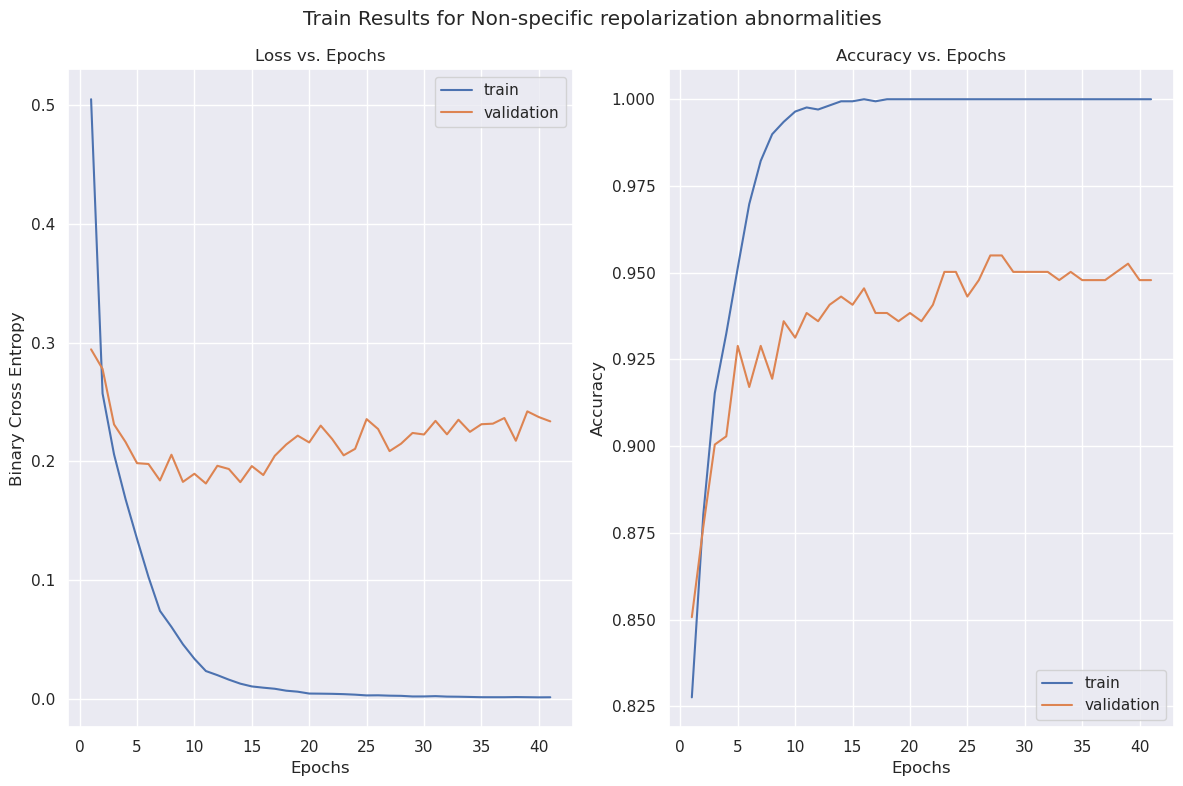

In [35]:
history_nsr = pickle_loader("model_v2_histories/non_spec_rep.pickle")
plot_train_results(history_nsr, "Non-specific repolarization abnormalities")

17/17 [==============================] - 0s 10ms/step
Test Accuracy: 0.911


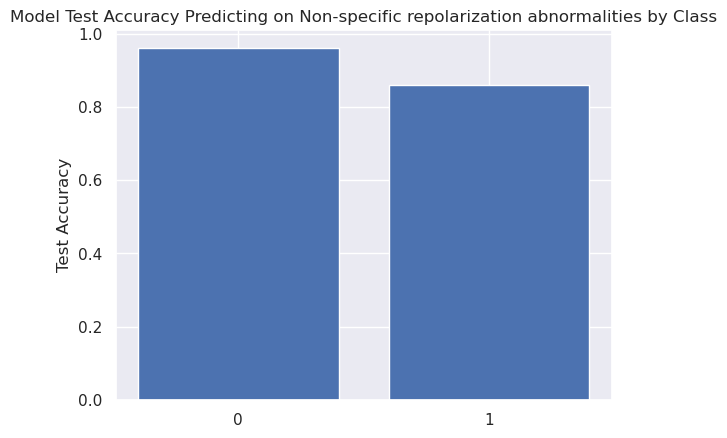

In [45]:
non_spec_reps_raw_preds = model.predict(non_spec_reps_test[0]).flatten()
non_spec_reps_preds = non_spec_reps_raw_preds.round()

acc0 = accuracy_score(non_spec_reps_preds[non_spec_reps_test[1]==0], non_spec_reps_test[1][non_spec_reps_test[1]==0])
acc1 = accuracy_score(non_spec_reps_preds[non_spec_reps_test[1]==1], non_spec_reps_test[1][non_spec_reps_test[1]==1])
full_acc = accuracy_score(non_spec_reps_preds, non_spec_reps_test[1])
plt.bar(np.arange(2), [acc0, acc1])
plt.title("Model Test Accuracy Predicting on Non-specific repolarization abnormalities by Class")
plt.ylabel("Test Accuracy")
plt.xticks(ticks=[0,1])
print(f"Test Accuracy: {full_acc:.3f}")

array([0.65719697, 0.76325758, 0.68939394, 0.79166667, 0.81628788,
       0.71212121, 0.6969697 , 0.72727273, 0.66666667, 0.7594697 ,
       0.82386364, 0.67424242])

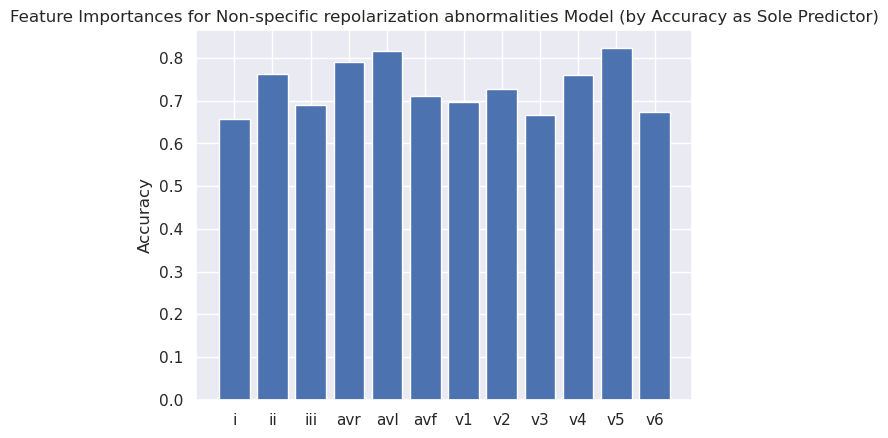

In [46]:
permutation_importance_v2("Non-specific repolarization abnormalities", non_spec_reps_test[0], non_spec_reps_test[1], model)

Gender Counts:
{0: 312, 1: 216}
Age Counts:
{'10-20': 44, '20-30': 48, '30-40': 44, '40-50': 45, '50-60': 114, '60-70': 148, '70-80': 74, '80-90': 11}
Number of Abnormailities Counts:
{0: 40, 1: 79, 2: 188, 3: 173, 4: 39, 5: 9}


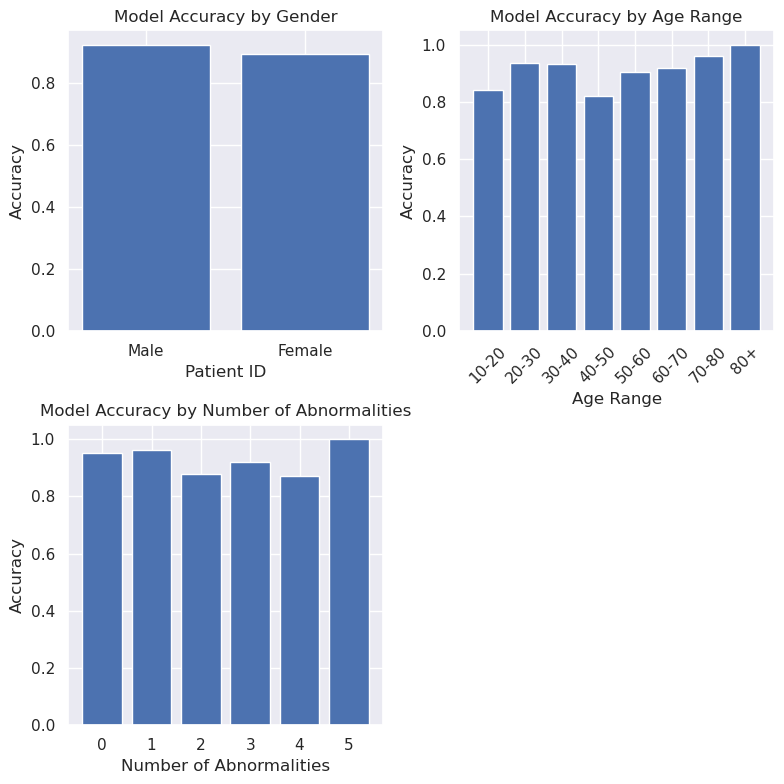

In [ ]:
id_specific_results_v2('Non-specific repolarization abnormalities', demodf_enc, non_spec_reps_test[0], non_spec_reps_test[1], non_spec_reps_ids, model)

#### Overall Evaluation

1. Class Separated Predictions

Similar to the model for conductance, what is observed is an almost equal prediction ability for both classes.

<br>
2. Permutation Importance

It seems that for this, the leads have varying levels of significance, but no one lead contributes significantly more or less to the model prediction is this could just be a result of their varying locations. This is probably more true considering the catregory deals with unspecified repolarization issues, so there will be an intrinsic spread in areas of importance.
    
<br>
3. Demographically Separated Predictions


- Sex: The prediction accuracy seems to be almost equal for both sexes, which is doesn't indicate anything out of the ordinary.
- Age: Surprisingly, despite the lower number of samples from the class in the overall training set, this model had the highest prediction accuracy for ages 80+, and this may be as a result of there being a higher number of people of this age range with this particular condition
- Number of Abnormalities:  The predicition accuracy for the number of abnormalities seem to be essentially even accross the board, with only slight differences.
  

# 5. Conclusions and Future Work Directions

## 5.1 Conclusions
Our final model achieves test accuracies of above 90% across all different heart conditions studied, which if achievable in a real world setting could be viable as a supplement to existing diagnostics by medical professionals. Additionally, our model’s sensitivities are in agreeance with existing medical knowledge on what parts of heart function (and thus ECG waves) best signal the presence of the heart conditions we considered. 
Given the relatively quick time to produce results, one could imagine the use of such a neural network in situtaions such as emergency medicine, when decision making in urgent situations could benefit from a more full understanding of a patient's health that traditionally requires at least one of time to pull up records and patient responsiveness. 

## 5.2 Future Work Directions

- More data
    - Our dataset includes near 2000 different individual ECG waves, but they come from only ~200 individual patients; having a more diverse patient set would allow our model results to be more easily generalized 
- GANs
    - Being able to generate characteristic ECG waves for the differing heart conditions could be useful as a way to visually prototype what the waves of afflicted individuals would look like
    - Could be useful in bolstering identification skills of physicians
    - Could be compared to what would be expected based solely on physical and anatomical knowledge
- Transfer Learning
    - It could be of benefit to investigate how a more sophisticated model architecture could perform when tuned towards our specific task, such as the ones made available by a Nature paper from 2021: https://www.nature.com/articles/s41598-021-84374-8